In [53]:
import collections
import math
import os
import zipfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

import time
import re

file_numbers = 10
vocabulary_size = 50000
projection_size = 300

In [2]:
def read_file(filename):
    """
    Arguments:
    filename -- a file to open
    Returns:
    sentence -- returns a list of sentences
    words -- returns a list of words
    """
    file = open(filename, 'rt')
    text = file.read().lower() # file read and convert to lowercases
    file.close()
    sentence = re.split('[.]\n|[?]\n|!\n', text) # .\n, ?\n, !\n
    words = re.sub(r'([^\s\w]|_)+', '', text).split()  # only alphanumerics+ blanks
    for i, text in enumerate(sentence): # only alphanumerics + blanks
        sentence[i] = re.sub(r'([^\s\w]|_)+', '', sentence[i])
    
    
    
    
    return sentence, words

start_time = time.time()
sent, words = read_file("news.en-00000-of-00100")
sent2,words2 = read_file("news.en-00001-of-00100")
end_time = time.time()

print(end_time - start_time)

14.363614797592163


In [54]:
def read_file_word(filename):
    """
    Arguments:
    filename -- a file to open
    Returns:
    words -- returns a list of words
    """
    file = open(filename, 'rt')
    text = file.read().lower() # file read and convert to lowercases
    file.close()
    words = re.sub(r'([^\s\w]|_)+', '', text).split()  # only alphanumerics+ blanks

    
    return words

def read_file_sent(filename):
    """
    Arguments:
    filename -- a file to open
    Returns:
    sentences -- returns a list of sentences
    """
    file = open(filename, 'rt')
    text = file.read().lower() # file read and convert to lowercases
    file.close()
    sentences = re.split('[.]\n|[?]\n|!\n', text) # .\n, ?\n, !\n
    for i, text in enumerate(sentences): # only alphanumerics + blanks
        sentences[i] = re.sub(r'([^\s\w]|_)+', '', sentences[i])
    sentences = list(filter(None, sentences))
    return sentences


start_time = time.time()
words = read_file_sent("news.en-00000-of-00100")
words2 = read_file_sent("news.en-00001-of-00100")
end_time = time.time()

print(end_time - start_time)

10.50078797340393


In [55]:
def word_frequencies(number_of_n_words=50000):
    """
    Arguments:
    number_of_n_words -- number of most frequent n words in the vocabulary you want to set
    
    Returns:
    int_voc -- a list of vocabulary that is mapped into integer-valeud index
    word_to_int -- python dict mapping words in the vocabulary into an integer-valued index
    int_to_word -- python dict mapping integer-valued index to words
    most_frequent_n_words -- a list with pairs of n most frequent words with its frequency -> [(word, frequency)]
    """
    vocabs = collections.Counter()
    for i in range(file_numbers):
        filename = "news.en-0000"+ str(i) + "-of-00100"
        words = read_file_word(filename)
        word_counts = collections.Counter(words)
        vocabs += word_counts
    
    most_frequent_n_words = vocabs.most_common(number_of_n_words - 1)
    word_to_int = {'UNK': 0} # set 0 as unknown token

    for word, _ in most_frequent_n_words:
        word_to_int[word] = len(word_to_int)
    
    int_to_word = {v: k for k, v in word_to_int.items()} # reverse dict of word_to_int


    count = 0
    

    for word in vocabs:
        if word not in word_to_int: # if word is in n most frequent words
            count += 1   # number of words that are not in n most frequent words
 
    most_frequent_n_words.insert(0, ('UNK', count))
    #most_frequent_n_words = np.insert(most_frequent_n_words, 0,('UNK', count),axis=0)
            
    return word_to_int,list(word_to_int.keys()), most_frequent_n_words

"""
단어들 index
"""
start_time = time.time()
word_to_int, ordered_words, most_frequent_n_words = word_frequencies(vocabulary_size)
end_time = time.time()
print(end_time - start_time)

63.872225761413574


In [56]:
def compute_f(most_frequent_n_words):
    """
    Computing the portion of each word from most_frequent_n_words
    parameter passing이 문제가 될시 most_frequent_n_words를 passing 하지않고 사용할 수도 있을 것 같다.
    Arguments:
    most_frequent_n_words -- a list of most frequent words, length of "vocabulary_size" 
                             with tuple [(word, word_frquency), ...]
    
    Returns:
    divided_frequency -- a numpy array containing the word_frequency in descending order, size of (vocabulary_size, )
    """
    list_to_numpy = np.array(most_frequent_n_words)
    divided_words = list_to_numpy[:, 0]
    divided_frequency = list_to_numpy[:, 1].astype(np.int)
    sum_frquency = np.sum(divided_frequency)
    assert ( sum_frquency.shape == ())
    divided_frequency = divided_frequency / sum_frquency
    
    
    
    return divided_frequency

In [57]:
divided_frequency = compute_f(most_frequent_n_words) # 필요한 코드 지우지말자

In [58]:
def noise_distribution(divided_frequency):
    """
    Used in negative sampling, the probabiltiy of choosing n negative samples
    Arguments:
    divided_frequency -- a numpy array of the frequency of each word, shape of (vocabulary_size,)

    Returns:
    neg_p_w: a numpy array of probability of each words in most_frequent_n_words, shape of (vocabulary_size, )
    """
    f = np.power(divided_frequency, 0.75)
    neg_p_w = f/ sum(f)
    return neg_p_w

In [59]:
noise = (noise_distribution(divided_frequency)) # 필요한 코드 지우지말자 

In [60]:
def str_to_int(filename, threshold=1e-5):
    """
    문자열로 이루어진 문장들을 숫자로 mapping하는 함수
    Arguments:
    filename -- a file to open
    Returns:
    int_voc -- mapping from str to int
    """
    int_voc = []
    sentences = read_file_sent(filename)
    
    
    for sentence in sentences:
        voc = []
        words = sentence.split()
        for word in words:
            if word in word_to_int:
                voc.append(word_to_int[word])
            #else:
            #    voc.append(0)
        int_voc.append(voc)

    drop = 1 - np.sqrt(1e-5/divided_frequency)
    
    # subsampling
    for i, sentence in enumerate(int_voc):
        int_voc[i] = [word for word in sentence if np.random.rand() > drop[word]]
        
    # erase sentence with only one word
    int_voc = [sentence for sentence in int_voc if len(sentence) > 1]
    return int_voc

In [11]:
int_voc = str_to_int("news.en-00000-of-00100")

In [13]:
def create_batch(int_voc, window_size, data_index, sentence_index):
    """
    while(true):
        create_batch()
        train....
        if data_index == -1 && sentence_index == -1:
            break
            
    """
    sentence = int_voc[sentence_index]
    batch = np.ndarray(shape=(), dtype=np.int32)
    
    start = max(0, data_index - window_size)
    end = min(data_index + window_size, len(sentence)-1)
    num_range = list(range(start, data_index)) + list(range(data_index + 1, end+1))

    labels = np.ndarray(shape=(len(num_range)), dtype=np.int32)
    batch = sentence[data_index]
    
    for i, index in enumerate(num_range): 
        labels[i] = sentence[index]
    # text의 끝이 도달할경우 어떻게 할것인지-> 다시 처음/ -1,-1을 return해서,
    # 다음 파일을 열여야 하는 것을 알려주는 방법으로 
    
    if len(sentence) == data_index + 1:
        if len(int_voc) - 1 == sentence_index:
            return batch, labels, -1, -1
        else:
            data_index = 0
            sentence_index += 1
    else:
        data_index += 1 
    
    
    return batch, labels, data_index, sentence_index

In [19]:
int_voc[276342]

[26, 2858, 67, 223, 5, 9695]

In [20]:
d=5
s=276342

batch, labels,d,s = create_batch(int_voc,3,d,s)
print(d,s)
for i in range(len(labels)):
    print('{} {} -> {} {}'.format(batch,     ordered_words[batch],
                                      labels[i], ordered_words[labels[i]]))

-1 -1
9695 supervisors -> 67 can
9695 supervisors -> 223 expected
9695 supervisors -> 5 and


In [21]:
def parameter_initialization(vocabulary_size, projection_size):
    """
    Initialization method -- he initialization. 
    
    Argument:
    vocabulary_size -- size of the vocabulary
    projection_size -- the dimension of hidden layer in NN
    
    Return:
    parameters -- a python dictionary containing weights 
                         -- W_in, size of (vocabulary_size, projection_size)
                         -- W_out, size of (projection_size, vocabulary_size)
    """
    try:
        parameters = {}
        parameters['W_in'] = np.load('W_in.npy')
        parameters['W_out'] = np.load('W_out.npy')
        print("Files loaded.")
    except FileNotFoundError as e:
        np.random.seed(0)
        parameters = {}

        parameters['W_in'] = np.random.randn(vocabulary_size, projection_size) *  np.sqrt(2 / vocabulary_size) 

        parameters['W_out'] = np.random.randn(projection_size, vocabulary_size) *  np.sqrt(2 / projection_size)

        assert (parameters['W_in'].shape == (vocabulary_size, projection_size)) 
        assert (parameters['W_out'].shape == (projection_size, vocabulary_size))
        print("Files not Found. Initialized new parameters")
        
    return parameters

In [20]:
parameters = parameter_initialization(vocabulary_size,projection_size)

Files loaded.


In [22]:
def sigmoid(z):
    """
    sigmoid function
    
    Arguments:
    Z -- a numpy array of any shape
    
    Returns:
    sig -- a numpy array of sigmoid(z)
    """
    
    sig = 1/(1 + np.exp(-z))
    
    return sig

In [25]:
def compute_cost_and_gradient(batch, label, parameters, negative_samples, k):
    """ 
    computes cost and the gradient for word2vec
    Arguments:
    batch -- the index of the target word 
    labels -- the index of the context words
    k -- number of negative sampling
    parameters -- a python dictionrary containing W_in and W_out, used to calcuate the part of cost function
    
    Returns:
    cost -- a total cost value of the word2vec
    """
    # cost 계산
    cost = 0 
    W_in = parameters["W_in"]
    W_out = parameters['W_out']
    
    hidden = W_in.T[:,[batch]] # shape (projection_size, 1)
    out = W_out[:, [label]] # shape (projection_size, 1)
    

    pos = np.sum(np.multiply(out,hidden), axis=0)
    pos = pos.squeeze()
    pos = -np.log(sigmoid(pos)) # cost for postive sample
    
    neg_batch = np.array([batch for _ in range(k)])
    neg_hidden = W_in.T[:, neg_batch] # size (projection_size, k)
    
    neg_out = W_out[:, negative_samples] # size (projection_size, k)
    
    negs = - np.sum(np.multiply(neg_out, neg_hidden), axis=0)
    negs = - np.log(sigmoid(negs))
    negs = np.sum(negs)
    cost = pos + negs
    

    # gradient 계산


    out_sig = sigmoid(np.sum(np.multiply(out,hidden),axis=0)) - 1
    out_neg_sig = sigmoid(np.sum(np.multiply(neg_out, hidden),axis=0, keepdims=True)) 
    
    assert(out_neg_sig.shape == (1, k))

    s = np.sum(out_neg_sig * neg_out, axis=1, keepdims=True)
    t = np.multiply(out_sig, out)

    assert(s.shape==t.shape)

    grads_in = s+t
    
    grads_out = (out_sig) * hidden  # hidden (100, 1)
    grads_neg_out = (out_neg_sig) *  hidden
    
        
    
    assert (pos.shape == ())
    assert(cost.shape == ())
    return cost, grads_in, grads_out, grads_neg_out

In [47]:
def skipgram(vocabulary_size, projection_size, epoch,learning_rate=0.025, k=10):
    """
    Arguments:
    
    Returns:
    
    """
    parameters = parameter_initialization(vocabulary_size,projection_size)
    W_in = parameters['W_in']
    W_out = parameters['W_out']
    print("W_in shape:",W_in.shape)
    print("W_out shape:", W_out.shape)
    for _ in range(epoch):
        for j in range(3,10): #여기바꾸기
            i = 0
            filename = "news.en-0000"+ str(j) + "-of-00100"
            int_voc = str_to_int(filename)
            data_index = 0
            sentence_index = 0
            while True:
                costs = 0
                mean_grads_in = 0
                if data_index == -1 and sentence_index == -1:
                    break
                batch, labels, data_index, sentence_index = create_batch(int_voc,3, data_index,sentence_index)
                negative_samples = np.random.choice(np.arange(0,vocabulary_size),k,p=noise)

                for label in labels:
                    cost,grads_in,grads_out, grads_neg_out = compute_cost_and_gradient(batch,label, parameters,negative_samples, k)
                    costs += cost
                    W_out[:, [label]] = W_out[:,[label]] - learning_rate * grads_out
                    W_out[:,negative_samples] = W_out[:, negative_samples] - learning_rate * grads_neg_out
                    mean_grads_in += grads_in
               
            
                i+=1
                if i % 100000 == 0:
                    print("The cost at:", i,"th iteration is",costs)
                
                mean_grads_in = mean_grads_in / len(labels)
                W_in[[batch],:] = W_in[[batch],:] - learning_rate * mean_grads_in.T
                
              


            np.save('W_in', parameters['W_in'])
            np.save('W_out', parameters['W_out'])
            print("File saved!")
            
    return parameters

In [48]:
start_time = time.time()
skipgram(vocabulary_size,projection_size, 1)
end_time = time.time()
print(end_time - start_time)





Files loaded.
W_in shape: (50000, 300)
W_out shape: (300, 50000)
The cost at: 100000 th iteration is 8.74348212904
The cost at: 200000 th iteration is 12.1036079583
The cost at: 300000 th iteration is 13.7516430344
The cost at: 400000 th iteration is 18.476363548
The cost at: 500000 th iteration is 8.92028245018
The cost at: 600000 th iteration is 16.8416784655
The cost at: 700000 th iteration is 13.1422499117
The cost at: 800000 th iteration is 15.9571223557
The cost at: 900000 th iteration is 9.25683563584
The cost at: 1000000 th iteration is 11.5767621032
The cost at: 1100000 th iteration is 9.12215051303
The cost at: 1200000 th iteration is 14.6326365003
The cost at: 1300000 th iteration is 12.3168436336
The cost at: 1400000 th iteration is 15.1732868989
The cost at: 1500000 th iteration is 13.7326450095
The cost at: 1600000 th iteration is 10.9527226575
The cost at: 1700000 th iteration is 13.997165872
File saved!
The cost at: 1800000 th iteration is 10.4517612362
The cost at: 190

FileNotFoundError: [Errno 2] No such file or directory: 'news.en-000010-of-00100'

In [65]:
def ski(vocabulary_size, projection_size, epoch,learning_rate=0.025, k=10):
    """
    Arguments:
    
    Returns:
    
    """
    parameters = parameter_initialization(vocabulary_size,projection_size)
    W_in = parameters['W_in']
    W_out = parameters['W_out']
    print("W_in shape:",W_in.shape)
    print("W_out shape:", W_out.shape)
    for _ in range(epoch):
        for j in range(1): #여기바꾸기
            i = 0
            filename = "news.en-0000"+ str(j) + "-of-00100"
            int_voc = str_to_int(filename)
            data_index = 0
            sentence_index = 0
            start = time.time()
            while True:
                costs = 0
                mean_grads_in = 0
                if data_index == -1 and sentence_index == -1:
                    break
                batch, labels, data_index, sentence_index = create_batch(int_voc,3, data_index,sentence_index)
                negative_samples = np.random.choice(np.arange(0,vocabulary_size),k)

                for label in labels:
                    cost,grads_in,grads_out, grads_neg_out = compute_cost_and_gradient(batch,label, parameters,negative_samples, k)
                    costs += cost
                    W_out[:, [label]] = W_out[:,[label]] - learning_rate * grads_out
                    W_out[:,negative_samples] = W_out[:, negative_samples] - learning_rate * grads_neg_out
                    mean_grads_in += grads_in
               
            
                i+=1
                if i % 100000 == 0:
                    print("The cost at:", i,"th iteration is",costs)
                end = time.time()
                if end - start >=1:
                    print(i)
                    break
                mean_grads_in = mean_grads_in / len(labels)
                W_in[[batch],:] = W_in[[batch],:] - learning_rate * mean_grads_in.T
                
              
            
    return parameters

In [66]:
ski(vocabulary_size,projection_size,1) # 초당 461개................... #. noise 지워도 초당 819개

Files loaded.
W_in shape: (50000, 300)
W_out shape: (300, 50000)
819


{'W_in': array([[ 0.01115685,  0.00253082,  0.00619008, ...,  0.00368692,
         -0.00252634,  0.00234044],
        [-0.01095705,  0.07242979,  0.06333914, ..., -0.19647435,
          0.10778317, -0.24622046],
        [-0.09216746, -0.00984654,  0.0185467 , ..., -0.06626314,
          0.1170849 , -0.13230403],
        ..., 
        [-0.0102494 , -0.04523496, -0.05063021, ..., -0.02662699,
          0.01145774, -0.04642342],
        [-0.01924847, -0.0208514 , -0.03703648, ...,  0.00318313,
          0.0281007 , -0.0337414 ],
        [ 0.00134037, -0.04307256, -0.03768839, ..., -0.04660419,
          0.03269982, -0.02365028]]),
 'W_out': array([[ 0.14801939,  0.24289064,  0.2202142 , ...,  0.11465867,
          0.04848962,  0.00207352],
        [ 0.25115296,  0.24435371,  0.33302708, ..., -0.01418443,
          0.17159806,  0.08810667],
        [ 0.56196825, -0.18311313,  0.22226359, ...,  0.27222811,
          0.18321082,  0.08010327],
        ..., 
        [ 0.42242838, -0.0172413 , 

## SAVE 용

In [49]:
final_embeddings = np.load('W_in.npy')

In [50]:
final_embeddings

array([[ 0.01115685,  0.00253082,  0.00619008, ...,  0.00368692,
        -0.00252634,  0.00234044],
       [-0.01528154,  0.07451541,  0.06601264, ..., -0.19266293,
         0.10281559, -0.25022028],
       [-0.09113499, -0.01053577,  0.01665782, ..., -0.06562847,
         0.11881452, -0.13173537],
       ..., 
       [-0.0102494 , -0.04523496, -0.05063021, ..., -0.02662699,
         0.01145774, -0.04642342],
       [-0.01924847, -0.0208514 , -0.03703648, ...,  0.00318313,
         0.0281007 , -0.0337414 ],
       [ 0.00134037, -0.04307256, -0.03768839, ..., -0.04660419,
         0.03269982, -0.02365028]])

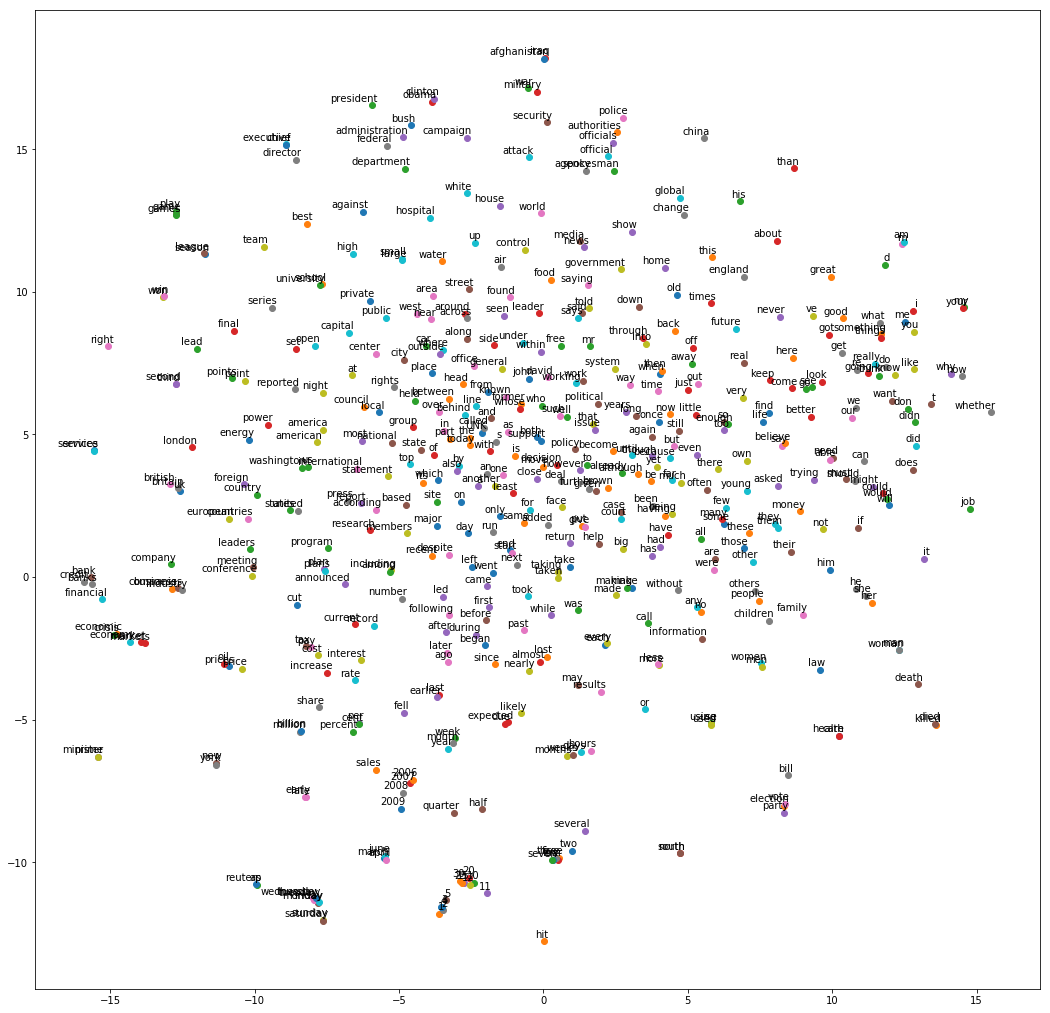

In [51]:
# Step 6: embeddings 시각화

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))        # in inches

    # 원본 코드.
    # 해당 좌표에 점을 표시하고, 오른쪽/하단 정렬로 단어를 표시한다.
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i]

        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    # 재구성한 코드
    # for (x, y), label in zip(low_dim_embs, labels):
    #     plt.scatter(x, y)
    #     plt.annotate(label,
    #                  xy=(x, y),
    #                  xytext=(5, 2),
    #                  textcoords='offset points',
    #                  ha='right',
    #                  va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    # low_dim_embs 내부 갯수와 n_components가 같아야 한다.
    # n_components : 차원. default는 2.
    # perplexity : 가장 가까운 이웃 갯수. 보통 5~50. default는 30.
    # n_iter : 최적화에 사용할 반복 횟수. 최소 200. default는 1000.
    # init : embedding 초기화 방법. random과 pca 중에서 선택. pca가 보다 안정적. default는 random.
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

    # plot 갯수. 50000개의 embeddings로부터 앞쪽 일부만 사용.
    # low_dim_embs에는 변환된 좌표 x, y가 들어있다.
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only])     # (500, 2)
    labels = ordered_words[:plot_only]                                  # 재구성한 코드
    # labels = [ordered_words[i] for i in range(plot_only)]             # 원본 코드

    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')


In [38]:
final_embeddings

array([[ 0.01115685,  0.00253082,  0.00619008, ...,  0.00368692,
        -0.00252634,  0.00234044],
       [ 0.11355725, -0.07965254, -0.18667764, ..., -0.12660749,
        -0.1098489 , -0.05313366],
       [-0.2317457 , -0.07731321,  0.10488008, ..., -0.10126606,
        -0.07162141, -0.24089656],
       ..., 
       [-0.00867069, -0.01060405, -0.03294336, ..., -0.01196832,
         0.00566547, -0.01789871],
       [-0.01498106, -0.01406125, -0.01793183, ..., -0.01529318,
         0.00841022, -0.0207373 ],
       [-0.0026319 , -0.01204085, -0.01788645, ..., -0.01634179,
         0.01431327, -0.01602509]])

## Softmax Algorithm

In [173]:
def create_mini_batch_softmax(int_voc, batch_size, window_size, data_index, sentence_index):
    """
    Create a mini batch of (target word, context word) for training
    
    Arguments:
    int_voc -- a list of vocabulary that is mapped into integer-valued index
    batch_size -- size of batch in stochastic gradient descent # will be 1 
    window_size -- size of window around the target word.
    data_index -- the index of the target word
    sentence_index -- will be implemented if the data set is changed.
    
    Returns:
    batch --  an integer of the index of the target word
    labels -- a numpy array of the index of the context word
    data_index -- the next index of the target word
    """
    data_index = data_index % len(int_voc)
    int_voc = int_voc # this will deleted if the input includes punctuation
    
    batch = np.ndarray(shape=(), dtype=np.int32)
    
    # start index and the end index of windows 
    start = max(0, data_index - window_size)
    end = min(data_index + window_size, len(int_voc)-1)
    num_range = list(range(start, data_index)) + list(range(data_index + 1, end+1))
    
    labels = np.ndarray(shape=(len(num_range)), dtype=np.int32)
    batch = data[data_index]

    for i, index in enumerate(num_range): # may need change
        labels[i] = data[index]
    
    data_index = (data_index + 1) % len(int_voc) # need to be changed if the data set is changed
    
    return batch, labels, data_index

In [174]:
batch, labels, data_index = create_mini_batch_softmax(data, batch_size=1, window_size=3, data_index=3, sentence_index=0)
print(data_index)
for i in range(len(labels)):
    print('{} {} -> {} {}'.format(batch,     ordered_words[batch],
                                  labels[i], ordered_words[labels[i]]))

4
6 a -> 5234 anarchism
6 a -> 3081 originated
6 a -> 12 as
6 a -> 195 term
6 a -> 2 of
6 a -> 3134 abuse


In [175]:
def softmax(x):
    """
    Arguments:
    x -- input of (n, ) 
    
    Returns:
    softmax(x) -- the value of softmax
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [198]:
def feed_forward_softmax(batch, labels, parameters):

    cache = {}
    loss = 0
    W_in = parameters["W_in"]
    W_out = parameters["W_out"]
    nb_classes = W_in.shape[0]
    targets = np.array([labels]).reshape(-1)
    context = np.eye(nb_classes)[targets]
    
    targets_batch = np.array([batch]).reshape(-1)
    batch_one_hot = np.eye(nb_classes)[targets_batch].reshape(W_in.shape[0],)
    
    
    hidden = W_in.T[:,batch]
    u = np.dot(W_out.T, hidden)
    y_pred = softmax(u)
    
    cache['batch_one_hot'] = batch_one_hot
    cache['hidden'] = hidden
    cache['context'] = context
    cache['u'] = u
    cache['y_pred'] = y_pred
    
    
    loss += -np.sum([u[label == 1] for label in context]) + len(context) * np.log(np.sum(np.exp(u)))
    
    return loss, cache

In [199]:
def backpropagation_softmax(batch, labels, cache, parameters,  learning_rate=0.01):
    """
    calculates the backpropagation and updates the parameters 
    
    Arguments:
    batch -- a numpy array containing the index of the batch
    labels -- a numpy array containing the index of the label
    parameters -- a python dictonary containing numpy array parameters that are needed to be updated.
                   -- W_in, shape of (vocabulary_size, projection_size) 
                   -- W_out, shape of (projection_size, vocabulary_size)
    learning rate -- an integer, learning rate used when updating parameters
    
    Returns:
    parameters -- a python dictionary containing updated parameters containing W_in and W_out
    """
    W_in = parameters['W_in']
    W_out = parameters['W_out']
    
    batch_one_hot = cache['batch_one_hot']
    hidden = cache['hidden']
    context = cache['context']
    u = cache['u']
    y_pred = cache['y_pred']
    
    e = np.array([-label + y_pred.T for label in context])
    grads_out = np.outer(hidden, np.sum(e, axis=0))
    grads_in = np.outer(batch_one_hot, np.dot(W_out, np.sum(e, axis=0).T))
    
    # update should be done at the same time 
    W_in = W_in - learning_rate * grads_in
    W_out = W_out - learning_rate * grads_out
    
    return parameters

In [200]:
p = parameter_initialization(50000,300)
a, cache = feed_forward_softmax(batch,labels, parameters=p)
backpropagation_softmax(batch,labels,  cache, p )

{'W_in': array([[  1.11568467e-02,   2.53081640e-03,   6.19008252e-03, ...,
           3.68692280e-03,  -2.52633748e-03,   2.34043893e-03],
        [ -8.26320135e-03,   1.04869392e-02,  -7.47335040e-04, ...,
          -1.37073018e-03,  -5.88282626e-03,  -1.12949659e-03],
        [ -9.80577616e-03,   2.63935597e-03,  -5.97271076e-03, ...,
          -9.74985479e-03,   1.64085818e-02,  -2.55532459e-03],
        ..., 
        [ -2.19485665e-03,   6.57246923e-03,  -7.49900933e-03, ...,
           1.66020262e-05,  -7.47040740e-03,  -5.18476448e-03],
        [ -1.79777639e-03,   8.04854758e-03,   1.96896788e-04, ...,
          -6.88465556e-03,  -4.25835517e-03,   5.65751272e-03],
        [  3.44435370e-03,   3.26132421e-03,   1.21159200e-04, ...,
           3.40641598e-03,   4.22253571e-03,   9.19264935e-03]]),
 'W_out': array([[-0.04148528,  0.11805329,  0.13869866, ...,  0.07064317,
          0.01292566, -0.01193744],
        [-0.06620975, -0.07011239,  0.0812018 , ..., -0.0188462 ,
       

In [209]:
def train_softmax(vocabulary, projection_size, vocabulary_size, epoch, training_time, learning_rate):
    """
    Arguments:
    vocabularary -- a list of data set
    projection_size -- the projection size of a neural network
    vocabulary_size -- used to limit the size of vocabulary 
    epoch -- number of epoches in training the network
    training time -- number of iterations in each epoch -- 구현이 끝나면 빼야한다.
    learning rate -- learning rate used when updating parameters
    
    Returns:
    parameters -- a python dictionary containg trained parameters W_in and W_out
    """
    parameters = parameter_initialization(vocabulary_size, projection_size)
  #  data, ordered_words, most_frequent_n_words = word_numbering(vocabulary, vocabulary_size)

    for j in range(epoch):
        data_index = 0
        
        for i in range(training_time):
            batch, labels, data_index = create_mini_batch_softmax(data, batch_size=1, window_size=1, data_index=data_index,
                                                          sentence_index=0)
            cost, cache = feed_forward_softmax(batch,labels, parameters)
            # learning_rate = learning_rate / (1 + 0.01* epcoh_num) 
            parameters = backpropagation_softmax(batch, labels, cache, parameters, learning_rate)

            if i % 100 == 0:
                print("The cost at:", i,"th iteration is",cost)

    return parameters

In [211]:
parameters_softmax=train_softmax(vocabulary, 300, 50000, 1, 1000, 0.1) # parameters=train(vocabulary, 300, 50000, 3, 17000000, 0.1) 

The cost at: 0 th iteration is 10.8062823333
The cost at: 100 th iteration is 21.6366157521
The cost at: 200 th iteration is 21.6387093212
The cost at: 300 th iteration is 21.6370602035
The cost at: 400 th iteration is 21.6732385735
The cost at: 500 th iteration is 21.6458269024
The cost at: 600 th iteration is 21.6340596056
The cost at: 700 th iteration is 21.6562124105
The cost at: 800 th iteration is 21.6507764171
The cost at: 900 th iteration is 21.6313260139


## Hierarchical Softmax

In [5]:
vocabulary_size = 50000

In [24]:
def sigmoid_hs(z):
    """
    sigmoid function
    
    Arguments:
    Z -- a numpy array of any shape
    
    Returns:
    sig -- a numpy array of sigmoid(z)
    """
    
    sig = 1/(1 + np.exp(-z))
    
    return sig

In [25]:
# 기존의 create_mini_batch_softmax와 동일한 함수입니다.
def create_mini_batch_Hierarchical(int_voc, batch_size, window_size, data_index, sentence_index):
    """
    Create a mini batch of (target word, context word) for training
    
    Arguments:
    int_voc -- a list of vocabulary that is mapped into integer-valued index
    batch_size -- size of batch in stochastic gradient descent # will be 1 
    window_size -- size of window around the target word.
    data_index -- the index of the target word
    sentence_index -- will be implemented if the data set is changed.
    
    Returns:
    batch --  an integer of the index of the target word
    labels -- a numpy array of the index of the context word
    data_index -- the next index of the target word
    """
    data_index = data_index % len(int_voc)
    int_voc = int_voc # this will deleted if the input includes punctuation
    
    batch = np.ndarray(shape=(), dtype=np.int32)
    
    # start index and the end index of windows 
    start = max(0, data_index - window_size)
    end = min(data_index + window_size, len(int_voc)-1)
    num_range = list(range(start, data_index)) + list(range(data_index + 1, end+1))
    
    labels = np.ndarray(shape=(len(num_range)), dtype=np.int32)
    batch = data[data_index]

    for i, index in enumerate(num_range): # may need change
        labels[i] = data[index]
    
    data_index = (data_index + 1) % len(int_voc) # need to be changed if the data set is changed
    
    return batch, labels, data_index

In [26]:
batch, labels, data_index = create_mini_batch_Hierarchical(data, batch_size=1, window_size=3, data_index=3, sentence_index=0)
print(data_index)
for i in range(len(labels)):
    print('{} {} -> {} {}'.format(batch,     ordered_words[batch],
                                  labels[i], ordered_words[labels[i]]))

4
6 a -> 5234 anarchism
6 a -> 3081 originated
6 a -> 12 as
6 a -> 195 term
6 a -> 2 of
6 a -> 3134 abuse


In [27]:
import queue

class HuffmanNode(object):
    def __init__(self, left=None, right=None):
        self.left = left
        self.right = right
        self.weight = np.random.randn(300,) *  np.sqrt(2 /50000)
    def children(self):
        return((self.left, self.right))
    def __eq__(self, a):
        return 1

freq = [(t[1], t[0]) for t in most_frequent_n_words]
def create_tree(frequencies):
    p = queue.PriorityQueue()
    for value in frequencies:    # 1. Create a leaf node for each symbol
        p.put(value)             #    and add it to the priority queue
    while p.qsize() > 1:         # 2. While there is more than one node
        l, r = p.get(), p.get()  # 2a. remove two highest nodes
        node = HuffmanNode(l, r) # 2b. create internal node with children
        p.put((l[0]+r[0], node)) # 2c. add new node to queue      
    return p.get()               # 3. tree is complete - return root node

node = create_tree(freq)
print(node)

# Recursively walk the tree down to the leaves,
#   assigning a code value to each symbol
def walk_tree(node, prefix="", code={}):
    if isinstance(node[1].left[1], HuffmanNode):
        walk_tree(node[1].left,prefix+"0", code)
    else:
        code[node[1].left[1]]=prefix+"0"
    if isinstance(node[1].right[1],HuffmanNode):
        walk_tree(node[1].right,prefix+"1", code)
    else:
        code[node[1].right[1]]=prefix+"1"
    return(code)


    
    
code = walk_tree(node)
for i in sorted(freq, reverse=True):
    print(i[1], '{:6.2f}'.format(i[0]), code[i[1]])

(17005207, <__main__.HuffmanNode object at 0x1864996198>)
the 1061396.00 1001
of 593677.00 10111
UNK 418391.00 00101
and 416629.00 00100
one 411764.00 00010
in 372201.00 111100
a 325873.00 110101
to 316376.00 110011
zero 264975.00 100010
nine 250430.00 011101
two 192644.00 1111110
is 183153.00 1110111
as 131815.00 1000011
eight 125285.00 0111100
for 118445.00 0110001
s 116710.00 0101110
five 115789.00 0101100
three 114775.00 0101001
was 112807.00 0100110
by 111831.00 0100011
that 109510.00 0011111
four 108182.00 0011100
six 102145.00 0001100
seven 99683.00 0000011
with 95603.00 11111010
on 91250.00 11101100
are 76527.00 11000100
it 73334.00 10110011
from 72871.00 10110001
or 68945.00 10100101
his 62603.00 01110011
an 61925.00 01110000
be 61281.00 01101100
this 58832.00 01011111
which 54788.00 01000001
at 54576.00 00111101
he 53573.00 00110110
also 44358.00 111001110
not 44033.00 111001011
have 39712.00 110100000
were 39086.00 110010010
has 37866.00 110000011
but 35358.00 101010110
othe

japanese 3437.00 010000101110
design 3437.00 010000101101
available 3435.00 010000101001
chinese 3430.00 010000100010
forms 3429.00 010000100001
canada 3428.00 010000100000
northern 3423.00 010000000111
died 3418.00 010000000100
class 3412.00 010000000000
living 3410.00 001111001111
next 3406.00 001111001010
particular 3404.00 001111001000
program 3403.00 001111000111
council 3401.00 001111000101
television 3395.00 001111000000
head 3376.00 001110101100
david 3368.00 001110100101
china 3365.00 001110100100
middle 3363.00 001110100010
established 3360.00 001101111110
hand 3356.00 001101111010
bc 3356.00 001101111001
far 3352.00 001101110101
july 3333.00 001101010010
function 3330.00 001101010001
position 3318.00 001100110110
y 3311.00 001100110001
built 3310.00 001100101111
george 3307.00 001100101101
band 3304.00 001100101010
together 3303.00 001100101000
w 3301.00 001100100101
latin 3290.00 001100011001
thought 3277.00 000111111111
eastern 3276.00 000111111110
charles 3268.00 00011111

response 1563.00 0000100101110
temperature 1562.00 0000100101011
sexual 1560.00 0000100011001
faith 1559.00 0000100011000
comes 1559.00 0000100010111
paper 1558.00 0000100010101
environment 1558.00 0000100010010
climate 1556.00 0000100010000
daughter 1555.00 0000100000100
carbon 1555.00 0000010111101
electric 1553.00 0000010111011
www 1552.00 0000010111000
station 1551.00 0000010101100
ad 1550.00 0000010100111
speech 1549.00 0000010100110
sex 1549.00 0000010100011
ship 1548.00 0000010100001
evolution 1544.00 0000010000110
martin 1543.00 0000010000001
microsoft 1539.00 0000001101010
noted 1538.00 0000001101001
usa 1537.00 0000001100011
via 1535.00 0000000111000
supported 1535.00 0000000110001
industrial 1533.00 0000000100110
feature 1531.00 0000000011111
border 1531.00 0000000011110
christianity 1528.00 0000000010110
treatment 1527.00 0000000010001
motion 1525.00 11111111111110
management 1523.00 11111111110101
computers 1523.00 11111111110100
performed 1522.00 11111111101101
summer 152

bodies 1007.00 10000000110100
census 1006.00 10000000101101
think 1005.00 10000000100111
lists 1005.00 10000000100110
glass 1004.00 10000000011100
vice 1003.00 10000000011000
pages 1003.00 10000000010011
organized 1003.00 10000000010010
murder 1003.00 10000000010001
angeles 1003.00 10000000010000
movements 1002.00 10000000000111
bush 1001.00 10000000000101
cultures 1000.00 01111111110101
roughly 999.00 01111111101011
respect 999.00 01111111101010
meeting 999.00 01111111101101
stand 998.00 01111111011010
fictional 997.00 01111111010101
condition 996.00 01111111001101
interpretation 992.00 01111110100100
fantasy 992.00 01111110000011
questions 990.00 01111101100000
policies 990.00 01111101100011
historians 990.00 01111101011101
display 989.00 01111101011100
copyright 989.00 01111101011011
maintain 988.00 01111101000110
lee 988.00 01111101000010
founder 988.00 01111101000001
mode 987.00 01111100100101
positions 986.00 01111100100000
import 986.00 01111100100100
fame 986.00 01111100100010


roots 728.00 111101011101111
heard 728.00 111101011101110
concerned 728.00 111101011111101
temperatures 727.00 111101011100000
stands 727.00 111101011011111
matters 727.00 111101011011110
historic 727.00 111101011100101
dvd 727.00 111101011100100
coup 727.00 111101011100011
cape 727.00 111101011100010
underground 726.00 111101011001110
attributed 726.00 111101011001011
clock 725.00 111101011000010
apparent 725.00 111101011001010
rapid 724.00 111101010101000
officials 724.00 111101010101100
instruction 724.00 111101010110110
georgia 724.00 111101010110000
youth 723.00 111101010100000
graphics 723.00 111101010011101
broken 723.00 111101010011100
prices 722.00 111101010001100
carl 722.00 111101010001111
broke 722.00 111101010001110
treated 721.00 111101010000000
residents 721.00 111101001010111
score 720.00 111101000101010
nearby 720.00 111101000111011
kg 720.00 111101000111010
else 719.00 111101000010010
consciousness 719.00 111101000001011
patterns 718.00 111101000000101
identical 718.0

dropped 634.00 110100111010100
ben 634.00 110100111011000
batman 634.00 110100111011101
manchester 633.00 110100111000110
laureate 633.00 110100111010000
launch 632.00 110100110111010
desire 632.00 110100110101101
colleges 631.00 110100110010000
coastal 631.00 110100101110111
amongst 631.00 110100101110110
colors 630.00 110100101101101
bruce 630.00 110100101101100
baltic 630.00 110100101101011
wrong 629.00 110100101010110
douglas 629.00 110100101010011
argentina 629.00 110100101010010
skills 628.00 110100100100010
pdf 628.00 110100100110101
moves 628.00 110100100110111
mouth 628.00 110100100011101
mississippi 628.00 110100100011110
garden 628.00 110100100101111
alexandria 628.00 110100100110001
transmission 627.00 110100100011100
roles 627.00 110100100010111
ohio 627.00 110100100010110
heritage 627.00 110100100010011
greeks 627.00 110100100010010
gnu 627.00 110100100010101
forming 627.00 110100100010100
diseases 627.00 110100100000111
statements 626.00 110100100000110
norwegian 626.00 

infrastructure 496.00 011111100100011
houston 496.00 011111100101001
geographic 496.00 011111101011011
genes 496.00 011111101011000
surviving 495.00 011111011000100
les 495.00 011111011000011
draft 495.00 011111011000010
commerce 495.00 011111010110101
structural 494.00 011111010000000
sixth 494.00 011111010010011
separation 494.00 011111010110100
sam 494.00 011111010010111
missions 494.00 011111010010110
gates 494.00 011111010001001
fled 494.00 011111010000111
disambiguation 494.00 011111010001000
diet 494.00 011111010010010
connections 494.00 011111010001011
boeing 494.00 011111010010101
atlanta 494.00 011111010001010
varieties 493.00 011111001000011
strictly 493.00 011111001000010
pollution 493.00 011111001000111
minnesota 493.00 011111001000110
cricket 493.00 011110111101001
supports 492.00 011110111011000
statue 492.00 011110111001010
slowly 492.00 011110111010100
newspapers 492.00 011110111001111
millions 492.00 011110111011111
isaac 492.00 011110111010001
experiences 492.00 0111

semitic 400.00 000110101010101
mammals 400.00 000110101010111
heroes 400.00 000011111110111
dimensions 400.00 000011111111001
corner 400.00 000011111110010
coat 400.00 000011111010111
wilhelm 399.00 000011111010110
truly 399.00 000011111010011
revenue 399.00 000011111010010
nationality 399.00 000011100110011
maryland 399.00 000011100110010
latest 399.00 000011100110111
governed 399.00 000011100110110
eternal 399.00 000011100110101
decimal 399.00 000011100110100
costa 399.00 000011111010001
competitive 399.00 000011111010000
bulk 399.00 000011100111111
austin 399.00 000011100111001
abolished 399.00 000011100111000
trinity 398.00 000011100010100
shore 398.00 000011100011101
looked 398.00 000011100011100
lieutenant 398.00 000011100000001
jimmy 398.00 000011100000000
grade 398.00 000011100010110
governors 398.00 000011100001111
formats 398.00 000011100011110
dot 398.00 000011100001110
clinical 398.00 000011100000101
businesses 398.00 000011100000100
ascii 398.00 000011100001000
arc 398.00 

rely 335.00 1110000111111111
interval 335.00 1110000111111110
humor 335.00 1110001000000101
honey 335.00 1110001000000100
harold 335.00 1110001000001011
finish 335.00 1110001000001010
editing 335.00 1110001000000111
consecutive 335.00 1110001000000110
completion 335.00 1110001000001101
accomplished 335.00 1110001000001100
zeus 334.00 1110000110001101
worn 334.00 1110000111000001
thrown 334.00 1110000110000011
stating 334.00 1110000111000000
relatives 334.00 1110000110000010
nicholas 334.00 1110000111000111
nazis 334.00 1110000110000001
kick 334.00 1110000111011110
gift 334.00 1110000111000011
flowers 334.00 1110000110000000
entrance 334.00 1110000101101111
eighth 334.00 1110000110001011
backed 334.00 1110000111000100
technological 333.00 1110000101001110
supposedly 333.00 1110000101010101
samples 333.00 1110000101010100
oswald 333.00 1110000101010001
organ 333.00 1110000100101111
lane 333.00 1110000100101110
golf 333.00 1110000101010000
fate 333.00 1110000101001011
enterprise 333.00 11

considers 299.00 1100010100111010
worse 298.00 1100001101101111
throw 298.00 1100001101111001
suspected 298.00 1100001110101101
stick 298.00 1100001110101100
shipping 298.00 1100001101100001
plasma 298.00 1100001101100111
placing 298.00 1100001101110001
mice 298.00 1100001101100110
malta 298.00 1100001101110000
icon 298.00 1100001101110111
greenland 298.00 1100001101110110
determining 298.00 1100001101101001
customer 298.00 1100001101101000
coastline 298.00 1100001101100011
atmospheric 298.00 1100001101100010
assist 298.00 1100001110110101
amd 298.00 1100001110110100
ada 298.00 1100001101110011
wise 297.00 1100001011000011
whenever 297.00 1100001011000010
websites 297.00 1100001100001001
trilogy 297.00 1100001100001000
supplied 297.00 1100001011011111
rounds 297.00 1100001011011110
pearl 297.00 1100001011011001
monument 297.00 1100001011011000
meets 297.00 1100001011011101
insects 297.00 1100001011011100
cola 297.00 1100001011011011
bowie 297.00 1100001011011010
sessions 296.00 1100001

firearms 251.00 1000000001100101
equivalence 251.00 1000000001100100
ear 251.00 1000000001111011
dense 251.00 1000000001111010
colours 251.00 1000000000011001
whereby 250.00 0111111111001000
traveling 250.00 1000000000001001
thatcher 250.00 0111111110111101
temporarily 250.00 0111111111011111
specifications 250.00 1000000000011000
soundtrack 250.00 0111111111011110
simplified 250.00 0111111111010010
saturn 250.00 0111111110111001
renewed 250.00 1000000000001111
profits 250.00 1000000000001000
mozambique 250.00 0111111111001111
mongol 250.00 0111111110111000
lsd 250.00 0111111110111011
forgotten 250.00 0111111110111010
filed 250.00 0111111111011001
eisenhower 250.00 0111111111011000
attraction 250.00 0111111101101101
telling 249.00 0111111100111101
revenge 249.00 0111111100111100
resort 249.00 0111111100011001
registers 249.00 0111111100011000
provisional 249.00 0111111100011011
pink 249.00 0111111100011010
nervous 249.00 0111111100111111
forums 249.00 0111111100111110
counted 249.00 01

versa 222.00 0100111100110011
temperate 222.00 0100111100110010
somewhere 222.00 0100111101000001
sins 222.00 0100111101001001
shut 222.00 0100111101000000
schemes 222.00 0100111101000011
prosperity 222.00 0100111101000010
proposals 222.00 0100111100101011
playoff 222.00 0100111100101000
nt 222.00 0100111100101010
mauritius 222.00 0100111011100111
luthor 222.00 0100111101011111
kinetic 222.00 0100111101011110
innocent 222.00 0100111011100110
imprisonment 222.00 0100111101011101
eleanor 222.00 0100111101110011
dominate 222.00 0100111101110010
coronation 222.00 0100111100100111
calculate 222.00 0100111100100110
boiling 222.00 0100111100010011
angry 222.00 0100111100010010
acronym 222.00 0100111100011101
theatrical 221.00 0100111010000101
tenth 221.00 0100111010000100
suspension 221.00 0100111010000001
snake 221.00 0100111010000000
searching 221.00 0100111000111001
saul 221.00 0100111000111000
rotating 221.00 0100111010101101
rna 221.00 0100111010101100
rebuilt 221.00 0100111010001111
rea

soup 201.00 0001101111001001
roberts 201.00 0001101111001000
printer 201.00 0001101111010111
pierce 201.00 0001101111010110
oz 201.00 0001110000011000
madagascar 201.00 0001101111010101
enforced 201.00 0001101111010100
displaced 201.00 0001101111011001
diplomat 201.00 0001101111011000
dewey 201.00 0001101111000111
defeats 201.00 0001101111000110
coral 201.00 0001101111001011
beverages 201.00 0001101111001010
atoll 201.00 0001101111011101
assumes 201.00 0001101111011100
airplane 201.00 0001101111011111
aired 201.00 0001101111011110
affects 201.00 0001110000000011
aerial 201.00 0001110000000010
admission 201.00 0001101100101101
visits 200.00 0001101001111101
skating 200.00 0000111111100110
shortened 200.00 0001101001100001
recreational 200.00 0001101001101101
pyramid 200.00 0001101001100100
punch 200.00 0001101010000110
principally 200.00 0001101011000011
pregnancy 200.00 0001101010110111
pg 200.00 0001101010110110
numbering 200.00 0001101010110101
meal 200.00 0001101001100000
md 200.00 

selective 183.00 11110110110010001
rider 183.00 11110110110010000
responsibilities 183.00 11110110110010101
reception 183.00 11110110110010100
priesthood 183.00 11110111000000011
preparing 183.00 11110111000000010
perceive 183.00 11110110110010111
participating 183.00 11110110110010110
nomenclature 183.00 11110110110011101
marginal 183.00 11110110110011100
margin 183.00 11110110011000111
loch 183.00 11110110011000110
listen 183.00 11110110110011111
honda 183.00 11110110110011110
hadrian 183.00 11110110101110001
habit 183.00 11110110101110000
generator 183.00 11110110110011011
fierce 183.00 11110110110011010
fatty 183.00 11110110110010011
dover 183.00 11110110110010010
deliberate 183.00 11110110110000101
cure 183.00 11110110110000100
crashes 183.00 11110110101110011
compressed 183.00 11110110101110010
compensation 183.00 11110111000000001
butt 183.00 11110111000000000
authentic 183.00 11110110101111001
atheist 183.00 11110110101111000
arable 183.00 11110111000000111
amos 183.00 11110111

ezra 163.00 11011101101001001
eighty 163.00 11011101101001000
dayton 163.00 11011101101011001
corrupt 163.00 11011101101011000
chopin 163.00 11011101101100101
cayman 163.00 11011101101100100
catalonia 163.00 11011101101101011
burst 163.00 11011101101101010
beginnings 163.00 11011101101101001
batter 163.00 11011101101101000
atta 163.00 11011101101110111
assignment 163.00 11011101101110110
arrives 163.00 11011101101100111
adrian 163.00 11011101101100110
abdul 163.00 11011101011001101
variously 162.00 11011100100101110
translate 162.00 11011101011001100
tanakh 162.00 11011100101011011
surplus 162.00 11011100100011101
storyline 162.00 11011100100011100
spell 162.00 11011100100101101
ryan 162.00 11011100101011010
resign 162.00 11011100110000101
pseudonym 162.00 11011100100101100
proton 162.00 11011100100110001
preserving 162.00 11011100110000100
petition 162.00 11011100101000110
parallels 162.00 11011100100011111
nuremberg 162.00 11011100100111010
nickel 162.00 11011100100110000
ml 162.00 1

suspect 150.00 11000101111001100
suits 150.00 11000101110101111
suburb 150.00 11000110010101001
substitution 150.00 11000110010101000
speculative 150.00 11000101110011111
semantics 150.00 11000101110011110
scrooge 150.00 11000101110011101
sartre 150.00 11000101110011100
reynolds 150.00 11000101110110101
rahman 150.00 11000101110110100
punished 150.00 11000101110010101
placement 150.00 11000101110010100
owns 150.00 11000101101111001
mentally 150.00 11000101110111011
mathbb 150.00 11000101101111000
matching 150.00 11000101110010011
mandelbrot 150.00 11000101110010010
liberties 150.00 11000101111001011
laying 150.00 11000101111001010
jam 150.00 11000101110110011
inevitable 150.00 11000101110110010
hypoglycemia 150.00 11000101111001001
hbo 150.00 11000101111001000
hastings 150.00 11000101110101011
grande 150.00 11000101110101010
gel 150.00 11000101101100111
freezing 150.00 11000101101100110
encyclop 150.00 11000101110101101
distortion 150.00 11000101110101100
dipole 150.00 1100010110111111

tips 139.00 10101101001010001
sorting 139.00 10101101001010000
slam 139.00 10101100101001101
skiing 139.00 10101100101001100
schism 139.00 10101100101100111
recommendations 139.00 10101100101100110
publishes 139.00 10101100101011001
prevalence 139.00 10101100101011000
prefecture 139.00 10101100101001011
predicate 139.00 10101100101001010
practicing 139.00 10101100100101111
pays 139.00 10101100100101110
outward 139.00 10101100110100011
obey 139.00 10101100110100010
nutrition 139.00 10101100101001111
nero 139.00 10101100101001110
nash 139.00 10101100101000111
muscular 139.00 10101100101000110
mo 139.00 10101100110101101
mercenaries 139.00 10101100110101100
lungs 139.00 10101100110100001
lattice 139.00 10101100110100000
jamal 139.00 10101100110100111
hermes 139.00 10101100110100110
guiana 139.00 10101100100101011
expertise 139.00 10101100100101010
deserts 139.00 10101100100101001
demographic 139.00 10101100100101000
deaf 139.00 10101100110100101
convex 139.00 10101100110100100
coherent 13

cardinality 124.00 01111110010010100
cardiff 124.00 01111110101101010
caliphate 124.00 01111111011011000
bordering 124.00 01111110100000010
belarusian 124.00 01111110100001001
bangla 124.00 01111110011001100
astros 124.00 01111110011010100
apr 124.00 01111110000101101
adhere 124.00 01111110011100101
abnormal 124.00 01111110100101011
woodland 123.00 01111011101110101
wedge 123.00 01111011101110100
vertically 123.00 01111011101100101
variance 123.00 01111011101100100
vague 123.00 01111011101011001
undergoing 123.00 01111011101011000
toxicity 123.00 01111011101001111
thorough 123.00 01111011101001110
themed 123.00 01111011101001001
textbooks 123.00 01111011101001000
suspicion 123.00 01111011110000011
surgeon 123.00 01111011110000010
subsidies 123.00 01111011100110101
splitting 123.00 01111011100110100
serpent 123.00 01111011101010111
schopenhauer 123.00 01111011101010110
saskatchewan 123.00 01111011101011011
riders 123.00 01111011101011010
pike 123.00 01111011101101111
perpetual 123.00 01

depressed 111.00 01001111001001011
decrees 111.00 01001111001001010
davy 111.00 01010000000101001
daisy 111.00 01010000000101000
crest 111.00 01001111001101111
creativity 111.00 01001111001101110
connector 111.00 01001111010110101
computed 111.00 01001111010110100
clever 111.00 01001111001011111
caravaggio 111.00 01001111001011110
botanical 111.00 01001111000101011
bohr 111.00 01001111000101010
bentley 111.00 01001111001011101
bbs 111.00 01001111001011100
banana 111.00 01001111001001001
avant 111.00 01001111001001000
ata 111.00 01001110101001001
yin 110.00 01001011100101001
vendor 110.00 01001011100101000
updates 110.00 01001011100010111
tracing 110.00 01001010111001000
touched 110.00 01001011100010110
tenor 110.00 01001011100011101
targeting 110.00 01001011100011100
swan 110.00 01001010110011101
stripes 110.00 01001010110011100
stevens 110.00 01001010101010101
spd 110.00 01001011101000011
separates 110.00 01001011101000010
scroll 110.00 01001010111011111
scout 110.00 01001010111011110

fulham 104.00 00110100110110101
fortifications 104.00 00110100001010110
flour 104.00 00110100010000110
flawed 104.00 00110100110110100
expeditions 104.00 00110100111101011
erich 104.00 00110100111101010
eliot 104.00 00110100110111011
economical 104.00 00110100111101111
duc 104.00 00110100011011101
dispersed 104.00 00110100011011100
darius 104.00 00110100111101110
dams 104.00 00110100000111101
coordinated 104.00 00110100001001011
constructs 104.00 00110100001001010
constructions 104.00 00110100010010001
compile 104.00 00110100110010001
chan 104.00 00110100110010000
categorized 104.00 00110100010010000
budapest 104.00 00110100010000101
besieged 104.00 00110100010000100
benin 104.00 00110100110110011
assemblies 104.00 00110100101110111
aristocracy 104.00 00110100101110110
approve 104.00 00110100110110010
ain 104.00 00110011000010001
zionist 103.00 00110011000010000
walsh 103.00 00110010000001101
voter 103.00 00110010000001100
vinci 103.00 00110010000101101
vaccine 103.00 00110010000101100

vocalist  95.00 111111111000111110
vandals  95.00 111111111001100111
valign  95.00 111111111001100110
urdu  95.00 111111111001000111
unwilling  95.00 111111111001000110
unused  95.00 111111111001010101
unmanned  95.00 111111111001010100
unhappy  95.00 111111111001011101
turmoil  95.00 111111111001011100
ts  95.00 111111111001001111
tre  95.00 111111111001001110
trails  95.00 111111110111100011
tang  95.00 111111110111100010
tags  95.00 111111111000100111
systematically  95.00 111111111000100110
surely  95.00 111111110111100001
steppe  95.00 111111110111100000
southampton  95.00 111111111001101001
shields  95.00 111111111001101000
sheer  95.00 111111111000101111
sensor  95.00 111111111000101110
sasquatch  95.00 111111111001010111
runway  95.00 111111111001010110
rhymes  95.00 111111110111110001
reigning  95.00 111111110111110000
referee  95.00 111111111000100011
questioning  95.00 111111111000100010
psyche  95.00 111111111000101101
prospects  95.00 111111111000101100
profiles  95.00 111

evangelist  88.00 111010010100101100
evacuation  88.00 111010010111001011
eukaryotes  88.00 111010010111001010
erupted  88.00 111010011101011011
engels  88.00 111010011101011010
emil  88.00 111010010111000011
eli  88.00 111010010111000010
electrolysis  88.00 111010010111001101
disappointment  88.00 111010010111001100
disagreements  88.00 111010010111001111
dirt  88.00 111010010111001110
dilbert  88.00 111010011110001101
dictated  88.00 111010011110001100
derogatory  88.00 111010010111000111
daytime  88.00 111010010111000110
davenport  88.00 111010010100010101
conway  88.00 111010010100010100
constance  88.00 111010010111001001
conserved  88.00 111010010111001000
concentrating  88.00 111010010111110111
communicating  88.00 111010010111110110
cn  88.00 111010011101011111
clip  88.00 111010011101011110
citadel  88.00 111010010110111011
chant  88.00 111010010110111010
carboxylic  88.00 111010011101011001
cambodian  88.00 111010011101011000
billions  88.00 111010011110100001
bergson  88.00 

somebody  81.00 110111001010100100
sinclair  81.00 110111001001110011
serb  81.00 110111001001110010
secretaries  81.00 110111001100111001
secretariat  81.00 110111001100111000
resume  81.00 110111001011110011
repetitive  81.00 110111001011110010
relax  81.00 110111001011101111
reichstag  81.00 110111001011101110
recruit  81.00 110111001010001011
rappers  81.00 110111001010001010
rafael  81.00 110111001010111101
quincy  81.00 110111001010111100
proposing  81.00 110111001010010011
privileged  81.00 110111001010010010
popes  81.00 110111001011101011
pollen  81.00 110111001011101010
phd  81.00 110111001010010111
pending  81.00 110111001010010110
parliaments  81.00 110111001011101001
pablo  81.00 110111001011101000
operatorname  81.00 110111001100010011
nutritional  81.00 110111001100010010
narcotics  81.00 110111000111111001
muay  81.00 110111000111111000
mourning  81.00 110111001000010011
modifying  81.00 110111001000010010
mn  81.00 110111001000010001
militarily  81.00 11011100100001000

infocom  77.00 110010101101001010
indictment  77.00 110010101100101111
impressions  77.00 110010101100101110
hoyle  77.00 110010101101010011
hiroshima  77.00 110010101101010010
heavyweight  77.00 110010101011011101
hats  77.00 110010101011011100
hammett  77.00 110010101011001011
globally  77.00 110010101011001010
gentiles  77.00 110010110000001111
gdynia  77.00 110010110000001110
gba  77.00 110010101010010001
gael  77.00 110010101010010000
frodo  77.00 110010101011000001
freeware  77.00 110010101011000000
forthcoming  77.00 110010100111101011
fin  77.00 110010100111101010
fermat  77.00 110010101101101111
excavated  77.00 110010101101101110
euphoria  77.00 110010110000101101
enki  77.00 110010110000101100
emitting  77.00 110010101101011111
electrode  77.00 110010101101011110
ducati  77.00 110010110000100101
donna  77.00 110010110000100100
donkey  77.00 110010101101110101
dodge  77.00 110010101101110100
dio  77.00 110010101011111111
depletion  77.00 110010101011111110
deepest  77.00 1100

telugu  71.00 101100000110111111
td  71.00 101100000110111110
taoism  71.00 101100000011011011
taoiseach  71.00 101100000011011010
swimmer  71.00 101100000011101001
sunshine  71.00 101100000011101000
stealth  71.00 101100000111011100
stairs  71.00 101100000101111011
spyware  71.00 101100000101111010
spokesman  71.00 101100000001101001
splits  71.00 101100000001101000
spiders  71.00 101011111110001111
smuggling  71.00 101011111110001110
silesia  71.00 101100000101011001
shine  71.00 101100000101011000
sanction  71.00 101100000001110111
ryu  71.00 101100000001110110
rv  71.00 101100000111010101
royals  71.00 101100000111010100
rosetta  71.00 101100000001101011
romanticism  71.00 101100000001101010
revisited  71.00 101100000110000011
restructuring  71.00 101100000110000010
resin  71.00 101100000011100011
replicating  71.00 101100000011100010
regency  71.00 101100000101101111
reconstructionist  71.00 101100000101101110
rationale  71.00 101100000001110101
rails  71.00 101100000001110100
pse

damon  66.00 101000010101000110
daimler  66.00 101000010101101101
cymbal  66.00 101000010101010011
crafts  66.00 101000010101010010
consultative  66.00 101000010101101100
connectors  66.00 101000010001100001
concurrently  66.00 101000010001100000
cleaned  66.00 101000010011001011
cereals  66.00 101000010011001010
cathars  66.00 101000010101000101
cappella  66.00 101000010101000100
cadmium  66.00 101000010011101001
brighton  66.00 101000010011101000
bodhisattva  66.00 101000010110001001
bernini  66.00 101000010110001000
bargaining  66.00 101000010100000011
badminton  66.00 101000010100000010
assyrians  66.00 101000010101111111
assistants  66.00 101000010101111110
assigning  66.00 101000010110101101
arnaz  66.00 101000010110010001
arbitrage  66.00 101000010110010000
appointing  66.00 101000010110101100
anticipation  66.00 101000010110000111
anthropic  66.00 101000010110000110
anschluss  66.00 101000010001101001
annihilation  66.00 101000010010011001
ames  66.00 101000010001101000
alaric 

stokes  62.00 011111100001111010
stir  62.00 011111101100011111
ssr  62.00 011111101010000001
sounded  62.00 011111100110000110
sizeable  62.00 011111100001011001
shady  62.00 011111100110110111
ser  62.00 011111101010000000
schneider  62.00 011111100111011001
savior  62.00 011111100111011000
reverence  62.00 011111101100000111
respectable  62.00 011111101100000110
rep  62.00 011111101001100111
reginald  62.00 011111101001100110
pythagorean  62.00 011111100101000101
punishable  62.00 011111100101000100
provence  62.00 011111100101100001
protagonists  62.00 011111100001011000
proclaim  62.00 011111101100010001
prevail  62.00 011111101100010000
preferable  62.00 011111101010110001
predates  62.00 011111101010110000
preach  62.00 011111100111100111
pitt  62.00 011111100111100110
piracy  62.00 011111100100100101
pippin  62.00 011111100100100100
phonetics  62.00 011111101000110111
phenomenal  62.00 011111100100100111
patrons  62.00 011111100100100110
pathology  62.00 011111100100111011
pass

spades  59.00 011010010000011111
skeletons  59.00 011010010000011110
sixties  59.00 011010011000110101
sinister  59.00 011010011000110100
silva  59.00 011010010000100011
sibling  59.00 011010010000100010
seljuk  59.00 011010011000101101
sedimentary  59.00 011010011000101100
schliemann  59.00 011010010001101111
scanner  59.00 011010010001101110
saunders  59.00 011010010000111111
sacrificing  59.00 011010010000111110
rw  59.00 011010011000101111
rude  59.00 011010011000101110
rotary  59.00 011010001111101111
ronnie  59.00 011010001111101110
rodgers  59.00 011010010001101101
riley  59.00 011010010001101100
retroflex  59.00 011010001101100111
repudiated  59.00 011010001101100110
repeaters  59.00 011010001100111001
reggae  59.00 011010001100111000
recombination  59.00 011010001100000101
reacting  59.00 011010001100000100
raster  59.00 011010010001101011
radioactivity  59.00 011010010001101010
pulls  59.00 011010001110011101
pubs  59.00 011010001110011100
prowess  59.00 011010001111100101
pr

chiapas  57.00 010110110101101011
chargers  57.00 010110110101101010
cerberus  57.00 010110101110001111
cassandra  57.00 010110101110001110
carmen  57.00 010110101110101001
carboniferous  57.00 010110101110101000
camels  57.00 010110110011011101
buzz  57.00 010110110011011100
brewster  57.00 010110110000001101
brackets  57.00 010110110000001100
blaine  57.00 010110101110001101
bizkit  57.00 010110101110001100
bikini  57.00 010110110010001101
bibles  57.00 010110110010001100
benign  57.00 010110110100000111
beforehand  57.00 010110110100000110
bastille  57.00 010110101110100111
bamberg  57.00 010110101110100110
balances  57.00 010110110100000101
baking  57.00 010110110100000100
avid  57.00 010110110011111011
assure  57.00 010110110011111010
arthropods  57.00 010110110101001111
armada  57.00 010110110101001110
ante  57.00 010110110101100011
anomaly  57.00 010110110101100010
angelo  57.00 010110101110001011
anagram  57.00 010110101110001010
amr  57.00 010110110011111001
amish  57.00 01011

planners  54.00 010001001111011111
pigments  54.00 010001001111011110
piedmont  54.00 010001010000010101
phylogenetic  54.00 010001001110101100
pez  54.00 010001001101100100
perceptual  54.00 010001010000010100
peg  54.00 010001001101011111
pedals  54.00 010001001101011110
pea  54.00 010001001000001011
pauling  54.00 010001001000001010
paranoid  54.00 010001001011110001
otis  54.00 010001001100111011
olaf  54.00 010001001100111010
obstruction  54.00 010001001100011101
nets  54.00 010001001111100001
ned  54.00 010001001011110000
navigate  54.00 010001001100011100
mythic  54.00 010001001011101111
mute  54.00 010001001010001111
murdoch  54.00 010001001111101101
muddy  54.00 010001001010001110
moniker  54.00 010001001100111001
moderated  54.00 010001001100111000
minted  54.00 010001001111100000
minors  54.00 010001010000000101
methodologies  54.00 010001001101100111
memorandum  54.00 010001010000000100
maximal  54.00 010001001101100110
marmite  54.00 010001001111101100
maritimes  54.00 010

mess  51.00 000111101110000110
mellitus  51.00 000111101111001101
mayan  51.00 000111110100010101
masked  51.00 000111101111001100
marrow  51.00 000111110100010100
manasseh  51.00 000111101110000101
malayan  51.00 000111101110000100
mace  51.00 000111101110001001
lust  51.00 000111101110001000
liszt  51.00 000111110100100101
ladino  51.00 000111110100100100
lada  51.00 000111110101101111
kuhn  51.00 000111110101101110
krakatoa  51.00 000111110101100011
klm  51.00 000111110011111001
kayaks  51.00 000111110101100010
kamikaze  51.00 000111110101011101
jonas  51.00 000111110101011100
jiang  51.00 000111101110010011
jaya  51.00 000111101110010010
islamism  51.00 000111101111110011
iom  51.00 000111110011111000
interfering  51.00 000111111000011011
inflammation  51.00 000111111000011010
infanticide  51.00 000111110011111111
incursions  51.00 000111110011111110
igf  51.00 000111101101010111
identifiers  51.00 000111101111110010
hypnotic  51.00 000111110000110001
horrors  51.00 000111101101010

xviii  47.00 1111101111111010111
wooded  47.00 1111101111111010110
wipe  47.00 1111101111111101011
wee  47.00 1111101111111101010
virginity  47.00 1111111000000000011
verifiable  47.00 1111111000000000010
vasco  47.00 1111111000000111011
valuation  47.00 1111111000000111010
vaguely  47.00 1111101111110110001
usgs  47.00 1111101111110110000
ursa  47.00 1111111000100110111
uplands  47.00 1111111000100110110
unstressed  47.00 1111111000000000001
unsafe  47.00 1111111000000000000
unfit  47.00 1111111000011110001
uncertainties  47.00 1111111000011110000
trumpets  47.00 1111111000011111101
trim  47.00 1111111000011111100
townships  47.00 1111111000100110001
thor  47.00 1111111000100110000
thinner  47.00 1111111000110100001
theresa  47.00 1111111000110100000
telegram  47.00 1111111000001101001
teg  47.00 1111111000001101000
taxonomic  47.00 1111111000011100001
systematics  47.00 1111111000011100000
synchronization  47.00 1111111001111011011
superhuman  47.00 1111111001111011010
subatomic  47.

familial  45.00 1111010101010100000
famers  45.00 1111010001111100011
fading  45.00 1111010001111100010
fables  45.00 1111010001101011011
fabius  45.00 1111010001101011010
exploding  45.00 1111010010101101111
expeditionary  45.00 1111010010101101110
evade  45.00 1111010001100101111
estimating  45.00 1111010001100101110
essayist  45.00 1111010010001111011
ess  45.00 1111010010001111010
escalated  45.00 1111010010001000111
environmentally  45.00 1111010010001000110
environmentalism  45.00 1111010001111100001
entertained  45.00 1111010001111100000
entertain  45.00 1111010001010010011
endowment  45.00 1111010001010010010
emergent  45.00 1111010001000001111
electronica  45.00 1111010001000001110
earls  45.00 1111010001101010001
dwarfs  45.00 1111010001101010000
dv  45.00 1111010001010010101
dun  45.00 1111010001010010100
dsp  45.00 1111010001100100001
drummers  45.00 1111010001100100000
dotted  45.00 1111010001010010001
domini  45.00 1111010001010010000
domestication  45.00 1111010001101110

tackled  42.00 1110001001011011011
synoptic  42.00 1110001001011011010
syndication  42.00 1110001001000101011
substrates  42.00 1110001001000101010
stoke  42.00 1110001010011101001
stigma  42.00 1110001001111000011
steamboat  42.00 1110001001111000010
statewide  42.00 1110001010011101000
stat  42.00 1110001010010110001
standardised  42.00 1110001010010110000
staining  42.00 1110001001000011111
stabbed  42.00 1110001001010101111
soto  42.00 1110001001000011110
sorcerer  42.00 1110001010011100011
solitude  42.00 1110001001010101110
solidified  42.00 1110001010011100010
soga  42.00 1110001010001001111
soc  42.00 1110001010001001110
signified  42.00 1110001000111000001
shane  42.00 1110001001011011001
shafts  42.00 1110001001011011000
sgi  42.00 1110001001011010011
seine  42.00 1110001001011010010
sedgwick  42.00 1110001001011101001
secretion  42.00 1110001001011101000
secede  42.00 1110001000111000000
seaports  42.00 1110001010110101101
schiller  42.00 1110001001111001111
sahel  42.00 111

molded  40.00 1101100101101010001
mohawk  40.00 1101100101101010000
mitigate  40.00 1101100111000110011
mira  40.00 1101100111000110010
minsky  40.00 1101100111000011011
minimalism  40.00 1101100111000011010
miner  40.00 1101100111000010111
millsaps  40.00 1101100111000010110
microkernel  40.00 1101101000110101001
mev  40.00 1101101000110101000
metaphorical  40.00 1101101000110111001
metabolites  40.00 1101101000110111000
meditations  40.00 1101100111000110111
medically  40.00 1101100111000110110
medes  40.00 1101101000000001111
medea  40.00 1101101000000001110
mastering  40.00 1101100111110101011
marshals  40.00 1101100111110101010
marseille  40.00 1101101001110010011
marian  40.00 1101101001110010010
marcuse  40.00 1101101000101100111
maniac  40.00 1101101000101100110
malignant  40.00 1101100101001111101
magyar  40.00 1101100101001111100
magnification  40.00 1101101100011000011
lymph  40.00 1101101100011000010
lutheranism  40.00 1101100101001111011
loser  40.00 1101100101001111010
lo

hinges  38.00 1100011110100001111
highlighting  38.00 1100011111101101000
hermit  38.00 1100100001010000001
hemp  38.00 1100100001010000000
helsing  38.00 1100011111111111001
headwaters  38.00 1100011111111111000
headings  38.00 1100100001000111101
hc  38.00 1100100001000111100
hbc  38.00 1100011111011100001
hariri  38.00 1100011111011100000
hammadi  38.00 1100011101101011101
halogens  38.00 1100011101101011100
guez  38.00 1100011111101010011
grenadines  38.00 1100011111101010010
grab  38.00 1100011101011001011
gonz  38.00 1100011101011001010
gloucestershire  38.00 1100011111000100001
geocaching  38.00 1100011111000100000
gc  38.00 1100011101101101101
gamblers  38.00 1100011101101101100
gallienus  38.00 1100011110000110101
galatea  38.00 1100011110000110100
gage  38.00 1100011101101001101
fuerteventura  38.00 1100011101101001100
frequented  38.00 1100011110000111001
footing  38.00 1100011110000111000
flea  38.00 1100011110100001110
figurehead  38.00 1100011101011000011
femme  38.00 110

morrow  36.00 1011010010000011101
montagu  36.00 1011010010000011100
modernize  36.00 1011010100000000111
moab  36.00 1011010010110011001
mixer  36.00 1011010100000000110
mic  36.00 1011010001111110001
meuse  36.00 1011010001111110000
mentality  36.00 1011010011011100101
menger  36.00 1011010011011100100
meade  36.00 1011010100000111101
mauryan  36.00 1011010100000111100
mathews  36.00 1011010001111000111
marduk  36.00 1011010001111000110
mansfield  36.00 1011010010101010001
manichaeism  36.00 1011010010101010000
mancha  36.00 1011010001111110111
malthus  36.00 1011010001111110110
malls  36.00 1011010101110110001
madeleine  36.00 1011010011101000001
macrinus  36.00 1011010011101000000
lugh  36.00 1011010001111001001
longrightarrow  36.00 1011010001111001000
locales  36.00 1011010011100101111
livingston  36.00 1011010011100101110
lis  36.00 1011010001111000101
lineman  36.00 1011010001111000100
liking  36.00 1011010101110110000
levine  36.00 1011010011100100001
lenny  36.00 101101001110

sneak  34.00 1010011110011111111
smoother  34.00 1010011110011111110
situ  34.00 1010011110011010111
signer  34.00 1010011110011010110
shunned  34.00 1010011110111111100
shrunk  34.00 1010100000000011001
shropshire  34.00 1010100000000011000
shrewsbury  34.00 1010100000110010001
shielding  34.00 1010100000110010000
sherwood  34.00 1010011101110100001
serials  34.00 1010011000010000010
sejm  34.00 1010011110100001101
sectional  34.00 1010011101110100000
secretive  34.00 1010011111010001011
sears  34.00 1010011110100001100
scotsman  34.00 1010011110111111001
schwarzschild  34.00 1010011110111111000
scathing  34.00 1010100001000010111
saxe  34.00 1010011111010001010
saddles  34.00 1010100001000010110
rwandan  34.00 1010100000100011011
rupee  34.00 1010100000100011010
rumour  34.00 1010011101101111101
rouen  34.00 1010011101101111100
romanesque  34.00 1010100001000011111
rockabilly  34.00 1010100001000011110
riff  34.00 1010100101101011001
renamo  34.00 1010100101101011000
remixed  34.00 1

dissimilar  33.00 1010000100001001100
disrupting  33.00 1010000110000010101
disclose  33.00 1010000110000010100
diodorus  33.00 1010000011111010101
diaphragm  33.00 1010000011111010100
detriment  33.00 1010000101111111101
derivations  33.00 1010000101111111100
denominational  33.00 1010000101110110001
demography  33.00 1010000101110110000
delle  33.00 1010000101001110011
daniels  33.00 1010000101001110010
danforth  33.00 1010000100010001111
damnation  33.00 1010000100010001110
daemon  33.00 1010000110000010001
cuny  33.00 1010000110000010000
cultivating  33.00 1010000110000001111
croix  33.00 1010000110000001110
crisp  33.00 1010000100000010001
crackers  33.00 1010000100000010000
cough  33.00 1010000101101010111
contradicting  33.00 1010000101101010110
contemplate  33.00 1010000100010111001
constans  33.00 1010000100010111000
conjectured  33.00 1010000101011010001
concede  33.00 1010000101011010000
complicity  33.00 1010000110000010011
compartments  33.00 1010000110000010010
como  33.0

persuading  31.00 0111111010010100110
penultimate  31.00 0111111010011111101
pee  31.00 0111111010011111100
peas  31.00 0111111001111010011
pda  31.00 0111111001111010010
pcr  31.00 0111111010110100011
pathogen  31.00 0111111010110100010
pater  31.00 0111111001111001011
pastry  31.00 0111111001111001010
paschal  31.00 0111111010011111011
participatory  31.00 0111111010011111010
panspermia  31.00 0111111010110100001
paine  31.00 0111111010110100000
padres  31.00 0111111001110000111
packer  31.00 0111111001110000110
oxidase  31.00 0111111011000111001
overwhelm  31.00 0111111011000111000
overran  31.00 0111111010000101001
outcry  31.00 0111111010000101000
oss  31.00 0111111000010001001
orthonormal  31.00 0111111000010001000
oro  31.00 0111111000010001101
orientations  31.00 0111111000010001100
orgasm  31.00 0111111001110100001
oratorio  31.00 0111111001110100000
optimize  31.00 0111111010011111001
opposites  31.00 0111111010011111000
onslaught  31.00 0111111011001001011
occured  31.00 011

emitter  30.00 0110110110000011100
emilia  30.00 0110110110001010111
embody  30.00 0110110110100110011
ely  30.00 0110110110100110010
elegance  30.00 0110111000110001101
ecm  30.00 0110111000110001100
dwindled  30.00 0110111000011101101
drinker  30.00 0110111000011101100
drifted  30.00 0110110111010010101
draco  30.00 0110110111010010100
downside  30.00 0110110101011000101
downloading  30.00 0110110101011000100
doherty  30.00 0110110101110100111
dodger  30.00 0110110101110100110
dit  30.00 0110111000011000101
distraction  30.00 0110111000011000100
dissociative  30.00 0110111000110000011
disprove  30.00 0110111000110000010
discus  30.00 0110110110000011011
diomedes  30.00 0110110110000011010
diacritical  30.00 0110110111010011001
dflp  30.00 0110110111010011000
desperation  30.00 0110110101001000011
desolate  30.00 0110110101001000010
denunciation  30.00 0110110101011000011
denatured  30.00 0110110101011000010
defected  30.00 0110110111000011101
decompose  30.00 0110110111000011100
decl

abdicate  29.00 0101101011110101101
zoological  28.00 0101010010000111111
xanadu  28.00 0101010010000111110
wrigley  28.00 0101010010000011111
wrecked  28.00 0101010010000011110
wrapping  28.00 0101010010000011101
wordsworth  28.00 0101010010000011100
winer  28.00 0101000110100000111
widget  28.00 0101000110100000110
wff  28.00 0101010001110001011
watcher  28.00 0101010001110001010
watchdog  28.00 0101000111100000011
walnut  28.00 0101000111100000010
waitress  28.00 0100111100011111111
wafer  28.00 0100111100011111110
vocation  28.00 0101000101011111011
vocalists  28.00 0101000101011111010
vit  28.00 0101010001000001111
vin  28.00 0101010001000001110
vila  28.00 0101010001101010111
vertebrae  28.00 0101010001101010110
veeck  28.00 0101000110000000011
vasari  28.00 0101000110000000010
utterances  28.00 0101010001111101111
uthman  28.00 0101010001111101110
urbana  28.00 0101010001000001101
unworthy  28.00 0101010001000001100
untrained  28.00 0101010001011110101
unrounded  28.00 010101000

secretions  27.00 0100010001001101010
seabirds  27.00 0100010010100000001
sdi  27.00 0100010010100000000
scuttled  27.00 0100010001011110001
scribes  27.00 0100010001011110000
screenwriters  27.00 0100010001110010011
scratched  27.00 0100010001110010010
scorn  27.00 0100010011000110111
scopes  27.00 0100010011000110110
scary  27.00 0100010010110100001
sava  27.00 0100010010110100000
sanhedrin  27.00 0100010010110010001
saliva  27.00 0100010010110010000
salient  27.00 0100010001000100101
saab  27.00 0100010001000100100
rummel  27.00 0100010001010011011
rtl  27.00 0100010001010011010
rotting  27.00 0100010010000110101
rossellini  27.00 0100010010000110100
roderick  27.00 0100010010101101011
roberta  27.00 0100010010101101010
rivest  27.00 0100010001101011111
ringworld  27.00 0100010001101011110
rimbaud  27.00 0100010011000110101
rijndael  27.00 0100010011000110100
rife  27.00 0100010010101111101
revivals  27.00 0100010010101111100
reuptake  27.00 0100010001100110101
rescues  27.00 010001

nimitz  26.00 0011010010100101011
niles  26.00 0011010010100101010
nijmegen  26.00 0011010001110111101
nicky  26.00 0011010001110111100
niccol  26.00 0011010011100100111
newsreel  26.00 0011010011100100110
newcomer  26.00 0011010000011011011
neopaganism  26.00 0011010000011011010
negatives  26.00 0011010001100010011
necklace  26.00 0011010001100010010
nasir  26.00 0011010000000100011
narrowing  26.00 0011010000000100010
musketeers  26.00 0011010001101000011
muses  26.00 0011010001101000010
mummified  26.00 0011001111101000001
multipart  26.00 0011001111101000000
mujahedeen  26.00 0011001111101110101
mosul  26.00 0011001111101110100
mora  26.00 0011010010010010001
moog  26.00 0011010010010010000
montpellier  26.00 0011010000100100101
monsoons  26.00 0011010000100100100
monologue  26.00 0011001111101000011
mobilized  26.00 0011001111101000010
mitigated  26.00 0011010010011101011
miscellany  26.00 0011010010011101010
minimise  26.00 0011010001110110101
millionth  26.00 0011010001110110100

lordship  25.00 0001101001110111010
looser  25.00 0001101000110010011
looksmart  25.00 0001101000110010010
lookout  25.00 0001101000001001001
loeb  25.00 0001101000001001000
localization  25.00 0001101000110010001
loa  25.00 0001101000110010000
livius  25.00 0001101000001110011
limelight  25.00 0001101000001110010
libro  25.00 0001101010010010111
levinson  25.00 0001101010010010110
lenihan  25.00 0001101010001011101
leaping  25.00 0001101010001011100
leaking  25.00 0001101010010010101
larva  25.00 0001101010010010100
lapland  25.00 0000111111111010011
landsat  25.00 0000111111111010010
lancet  25.00 0001101000111001111
ladislaus  25.00 0001101000111001110
kushan  25.00 0001101010111111111
kriegsmarine  25.00 0001101010111111110
krause  25.00 0001101001100011011
kraft  25.00 0001101001100011010
komm  25.00 0001101000001001101
kodak  25.00 0001101000001001100
klansmen  25.00 0001101000001100011
kitzmiller  25.00 0001101000001100010
kiosk  25.00 0001101010111100101
kinshasa  25.00 0001101

jehoash  24.00 0000001001011100101
jama  24.00 0000001001011100100
jagged  24.00 0000001000111011001
jaffa  24.00 0000001000111011000
jacobin  24.00 0000000111101111011
iterated  24.00 0000000111101111010
islas  24.00 0000000111101111001
irritating  24.00 0000000111101111000
irina  24.00 0000001000011110011
iota  24.00 0000001000011110010
invokes  24.00 0000001011110001001
interstitial  24.00 0000001011110001000
intelligences  24.00 0000001000011110001
insurer  24.00 0000001000011110000
insulted  24.00 0000000111100001111
inspirational  24.00 0000000111100001110
inspected  24.00 0000000111100001101
insecticide  24.00 0000000111100001100
initialism  24.00 0000001011110001111
infirmary  24.00 0000001011110001110
inconvenient  24.00 0000001011001000101
incense  24.00 0000001011001000100
inasmuch  24.00 0000001010101001101
imprecise  24.00 0000001010101001100
impotence  24.00 0000000111101110111
implausible  24.00 0000000111101110110
impeded  24.00 0000001011001101011
illuminating  24.00 0

macromolecules  23.00 11111000000100010101
lzw  23.00 11111000000100010100
ltv  23.00 11111000001110110011
louisa  23.00 11111000001110110010
lough  23.00 11111000000101101111
loudspeakers  23.00 11111000000101101110
loudspeaker  23.00 11110111111110010001
lott  23.00 11110111111110010000
loren  23.00 11111000001110000101
looping  23.00 11111000001110000100
lonesome  23.00 11110111110010011101
lollardy  23.00 11110111110010011100
lobo  23.00 11110111110010010111
liquidation  23.00 11110111110010010110
linz  23.00 11110111110010011001
liners  23.00 11110111110010011000
linde  23.00 11111000000101101101
limewire  23.00 11111000000101101100
lightfoot  23.00 11111000001101101011
ligament  23.00 11111000001101101010
lifeson  23.00 11111000001101101001
lifeforms  23.00 11111000001101101000
liberians  23.00 11110111110100010001
liberalized  23.00 11110111110100010000
lfheim  23.00 11111000001101101111
leyden  23.00 11111000001101101110
levantine  23.00 11111000001110100011
lettuce  23.00 1111

omri  22.00 11101001101101110110
omissions  22.00 11101001011111111101
ombudsman  22.00 11101001011111111100
oligocene  22.00 11101001010101100101
oeuvre  22.00 11101001010101100100
od  22.00 11101001101001110111
numa  22.00 11101001101001110110
novellas  22.00 11101001011110100011
nostrils  22.00 11101001011110100010
nosed  22.00 11101001010001111111
norwood  22.00 11101001010001111110
nkrumah  22.00 11101001101110110111
nilsson  22.00 11101001101110110110
netanyahu  22.00 11101001101001110101
negate  22.00 11101001101001110100
neanderthals  22.00 11101001010001110011
nay  22.00 11101001010001110010
nagoya  22.00 11101001001101101011
myocardial  22.00 11101001001101101010
mutualism  22.00 11101001110000000101
muster  22.00 11101001110000000100
muscovy  22.00 11101001100010101011
motown  22.00 11101001100010101010
motel  22.00 11101001011111110001
morricone  22.00 11101001011111110000
morphogenesis  22.00 11101001100010101001
moro  22.00 11101001100010101000
morbidity  22.00 1110100111

rivi  21.00 11100010000110010101
risking  21.00 11100010000110010100
risked  21.00 11100010011011010011
ripped  21.00 11100010011011010010
rhodesian  21.00 11100010010110011101
retailing  21.00 11100010010110011100
resorting  21.00 11100010010011000011
reruns  21.00 11100010010011000010
reproductions  21.00 11100010001100000011
repositories  21.00 11100010001100000010
repeater  21.00 11100010011011010001
remorse  21.00 11100010011011010000
remakes  21.00 11100010100110010101
rel  21.00 11100010100110010100
reinstate  21.00 11100010011110100101
reinforcing  21.00 11100010011110100100
regrets  21.00 11100010100100110001
regicide  21.00 11100010100100110000
regan  21.00 11100010011011111011
refurbished  21.00 11100010011011111010
refineries  21.00 11100010011111011101
reentry  21.00 11100010011111011100
reducible  21.00 11100010100100110111
redstone  21.00 11100010100100110110
redness  21.00 11100010001111110101
redefine  21.00 11100010001111110100
redeemer  21.00 11100010011011111001
rec

zfc  20.00 11011010000011101000
zener  20.00 11011001110001001101
zeitschrift  20.00 11011001110001001100
zar  20.00 11011001111001011011
yucat  20.00 11011001111001011010
yorke  20.00 11011001110111011101
yankovic  20.00 11011001110111011100
yamaguchi  20.00 11011010010001010111
worldcom  20.00 11011010010001010110
workmen  20.00 11010011011000010111
wonderswan  20.00 11010011011000010110
wojciech  20.00 11011001111001011001
wits  20.00 11011001111001011000
withhold  20.00 11011010010000011011
wim  20.00 11011010010000011010
wikitravel  20.00 11011001111001011111
wig  20.00 11011001111001011110
wiesenthal  20.00 11011001110111011011
wiesbaden  20.00 11011001110111011010
widgets  20.00 11011001111001011101
widdecombe  20.00 11011001111001011100
whitby  20.00 11011010110000100111
whirlwind  20.00 11011010110000100110
werke  20.00 11011010110000100101
weinberger  20.00 11011010110000100100
wegener  20.00 11011010011000101101
weep  20.00 11011010011000101100
weekdays  20.00 11011010110101

dukakis  20.00 11011010010000100111
dreaded  20.00 11011010010000100110
dramatized  20.00 11011001110110100001
downsizing  20.00 11011001110110100000
dolomite  20.00 11011010110100011101
doj  20.00 11011010110100011100
doi  20.00 11011001111101000001
dogmas  20.00 11011001111101000000
dockyard  20.00 11011010110100011011
docked  20.00 11011010110100011010
dizzy  20.00 11011010010001111011
distracting  20.00 11011010010001111010
dissonant  20.00 11011010011000101011
dissipation  20.00 11011010011000101010
disseminate  20.00 11011001111111001101
disruptions  20.00 11011001111111001100
dispersal  20.00 11011010011000010011
disparaging  20.00 11011010011000010010
disfavor  20.00 11011010010001110101
disembodied  20.00 11011010010001110100
discouraging  20.00 11011001110110101011
discounts  20.00 11011001110110101010
disclaimer  20.00 11011010010001001111
dion  20.00 11011010010001001110
dinara  20.00 11011010110100011001
dimona  20.00 11011010110100011000
dieting  20.00 1101100111001001100

gramophone  19.00 11000111011111010111
grafton  19.00 11000111011111010110
graeco  19.00 11000111011111010101
gourmet  19.00 11000111011111010100
gotta  19.00 11000111100100100011
golfo  19.00 11000111100100100010
godel  19.00 11000111100000110011
godavari  19.00 11000111100000110010
glycolytic  19.00 11000111011110101101
glucagon  19.00 11000111011110101100
globalsecurity  19.00 11000111100111100011
glencoe  19.00 11000111100111100010
gesch  19.00 11000111111000100001
gerd  19.00 11000111111000100000
generalship  19.00 11000111100111100001
geist  19.00 11000111100111100000
gearbox  19.00 11000111100111010111
gauntlet  19.00 11000111100111010110
gastric  19.00 11000111100111010101
gaspar  19.00 11000111100111010100
gangetic  19.00 11000111101001111001
gambit  19.00 11000111101001111000
gambier  19.00 11000111110111100001
galactose  19.00 11000111110111100000
gala  19.00 11000111100100101111
fv  19.00 11000111100100101110
futility  19.00 11000111110000010011
funniest  19.00 110001111100

kramnik  18.00 10110100111000011000
krajina  18.00 10110100100111100011
konya  18.00 10110100100111100010
kodansha  18.00 10110100111000010001
kobayashi  18.00 10110100111000010000
kmaq  18.00 10110100011111011111
klaip  18.00 10110100011111011110
kisses  18.00 10110101001011111011
kimi  18.00 10110101001011111010
khuzestan  18.00 10110100011111011101
khayy  18.00 10110100011111011100
khaled  18.00 10110101011111110111
ketchup  18.00 10110101011111110110
kenning  18.00 10110100101111001111
kees  18.00 10110100101111001110
kee  18.00 10110101101111100111
kain  18.00 10110101101111100110
kaf  18.00 10110100111010011101
juxtaposition  18.00 10110100111010011100
juvenal  18.00 10110101011111011101
juridical  18.00 10110101011111011100
junit  18.00 10110100101111001101
js  18.00 10110100101111001100
joseon  18.00 10110101001110110001
josaphat  18.00 10110101001110110000
jester  18.00 10110100011111001111
jest  18.00 10110100011111001110
jermaine  18.00 10110100111010111011
jeho  18.00 10110

purposeful  17.00 10100111101101000011
purchasers  17.00 10100111101101000010
punter  17.00 10101000000110101111
publica  17.00 10101000000110101110
pstn  17.00 10100111110100100101
proselytizing  17.00 10100111110100100100
proprietor  17.00 10100111111000000011
proportionality  17.00 10100111111000000010
prompts  17.00 10100111101111011001
proliferated  17.00 10100111101111011000
professionalism  17.00 10100111100001011111
presupposes  17.00 10100111100001011110
premillennialism  17.00 10101000001000010111
premierships  17.00 10101000001000010110
preferentially  17.00 10101000001000010101
pragmatics  17.00 10101000001000010100
praeger  17.00 10101000001000010011
postures  17.00 10101000001000010010
positrons  17.00 10100111111000001111
portmanteaus  17.00 10100111111000001110
ponder  17.00 10101000001000010001
polyhedral  17.00 10101000001000010000
polities  17.00 10100111101101000111
politican  17.00 10100111101101000110
poignant  17.00 10100111101101000101
pnp  17.00 101001111011010

winona  16.00 10000100110010001010
wickedness  16.00 10000100101010001001
wic  16.00 10000100101010001000
whitfield  16.00 10000100110010001001
whiskers  16.00 10000100110010001000
whereof  16.00 10000100110010001111
wettest  16.00 10000100110010001110
wetland  16.00 10000100110010001101
welcomes  16.00 10000100110010001100
weiner  16.00 10000100010100110011
waxing  16.00 10000100010100110010
wavelet  16.00 10000101100000100011
waveguide  16.00 10000101100000100010
wattle  16.00 10000101100000100001
wastewater  16.00 10000101100000100000
wasteful  16.00 10000100100111110111
wap  16.00 10000100100111110110
walid  16.00 10000100010100100011
waiver  16.00 10000100010100100010
wag  16.00 10000100100111110101
waas  16.00 10000100100111110100
voss  16.00 10000101100000101111
vlaanderen  16.00 10000101100000101110
vigour  16.00 10000101100000101101
videotaped  16.00 10000101100000101100
viaduct  16.00 10000100110111001111
viacom  16.00 10000100110111001110
vest  16.00 10000100111011100111
ves

dhaka  16.00 10000100011110110001
detonator  16.00 10000100011110110000
deterred  16.00 10000101000011111011
detachments  16.00 10000101000011111010
desolation  16.00 10000100110011011001
desegregation  16.00 10000100110011011000
descendent  16.00 10000101000011111001
depp  16.00 10000101000011111000
dependable  16.00 10000100011110110011
denounces  16.00 10000100011110110010
dendritic  16.00 10000101001000011101
denard  16.00 10000101001000011100
demotic  16.00 10000100111010000011
delphic  16.00 10000100111010000010
deke  16.00 10000100111010000001
defiant  16.00 10000100111010000000
deepwater  16.00 10000100110100110011
decius  16.00 10000100110100110010
deadlines  16.00 10000101001000011011
ddd  16.00 10000101001000011010
dcc  16.00 10000101001000011001
davidians  16.00 10000101001000011000
dativus  16.00 10000101001000010111
datagrams  16.00 10000101001000010110
danville  16.00 10000100101010000001
dancehall  16.00 10000100101010000000
dagestan  16.00 10000101001000010101
dagesh  

mellor  15.00 01101101010101001111
melanogaster  15.00 01101101010101001110
megas  15.00 01101101010101001101
meander  15.00 01101101010101001100
mckinney  15.00 01101101010101001011
mcfarland  15.00 01101101010101001010
mcclintock  15.00 01101101011001001111
mayfield  15.00 01101101011001001110
mauss  15.00 01101101010101001001
mauchly  15.00 01101101010101001000
matic  15.00 01101101101001010111
matador  15.00 01101101101001010110
mata  15.00 01101101101001010101
marvelous  15.00 01101101101001010100
marsilio  15.00 01101101101001010011
marmara  15.00 01101101101001010010
marmalade  15.00 01101101101001010001
marienburg  15.00 01101101101001010000
margot  15.00 01101101010101000111
marcian  15.00 01101101010101000110
manhunter  15.00 01101101010101000101
mandel  15.00 01101101010101000100
mandaic  15.00 01101101000110100001
mam  15.00 01101101000110100000
malvaceae  15.00 01101101010101000011
malts  15.00 01101101010101000010
malfunctions  15.00 01101101010101000001
majin  15.00 0110

wgn  14.00 01010001101101010010
westinghouse  14.00 01010001101101010001
wernicke  14.00 01010001101101010000
wer  14.00 01010001100000001011
weezer  14.00 01010001100000001010
webpages  14.00 01010100000010011011
wawel  14.00 01010100000010011010
waterfowl  14.00 01010001100000001001
watercolor  14.00 01010001100000001000
warne  14.00 01010100000011001111
wallonia  14.00 01010100000011001110
wainwright  14.00 01010100000011001101
wahhabi  14.00 01010100000011001100
vulva  14.00 01010100000011001011
vsl  14.00 01010100000011001010
vox  14.00 01010100000011001001
voronin  14.00 01010100000011001000
volkov  14.00 01010001100110100111
volk  14.00 01010001100110100110
vitruvius  14.00 01010001100110100101
vitally  14.00 01010001100110100100
vipers  14.00 01010100000010111111
vinton  14.00 01010100000010111110
vignettes  14.00 01010100000011000111
vig  14.00 01010100000011000110
viewable  14.00 01010100000011000101
vicu  14.00 01010100000011000100
vg  14.00 01010001100110100011
vers  14.00 

hwang  14.00 01010001101101100001
huntley  14.00 01010001101101100000
hunmin  14.00 01010001100001101111
hundredth  14.00 01010001100001101110
humber  14.00 01010100000010011101
hulled  14.00 01010100000010011100
huggins  14.00 01010001100001101101
huddle  14.00 01010001100001101100
hrothgar  14.00 01010100100000010111
howls  14.00 01010100100000010110
howie  14.00 01010100100000010101
hovering  14.00 01010100100000010100
houser  14.00 01010001100001101011
hospitalization  14.00 01010001100001101010
hosni  14.00 01010001100001101001
hoplite  14.00 01010001100001101000
hopkinson  14.00 01010100100000010011
honed  14.00 01010100100000010010
homozygous  14.00 01010100100000010001
homegrown  14.00 01010100100000010000
holley  14.00 01010100010000000001
holism  14.00 01010100010000000000
hoisted  14.00 01010001101000111011
hissarlik  14.00 01010001101000111010
hines  14.00 01010001101000111001
hildesheim  14.00 01010001101000111000
hilarious  14.00 01010001101000111111
hikers  14.00 0101000

syringe  13.00 00110100111100000110
synchronised  13.00 00110100111100000101
synchronisation  13.00 00110100111100000100
symphonie  13.00 00110100110011111011
symbology  13.00 00110100110011111010
syllabus  13.00 00110100110110111111
syllabics  13.00 00110100110110111110
sy  13.00 00110100110110111101
swede  13.00 00110100110110111100
swamped  13.00 00110100110110111011
suzaku  13.00 00110100110110111010
suspends  13.00 00110100110111000101
survivability  13.00 00110100110111000100
surnamed  13.00 00110100110110111001
surmounted  13.00 00110100110110111000
surgically  13.00 00110100101010011111
supremacist  13.00 00110100101010011110
suppressive  13.00 00110100101010011101
supposes  13.00 00110100101010011100
supersymmetry  13.00 00110100000011110101
supersymmetric  13.00 00110100000011110100
supercar  13.00 00110100101010010111
suo  13.00 00110100101010010110
sunsets  13.00 00110100101010010101
sues  13.00 00110100101010010100
sudetenland  13.00 00110100010100111111
subtractive  13.00

gentrification  13.00 00110100010101111111
gentoo  13.00 00110100010101111110
genscher  13.00 00110100011111011101
genji  13.00 00110100011111011100
generously  13.00 00110100010101111101
gaucho  13.00 00110100010101111100
gasp  13.00 00110100010101111011
gamer  13.00 00110100010101111010
galvanized  13.00 00110100010101111001
gallant  13.00 00110100010101111000
galeon  13.00 00110100000000110011
galbraith  13.00 00110100000000110010
gainsborough  13.00 00110100000000110001
gai  13.00 00110100000000110000
gabor  13.00 00110100000000111111
fusional  13.00 00110100000000111110
furor  13.00 00110100000000111101
fundy  13.00 00110100000000111100
fulvia  13.00 00110100000011100001
frustrations  13.00 00110100000011100000
froissart  13.00 00110100000000111011
frits  13.00 00110100000000111010
fringed  13.00 00110100000000111001
freyja  13.00 00110100000000111000
fremantle  13.00 00110100101000011111
freire  13.00 00110100101000011110
freeh  13.00 00110100000001111101
freaks  13.00 0011010000

symmetrically  12.00 00000001111111001100
swordsmiths  12.00 00000010110011100101
swivel  12.00 00000010110011100100
sweyn  12.00 00000010100111111011
swanson  12.00 00000010100111111010
susannah  12.00 00000010100111111001
surged  12.00 00000010100111111000
supplementation  12.00 00000001111111001011
supervillain  12.00 00000001111111001010
superseding  12.00 00000010001000011011
superjanet  12.00 00000010001000011010
sumatran  12.00 00000001111111001001
sulfates  12.00 00000001111111001000
suisse  12.00 00000010100111110111
suebi  12.00 00000010100111110110
suda  12.00 00000010100111110101
succumbing  12.00 00000010100111110100
subshell  12.00 00000010110011111101
subgenius  12.00 00000010110011111100
subcategories  12.00 00000010100111110011
stylings  12.00 00000010100111110010
stringing  12.00 00000010100111110001
strelitz  12.00 00000010100111110000
strayed  12.00 00000011000100001111
strau  12.00 00000011000100001110
strangeness  12.00 00000001110011111111
stradella  12.00 000000

hurrians  12.00 00000010011101001000
humphreys  12.00 00000010011001100011
huis  12.00 00000010011001100010
hugs  12.00 00000010011001100001
howto  12.00 00000010011001100000
hotspots  12.00 00000010011001110111
hort  12.00 00000010011001110110
horowitz  12.00 00000010011001110101
hopewell  12.00 00000010011001110100
honorably  12.00 00000010100011011111
homeworld  12.00 00000010100011011110
homeschool  12.00 00000010100011011101
homered  12.00 00000010100011011100
homeomorphisms  12.00 00000010011000010111
homecoming  12.00 00000010011000010110
holst  12.00 00000010101011010111
hollandic  12.00 00000010101011010110
hogshead  12.00 00000010011000010101
hogg  12.00 00000010011000010100
hoffa  12.00 00000010100011011011
hoboken  12.00 00000010100011011010
hoarding  12.00 00000010100011011001
hitman  12.00 00000010100011011000
hitchens  12.00 00000001110100100111
hissing  12.00 00000001110100100110
hiroshi  12.00 00000010011001110011
hindemith  12.00 00000010011001110010
higham  12.00 000

woodson  11.00 111010010101110001001
woodcock  11.00 111010010101110001000
womanizer  11.00 111010010101100101111
womanhood  11.00 111010010101100101110
wolsey  11.00 111010010101100101101
wollheim  11.00 111010010101100101100
wmd  11.00 111010011100111110111
wishful  11.00 111010011100111110110
wisc  11.00 111010010101100101011
winsor  11.00 111010010101100101010
windshield  11.00 111010010101100101001
wilton  11.00 111010010101100101000
wilmut  11.00 111010010110010101111
willows  11.00 111010010110010101110
wilhelmshaven  11.00 111010010110010000001
wilcox  11.00 111010010110010000000
wigs  11.00 111010010110010101101
wields  11.00 111010010110010101100
whittaker  11.00 111010011000100111111
whitish  11.00 111010011000100111110
whitespace  11.00 111010011000100111101
whistler  11.00 111010011000100111100
whirl  11.00 111010011110101010101
whetstone  11.00 111010011110101010100
wf  11.00 111010010110010101011
wend  11.00 111010010110010101010
welland  11.00 111010010110010101001
welk

neoconservative  11.00 111010010101101000110
nemours  11.00 111010010101101000101
negara  11.00 111010010101101000100
neberg  11.00 111010010101101000011
ncos  11.00 111010010101101000010
nawab  11.00 111010011110101001011
nasi  11.00 111010011110101001010
narrators  11.00 111010010101101000001
narcolepsy  11.00 111010010101101000000
nanoscale  11.00 111010011110010011111
namath  11.00 111010011110010011110
nagarjuna  11.00 111010011110010011101
nadezhda  11.00 111010011110010011100
naboth  11.00 111010100001000001111
nabba  11.00 111010100001000001110
myst  11.00 111010011001001111111
mycoplasma  11.00 111010011001001111110
mycological  11.00 111010011001001111101
mycobacterium  11.00 111010011001001111100
mutt  11.00 111010011110010011011
mutagens  11.00 111010011110010011010
murnau  11.00 111010011010100100001
murmur  11.00 111010011010100100000
muriel  11.00 111010011110010011001
muonium  11.00 111010011110010011000
mumford  11.00 111010011001001111011
muluzi  11.00 111010011001001

deanna  11.00 111010011000010110001
deadpan  11.00 111010011000010110000
dct  11.00 111010011011000011011
dcs  11.00 111010011011000011010
dbu  11.00 111010011011000011001
dashing  11.00 111010011011000011000
daoism  11.00 111010011001000111111
danios  11.00 111010011001000111110
dandridge  11.00 111010011001000111101
dalits  11.00 111010011001000111100
daisies  11.00 111010011001000111011
dagbladet  11.00 111010011001000111010
dacko  11.00 111010011001011010101
dacian  11.00 111010011001011010100
czarist  11.00 111010011001000111001
cytotoxic  11.00 111010011001000111000
cytology  11.00 111010011001000110111
cyprian  11.00 111010011001000110110
cynic  11.00 111010011001000110101
cyclopes  11.00 111010011001000110100
cyclopentadienyl  11.00 111010100001000011101
cyclonic  11.00 111010100001000011100
cyaxares  11.00 111010011011000101111
cva  11.00 111010011011000101110
cuyp  11.00 111010011011000101101
curbed  11.00 111010011011000101100
cunt  11.00 111010011001000110011
cummins  11.00

sukarnoputri  10.00 110110011101011111110
sugarcubes  10.00 110110011100101111111
suffocation  10.00 110110011100101111110
suevi  10.00 110110011110001000001
succumb  10.00 110110011110001000000
succulent  10.00 110110011100101111101
subverting  10.00 110110011100101111100
substandard  10.00 110110011100101110111
subregions  10.00 110110011100101110110
subproblems  10.00 110110011100101110101
subplot  10.00 110110011100101110100
subjugating  10.00 110110100110100011011
subiaco  10.00 110110100110100011010
subhas  10.00 110110011100101110011
stunted  10.00 110110011100101110010
stung  10.00 110110011100101110001
stryker  10.00 110110011100101110000
strunk  10.00 110110010110010001111
stripper  10.00 110110010110010001110
stricture  10.00 110110100010111000001
stratospheric  10.00 110110100010111000000
strassman  10.00 110110010110010001101
strangle  10.00 110110010110010001100
straining  10.00 110110010110100101011
strafford  10.00 110110010110100101010
strachey  10.00 11011010001010101

maimon  10.00 110110011101011010101
mailboxes  10.00 110110011101011010100
maibock  10.00 110110101100111000011
mahoney  10.00 110110101100111000010
maharashtri  10.00 110110011101011010011
magnificence  10.00 110110011101011010010
magnentius  10.00 110110011101011010001
magistracy  10.00 110110011101011010000
maggots  10.00 110110100110010110111
magda  10.00 110110100110010110110
maelstrom  10.00 110110100011101100011
macworld  10.00 110110100011101100010
mactutor  10.00 110110100110010110101
macrocosm  10.00 110110100110010110100
macmanus  10.00 110110011100101101111
mackie  10.00 110110011100101101110
machinist  10.00 110110011100101101101
machen  10.00 110110011100101101100
macclesfield  10.00 110110101101010011011
maccabeus  10.00 110110101101010011010
macanese  10.00 110110100110010110011
mab  10.00 110110100110010110010
lydians  10.00 110110100110010110001
lyapunov  10.00 110110100110010110000
luthier  10.00 110110011100101101011
lutenist  10.00 110110011100101101010
lustrous  1

eidyn  10.00 110110101100010110110
ehret  10.00 110110100111100010001
effeminate  10.00 110110100111100010000
eek  10.00 110110100000111101111
eduskunta  10.00 110110100000111101110
edlin  10.00 110110100000111101101
editable  10.00 110110100000111101100
ediacaran  10.00 110110100000100000011
edgard  10.00 110110100000100000010
ecusa  10.00 110110010111110010011
ecuadorean  10.00 110110010111110010010
ecommerce  10.00 110110010111110010001
ecologically  10.00 110110010111110010000
eckhart  10.00 110110100000111101011
ecclestone  10.00 110110100000111101010
eases  10.00 110110010110100100011
earthen  10.00 110110010110100100010
eamonn  10.00 110110100000111101001
eac  10.00 110110100000111101000
dysrhythmias  10.00 110110100111100001111
dyslexic  10.00 110110100111100001110
dyskinesia  10.00 110110100111100001101
dworkin  10.00 110110100111100001100
dwarfed  10.00 110110100101101001011
dusseldorf  10.00 110110100101101001010
durrell  10.00 110110011101011110001
duron  10.00 110110011101

verrocchio   9.00 101101001000111000111
vermin   9.00 101101001000111000110
verity   9.00 101101001000111000101
veritable   9.00 101101001000111000100
verdeans   9.00 101101001111100001111
verbose   9.00 101101001111100001110
ventspils   9.00 101101010000111111011
venlo   9.00 101101010000111111010
velde   9.00 101101001111100001101
veganism   9.00 101101001111100001100
veal   9.00 101101000111011011111
vdp   9.00 101101000111011011110
vcd   9.00 101101000111011011101
vats   9.00 101101000111011011100
vassar   9.00 101101001001010111011
vassalage   9.00 101101001001010111010
vasoconstriction   9.00 101101001111001011011
varela   9.00 101101001111001011010
vanzetti   9.00 101101001111001011001
vantaa   9.00 101101001111001011000
vanquished   9.00 101101010011000011111
valiente   9.00 101101010011000011110
validating   9.00 101101001111100001011
valiantly   9.00 101101001111100001010
vagus   9.00 101101010000000101101
vacuole   9.00 101101010000000101100
vaccinations   9.00 1011010100011

quae   9.00 101101000100101101110
quackery   9.00 101101000100101101101
qos   9.00 101101000100101101100
qinghai   9.00 101101001111101100101
qibla   9.00 101101001111101100100
pyroxene   9.00 101101000100101101011
pylons   9.00 101101000100101101010
pxe   9.00 101101010010111000011
purr   9.00 101101010010111000010
purebred   9.00 101101010101111001111
pulverized   9.00 101101010101111001110
pulsation   9.00 101101010101110000001
puente   9.00 101101010101110000000
puckett   9.00 101101010011111100101
publicise   9.00 101101010011111100100
ptr   9.00 101101010010011000011
ptc   9.00 101101010010011000010
psychotherapist   9.00 101101010001100001011
psychometric   9.00 101101010001100001010
psr   9.00 101101000110101010011
psoriasis   9.00 101101000110101010010
przewodnicz   9.00 101101010110110001001
prut   9.00 101101010110110001000
proximal   9.00 101101001010001111001
provincias   9.00 101101001010001111000
provencal   9.00 101101000100101100111
provability   9.00 10110100010010110

kau   9.00 101101001010001101000
katsura   9.00 101101010100000101001
katsuhiro   9.00 101101010100000101000
katha   9.00 101101010100010111111
kath   9.00 101101010100010111110
karenina   9.00 101101001111001111101
kanembu   9.00 101101001111001111100
kampen   9.00 101101001001011001111
kamakura   9.00 101101001001011001110
kala   9.00 101101000110110101001
kahan   9.00 101101000110110101000
kab   9.00 101101001011110110101
jutta   9.00 101101001011110110100
justifiably   9.00 101101001010100101101
jungian   9.00 101101001010100101100
jumbled   9.00 101101010100000010001
juggernaut   9.00 101101010100000010000
juden   9.00 101101001010010110011
juanita   9.00 101101001010010110010
jovi   9.00 101101001111001100101
journ   9.00 101101001111001100100
jornal   9.00 101101001111101010101
joram   9.00 101101001111101010100
jona   9.00 101101001011110110011
joliot   9.00 101101001011110110010
jogging   9.00 101101010001100000111
jocular   9.00 101101010001100000110
jigs   9.00 1011010010111

discreetly   9.00 101101010001111001011
discontinuing   9.00 101101010001111001010
discontented   9.00 101101001011100011111
discoid   9.00 101101001011100011110
disclaimed   9.00 101101010111010010111
disciplinarian   9.00 101101010111010010110
disastrously   9.00 101101010110111000101
disagreeable   9.00 101101010110111000100
disaffection   9.00 101101001111010101111
directness   9.00 101101001111010101110
diners   9.00 101101000111011010101
diligently   9.00 101101000111011010100
dih   9.00 101101001111010101101
digger   9.00 101101001111010101100
diffusing   9.00 101101000110101011001
diddy   9.00 101101000110101011000
diamagnets   9.00 101101001001011011011
dhahran   9.00 101101001001011011010
dewdney   9.00 101101001111010001111
dewan   9.00 101101001111010001110
devises   9.00 101101001000111101111
deutschlands   9.00 101101001000111101110
detours   9.00 101101010110010001011
desylva   9.00 101101010110010001010
destructor   9.00 101101001001011010011
desmodromic   9.00 10110100

In [28]:
def get_hs_without_log(word, h):
    """
    word -- an str value of huffman code of certatin word -> code[ordered_words[label]]
    """
    tree = node
    hs = 1
    for i in word:
        if i == '0':
            hs *= sigmoid_hs(np.dot(tree[1].weight.T, h))
            tree = tree[1].left
            """if isinstance(tree[1],HuffmanNode):
                print("0")
            else:
                print(tree[1])"""
        elif i == '1':
            hs *= sigmoid_hs(-np.dot(tree[1].weight.T, h))
            tree = tree[1].right
            """if isinstance(tree[1], HuffmanNode):
                print("1")
            else:
                print(tree[1])"""
        
    return hs

In [29]:
def get_hs(word, h):
    """
    word -- an str value of huffman code of certatin word -> code[ordered_words[label]]
    """
    tree = node
    hs = 0
    for i in word:
        if i == '0':
            hs += np.log(sigmoid_hs(np.dot(tree[1].weight.T, h)))
            tree = tree[1].left
            """if isinstance(tree[1],HuffmanNode):
                print("0")
            else:
                print(tree[1])"""
        elif i == '1':
            hs += np.log(sigmoid_hs(-np.dot(tree[1].weight.T, h)))
            tree = tree[1].right
            """if isinstance(tree[1], HuffmanNode):
                print("1")
            else:
                print(tree[1])"""
    hs = - hs
    return hs

In [30]:
def parameter_initialization_hierarchical(vocabulary_size, projection_size):
    """
    Initialization method -- he initialization. 
    
    Argument:
    vocabulary_size -- size of the vocabulary
    projection_size -- the dimension of hidden layer in NN
    
    Return:
    W_in -- a numpy array size of (vocabulary_size, projection_size)
                        
    """
    
    np.random.seed(0)
    parameters = {}
    
    W_in = np.random.randn(vocabulary_size, projection_size) *  np.sqrt(2 / vocabulary_size) 
    

    return W_in

In [31]:
def feed_forward_hierarchical_softmax(batch, labels, W_in):
    """
    """
    hidden = W_in.T[:,batch]
    costs = []
    for label in labels:
        path = code[ordered_words[label]]
        E = get_hs(path, hidden)
        costs.append(E)
        
    return costs

In [32]:
W_in = parameter_initialization_hierarchical(50000,300)
h = W_in.T[:,7]
temp = 0
for i in range(50000):
    temp +=get_hs_without_log(code[ordered_words[i]], h)
    
temp
# 합이 1이 되기때문에 구현에 문제가 없음!

0.99999999999999767

In [33]:
W_in = parameter_initialization_hierarchical(50000, 300)
feed_forward_hierarchical_softmax(batch, labels, W_in)

[11.091328130572419,
 10.397730216322778,
 4.852011216845403,
 7.6231988077625674,
 3.4665978834662479,
 10.399319635644712]

In [34]:
ww = parameter_initialization_hierarchical(50000,300)
node[1].weight.shape

(300,)

In [46]:
def backpropagation_hs(batch, labels, W_in,  learning_rate=0.01):
    """
    calculates the backpropagation and updates the parameters 
    
    Arguments:
    batch -- a numpy array containing the index of the batch
    labels -- a numpy array containing the index of the label
    parameters -- a python dictonary containing numpy array parameters that are needed to be updated.
                   -- W_in, shape of (vocabulary_size, projection_size) 
                   -- W_out, shape of (projection_size, vocabulary_size)
    learning rate -- an integer, learning rate used when updating parameters
    
    Returns:
    parameters -- a python dictionary containing updated parameters containing W_in and W_out
    """
    hidden = W_in.T[:,batch]
    EH = 0
    for label in labels:
        dh = 0
        path = code[ordered_words[label]]
        tree = node
        for i in path:
            if i == '0':
                dh += (sigmoid_hs(np.dot(tree[1].weight.T, hidden)) - 1) * tree[1].weight
                dv =(sigmoid_hs(np.dot(tree[1].weight.T, hidden)) - 1) * hidden
               # dv =np.reshape(dv,(300,1))
       

                tree[1].weight -= learning_rate * dv
                
                
                tree =tree[1].left
                
            elif i == '1':
                dh += (sigmoid_hs(np.dot(tree[1].weight.T, hidden))) * tree[1].weight
                dv = (sigmoid_hs(np.dot(tree[1].weight.T, hidden))) * hidden
              #  dv =np.reshape(dv,(300,1))
                tree[1].weight -= learning_rate * dv
                tree= tree[1].right
        EH += dh
    W_in -= learning_rate*EH.T
    
    

    return W_in

https://stackoverflow.com/questions/11587044/how-can-i-create-a-tree-for-huffman-encoding-and-decoding

In [47]:
def train_hs(vocabulary, projection_size, vocabulary_size, epoch, training_time, learning_rate):
    """
    Arguments:
    vocabularary -- a list of data set
    projection_size -- the projection size of a neural network
    vocabulary_size -- used to limit the size of vocabulary 
    epoch -- number of epoches in training the network
    training time -- number of iterations in each epoch -- 구현이 끝나면 빼야한다.
    learning rate -- learning rate used when updating parameters
    
    Returns:
    parameters -- a python dictionary containg trained parameters W_in and W_out
    """
    W_in = parameter_initialization_hierarchical(vocabulary_size, projection_size)

    for j in range(epoch):
        data_index = 0
        
        for i in range(training_time):
            batch, labels, data_index = create_mini_batch_Hierarchical(data, batch_size=1, window_size=1, data_index=data_index,
                                                          sentence_index=0)
            costs = feed_forward_hierarchical_softmax(batch,labels, W_in)
            # learning_rate = learning_rate / (1 + 0.01* epcoh_num) 
            W_in = backpropagation_hs(batch, labels, W_in, learning_rate)

            if i % 100 == 0:
                print("The cost at:", i,"th iteration is",costs)

    return W_in

In [48]:
mini_parameters_hs=train_hs(vocabulary, 300, 50000, 1, 1000000, 0.1) # parameters=train(vocabulary, 300, 50000, 3, 17000000, 0.1) 

The cost at: 0 th iteration is [10.383789476223388]
The cost at: 100 th iteration is [10.106057971481231, 3.8989962421547908]
The cost at: 200 th iteration is [7.1789469759500344, 9.5255265182885811]
The cost at: 300 th iteration is [3.3261843073149824, 12.132785344205869]
The cost at: 400 th iteration is [2.8658393106309443, 7.69690042601197]
The cost at: 500 th iteration is [5.1277191186282192, 4.0454661827823761]
The cost at: 600 th iteration is [8.3030439148876312, 7.8262796664725585]
The cost at: 700 th iteration is [5.8630150323122914, 10.6926156744564]
The cost at: 800 th iteration is [5.8990050926021258, 5.8841941927380139]
The cost at: 900 th iteration is [3.0662359903522338, 10.323316564140399]
The cost at: 1000 th iteration is [9.3500613736040581, 12.946524680583694]
The cost at: 1100 th iteration is [6.4646058520646354, 9.8540718352418715]
The cost at: 1200 th iteration is [4.0537653191338734, 10.927992863463373]
The cost at: 1300 th iteration is [11.467092061460146, 10.433

The cost at: 11000 th iteration is [5.8148473262304394, 8.7273772277491037]
The cost at: 11100 th iteration is [10.321937934731912, 3.6098778722634646]
The cost at: 11200 th iteration is [10.787326648479139, 10.557829221844582]
The cost at: 11300 th iteration is [10.85758414115535, 10.655498576694429]
The cost at: 11400 th iteration is [3.3331380117232565, 4.8202316264872875]
The cost at: 11500 th iteration is [6.0449116590269973, 9.5442332603533089]
The cost at: 11600 th iteration is [3.8357177713162627, 11.905500823856922]
The cost at: 11700 th iteration is [3.3441971072983088, 9.8378169499031376]
The cost at: 11800 th iteration is [6.3501019693751974, 3.910674899667705]
The cost at: 11900 th iteration is [2.8762305973053413, 5.0108765838757678]
The cost at: 12000 th iteration is [8.7004380326130661, 9.5276921163357819]
The cost at: 12100 th iteration is [7.8552646523255829, 14.142277845870861]
The cost at: 12200 th iteration is [9.5474045451955405, 11.664338838373578]
The cost at: 1

The cost at: 21900 th iteration is [4.3357109037373851, 5.1666715076500003]
The cost at: 22000 th iteration is [7.2243424692632185, 3.4593829114269345]
The cost at: 22100 th iteration is [11.353434825979299, 14.338097671563489]
The cost at: 22200 th iteration is [7.3912517761635268, 3.4506315294185259]
The cost at: 22300 th iteration is [2.8889444676461156, 6.5335727901927045]
The cost at: 22400 th iteration is [11.013089580100045, 11.480073099618552]
The cost at: 22500 th iteration is [4.9216371301778414, 5.9913755312219861]
The cost at: 22600 th iteration is [10.882360636776671, 11.809347876293945]
The cost at: 22700 th iteration is [4.5105697165927197, 4.5452109075285367]
The cost at: 22800 th iteration is [3.0152876399603192, 6.2366946950660909]
The cost at: 22900 th iteration is [6.2629877784670667, 5.9707879028715363]
The cost at: 23000 th iteration is [3.9505633764969832, 4.1135957269644372]
The cost at: 23100 th iteration is [9.4717701317671477, 6.3737845066866772]
The cost at:

The cost at: 32800 th iteration is [3.1654712190018848, 11.463509814459966]
The cost at: 32900 th iteration is [3.224733680787105, 3.224733680787105]
The cost at: 33000 th iteration is [4.4097775513205768, 8.9528914262633332]
The cost at: 33100 th iteration is [4.8475519572874903, 2.9953617605651526]
The cost at: 33200 th iteration is [2.1605652012431147, 6.1765177970377341]
The cost at: 33300 th iteration is [3.8518457054714337, 10.890642630763061]
The cost at: 33400 th iteration is [2.9946441790390672, 9.6278265128603699]
The cost at: 33500 th iteration is [5.1541602325801055, 12.851255049919358]
The cost at: 33600 th iteration is [7.393147865456716, 14.632097013138363]
The cost at: 33700 th iteration is [3.1874890873430615, 6.8152579661241788]
The cost at: 33800 th iteration is [6.3320825442485758, 2.0590697884813483]
The cost at: 33900 th iteration is [3.9518260983337545, 4.5467803114254561]
The cost at: 34000 th iteration is [2.9715526363016078, 3.5645721982120993]
The cost at: 34

The cost at: 43700 th iteration is [2.4156207464846906, 9.1844043080895208]
The cost at: 43800 th iteration is [5.0726403278639429, 3.1666794978663422]
The cost at: 43900 th iteration is [6.9323894763902842, 5.5403084457185301]
The cost at: 44000 th iteration is [4.3133428275401791, 3.297076305183789]
The cost at: 44100 th iteration is [7.4183020801752688, 8.0385364076763697]
The cost at: 44200 th iteration is [2.6693294412388373, 3.6500534701486522]
The cost at: 44300 th iteration is [3.7616783170610257, 3.7616783170610257]
The cost at: 44400 th iteration is [3.314630174054169, 7.8809548861204668]
The cost at: 44500 th iteration is [1.8996010843696438, 1.6432977220215863]
The cost at: 44600 th iteration is [7.8111830144179191, 13.035050120136718]
The cost at: 44700 th iteration is [1.9146588401528377, 6.9330468999073789]
The cost at: 44800 th iteration is [1.4164370012896497, 4.0334110728196366]
The cost at: 44900 th iteration is [4.4211054217541337, 15.446063095149849]
The cost at: 4

The cost at: 54600 th iteration is [3.1513126302916978, 8.8614721297096075]
The cost at: 54700 th iteration is [4.8904522339705601, 3.2537401335719403]
The cost at: 54800 th iteration is [3.017953035959906, 10.784514355622724]
The cost at: 54900 th iteration is [2.3383724223496007, 7.9936716269912624]
The cost at: 55000 th iteration is [3.0307354842520939, 9.3501413167694736]
The cost at: 55100 th iteration is [1.2394544168280044, 5.1017913223890945]
The cost at: 55200 th iteration is [2.5665892404893365, 5.409338820649527]
The cost at: 55300 th iteration is [1.9230909347598573, 12.757320154412422]
The cost at: 55400 th iteration is [2.3397249145625505, 3.475876506950438]
The cost at: 55500 th iteration is [6.1189413525777061, 2.0825593135489568]
The cost at: 55600 th iteration is [6.7544940284253467, 2.0921249296632602]
The cost at: 55700 th iteration is [4.7754388335934452, 11.842529838904966]
The cost at: 55800 th iteration is [3.9945000950030294, 10.994798738605715]
The cost at: 55

The cost at: 65500 th iteration is [3.823973695751592, 7.8838489948737323]
The cost at: 65600 th iteration is [3.143239123818478, 16.063557467573673]
The cost at: 65700 th iteration is [6.0578815452962758, 12.114127918483607]
The cost at: 65800 th iteration is [3.8413970739121512, 5.3925157469853433]
The cost at: 65900 th iteration is [3.6565463674602618, 1.4802332239075606]
The cost at: 66000 th iteration is [7.8287324366924089, 3.9437448425360628]
The cost at: 66100 th iteration is [2.90849489378959, 5.8726147099655188]
The cost at: 66200 th iteration is [2.8743374251943381, 5.6030335761063847]
The cost at: 66300 th iteration is [3.226022016840095, 9.2967925749739919]
The cost at: 66400 th iteration is [6.562974533452814, 9.0326134088428915]
The cost at: 66500 th iteration is [8.8817041185675212, 4.9239410280374409]
The cost at: 66600 th iteration is [9.2198814906612299, 8.988835590505083]
The cost at: 66700 th iteration is [3.8626006529325259, 6.9374009356201158]
The cost at: 66800 

The cost at: 76400 th iteration is [2.7336500662115304, 14.026475099432826]
The cost at: 76500 th iteration is [3.7222056198372089, 11.911969156641419]
The cost at: 76600 th iteration is [7.8768726424270827, 12.930935939038315]
The cost at: 76700 th iteration is [8.403429679330106, 13.116790163928298]
The cost at: 76800 th iteration is [4.8099283710712495, 12.589435746932917]
The cost at: 76900 th iteration is [3.0421351158562073, 10.650120599998251]
The cost at: 77000 th iteration is [4.3694588702669774, 8.4415446570417618]
The cost at: 77100 th iteration is [4.813951683176807, 2.4873404267933057]
The cost at: 77200 th iteration is [2.4763753446218328, 5.6397461376835949]
The cost at: 77300 th iteration is [4.3074040229508892, 3.5478378978777316]
The cost at: 77400 th iteration is [3.9727901613132834, 3.5267130561289246]
The cost at: 77500 th iteration is [7.7219711804253572, 8.9348292634912472]
The cost at: 77600 th iteration is [3.6103773762609372, 3.6103773762609372]
The cost at: 7

The cost at: 87300 th iteration is [1.9202850438102377, 5.7695120826953108]
The cost at: 87400 th iteration is [7.1739775371996846, 5.5291233916451095]
The cost at: 87500 th iteration is [1.3558885819459749, 8.8304174031663134]
The cost at: 87600 th iteration is [3.8797404494407459, 11.523183992534776]
The cost at: 87700 th iteration is [2.1570597600035413, 6.751592256384626]
The cost at: 87800 th iteration is [2.7852019308189835, 6.4728146473320454]
The cost at: 87900 th iteration is [1.8628762635769145, 6.2363950912864681]
The cost at: 88000 th iteration is [2.2518601935029197, 1.0529700008902387]
The cost at: 88100 th iteration is [4.6931878406101646, 7.7690751003315759]
The cost at: 88200 th iteration is [3.4327143542928891, 4.2964921241661802]
The cost at: 88300 th iteration is [4.7459644847482103, 15.564086961001744]
The cost at: 88400 th iteration is [4.0154677598093702, 12.14572534673191]
The cost at: 88500 th iteration is [1.721694537635575, 7.9110809586764805]
The cost at: 88

The cost at: 98200 th iteration is [6.4510995706921364, 8.3771608822954367]
The cost at: 98300 th iteration is [1.2007785983494619, 20.18523029439503]
The cost at: 98400 th iteration is [1.7085528895634599, 13.295514015921105]
The cost at: 98500 th iteration is [2.361015617190636, 3.2242120732076192]
The cost at: 98600 th iteration is [1.8628263017946156, 9.6581720652784711]
The cost at: 98700 th iteration is [3.8298458029077516, 9.8517970726435191]
The cost at: 98800 th iteration is [2.7931252179751604, 2.7931252179751604]
The cost at: 98900 th iteration is [5.973507275357635, 9.0255349641228264]
The cost at: 99000 th iteration is [1.411826678491092, 6.3273402206492868]
The cost at: 99100 th iteration is [2.2664453027843261, 0.82094321213956967]
The cost at: 99200 th iteration is [7.6767730926186237, 1.886986459112761]
The cost at: 99300 th iteration is [4.4938403466820249, 9.068890273885188]
The cost at: 99400 th iteration is [6.7423569040181563, 15.42588491653331]
The cost at: 99500

The cost at: 108900 th iteration is [1.4796076883631049, 1.4796076883631049]
The cost at: 109000 th iteration is [2.7238203881604348, 5.7997885509453768]
The cost at: 109100 th iteration is [2.6562112953179362, 10.662498554222516]
The cost at: 109200 th iteration is [4.4827477899349981, 5.6531882864535223]
The cost at: 109300 th iteration is [3.1258069969423397, 2.987787663852485]
The cost at: 109400 th iteration is [4.8327178019486352, 11.21983066571657]
The cost at: 109500 th iteration is [2.49145282808743, 8.2002275321045612]
The cost at: 109600 th iteration is [3.4683210922573195, 5.0283660807450712]
The cost at: 109700 th iteration is [5.1442194141589317, 13.084955421965853]
The cost at: 109800 th iteration is [3.2206024362351839, 5.2451407946662369]
The cost at: 109900 th iteration is [2.6212853616002079, 3.7873557662257409]
The cost at: 110000 th iteration is [4.5205671814310096, 11.879424361188935]
The cost at: 110100 th iteration is [3.4189892776666211, 6.8162247648616585]
The

The cost at: 119600 th iteration is [3.9750692879278797, 4.4236043263063491]
The cost at: 119700 th iteration is [7.7629496973386587, 6.6336443251897901]
The cost at: 119800 th iteration is [3.5793883874165577, 2.9712296210117937]
The cost at: 119900 th iteration is [3.7796188514787343, 12.412069635338309]
The cost at: 120000 th iteration is [6.2740302894778353, 4.1468710064818062]
The cost at: 120100 th iteration is [1.9691070260916357, 7.6182441746915508]
The cost at: 120200 th iteration is [3.7170385475274683, 2.5978309131248567]
The cost at: 120300 th iteration is [2.1596566320424846, 2.6241978435688749]
The cost at: 120400 th iteration is [3.2493413254805459, 3.0569968200580249]
The cost at: 120500 th iteration is [2.6169364424688286, 1.6591249912408477]
The cost at: 120600 th iteration is [5.5290201444199845, 9.968165846575376]
The cost at: 120700 th iteration is [2.1651816632224055, 1.5236513006366599]
The cost at: 120800 th iteration is [2.373930669957105, 4.9516259721358491]
T

The cost at: 130300 th iteration is [4.2660426312175206, 5.7109802960997955]
The cost at: 130400 th iteration is [4.9998875424913729, 16.799604297623972]
The cost at: 130500 th iteration is [1.5932413088079269, 5.2390759379583827]
The cost at: 130600 th iteration is [3.8381674946066564, 4.0358837128518905]
The cost at: 130700 th iteration is [1.722932591799768, 7.6523286085394204]
The cost at: 130800 th iteration is [2.8784447787653669, 3.032964476253849]
The cost at: 130900 th iteration is [2.964354540967026, 3.9420792675511001]
The cost at: 131000 th iteration is [3.7299780556984579, 5.5070801725583101]
The cost at: 131100 th iteration is [3.1439258645233719, 2.4881191270239191]
The cost at: 131200 th iteration is [2.3304619004568816, 3.8715212243780552]
The cost at: 131300 th iteration is [2.7749384129436487, 10.740121240869726]
The cost at: 131400 th iteration is [3.9868205293624479, 6.066312023642217]
The cost at: 131500 th iteration is [2.507570994336894, 5.9437505261083601]
The 

The cost at: 141000 th iteration is [3.432151595327376, 11.006526369040225]
The cost at: 141100 th iteration is [6.3109990066869264, 13.480278432532296]
The cost at: 141200 th iteration is [2.2174495630831887, 3.8173103100796388]
The cost at: 141300 th iteration is [3.4598022715769803, 4.2969695078258328]
The cost at: 141400 th iteration is [2.9670877484900395, 5.890935306767636]
The cost at: 141500 th iteration is [2.5759525438026412, 8.9582334033118034]
The cost at: 141600 th iteration is [7.0080030813516068, 7.922966257728346]
The cost at: 141700 th iteration is [5.4482137162356707, 7.4155725456563681]
The cost at: 141800 th iteration is [3.7167854389920096, 4.4829637178337727]
The cost at: 141900 th iteration is [2.6100982768839143, 15.404919744220868]
The cost at: 142000 th iteration is [3.9967467449212908, 11.5780212714004]
The cost at: 142100 th iteration is [1.8653101092503295, 2.6163422510819898]
The cost at: 142200 th iteration is [5.7674008910924632, 6.1229389683047124]
The 

The cost at: 151700 th iteration is [2.2853951459954951, 9.7679453772560763]
The cost at: 151800 th iteration is [4.0897574480411194, 12.513249034746432]
The cost at: 151900 th iteration is [0.87494514444008764, 2.4082256968393705]
The cost at: 152000 th iteration is [6.2349381977797478, 9.7035454354466815]
The cost at: 152100 th iteration is [5.4160037099985683, 6.854236271897423]
The cost at: 152200 th iteration is [6.0015184049037158, 3.6869416063668399]
The cost at: 152300 th iteration is [3.1009529235605813, 11.29774371315844]
The cost at: 152400 th iteration is [3.2038857708358317, 9.454036778586115]
The cost at: 152500 th iteration is [4.0685881052944044, 6.8262298102159793]
The cost at: 152600 th iteration is [4.872493738808096, 8.1338690122975486]
The cost at: 152700 th iteration is [6.6075306662151778, 9.2887208938779811]
The cost at: 152800 th iteration is [5.4746231648064958, 8.9853935422924671]
The cost at: 152900 th iteration is [3.6419798365257141, 13.461112179416315]
Th

The cost at: 162400 th iteration is [6.3670521063445635, 7.1593965021075743]
The cost at: 162500 th iteration is [5.6200586385095841, 15.553437741963199]
The cost at: 162600 th iteration is [2.2710879752705564, 12.54811029018777]
The cost at: 162700 th iteration is [3.7492380311835558, 1.1855058246591985]
The cost at: 162800 th iteration is [2.6285581893963101, 2.6285581893963101]
The cost at: 162900 th iteration is [3.3683372512250549, 13.390315161634229]
The cost at: 163000 th iteration is [3.3402781275435838, 6.3544097575280576]
The cost at: 163100 th iteration is [1.9051186874837516, 6.0608321063669583]
The cost at: 163200 th iteration is [3.218303513726597, 9.9033348143245306]
The cost at: 163300 th iteration is [3.9298099450126185, 7.8828983328597344]
The cost at: 163400 th iteration is [4.3503291314401009, 3.5644920625868619]
The cost at: 163500 th iteration is [3.9959461777583312, 5.9091664006177087]
The cost at: 163600 th iteration is [3.248716600127135, 7.9318888318534739]
Th

The cost at: 173100 th iteration is [3.9025672644055986, 6.6028038183503863]
The cost at: 173200 th iteration is [2.3432316342843791, 11.192502616357656]
The cost at: 173300 th iteration is [4.0987907551867648, 7.2544858103153143]
The cost at: 173400 th iteration is [4.3562854057706328, 6.9690951682012834]
The cost at: 173500 th iteration is [2.5013319628682686, 4.5490571426009518]
The cost at: 173600 th iteration is [5.4725527240092688, 7.3841576082452773]
The cost at: 173700 th iteration is [3.4590134277040963, 7.0215816816420134]
The cost at: 173800 th iteration is [4.1646307901617297, 11.428978935891807]
The cost at: 173900 th iteration is [3.2857544707228712, 6.5866100993282375]
The cost at: 174000 th iteration is [3.0579100857822312, 14.037428939946643]
The cost at: 174100 th iteration is [3.8773849794093369, 13.96322558805339]
The cost at: 174200 th iteration is [4.1861487310280694, 2.648629181567125]
The cost at: 174300 th iteration is [2.528113338593172, 3.0095171310682085]
Th

The cost at: 183800 th iteration is [4.2805756240800736, 10.980617292859968]
The cost at: 183900 th iteration is [2.5346872149211728, 7.405523949767848]
The cost at: 184000 th iteration is [3.6677103857885562, 4.9188979487664177]
The cost at: 184100 th iteration is [6.8556805761122988, 11.351277402644651]
The cost at: 184200 th iteration is [4.2947243426484931, 12.435233256479474]
The cost at: 184300 th iteration is [4.1598809501900167, 8.7853312988952368]
The cost at: 184400 th iteration is [3.1590247372907658, 10.035407933524866]
The cost at: 184500 th iteration is [2.4837174667607602, 11.516787754626584]
The cost at: 184600 th iteration is [7.1664745079536836, 11.973050719872232]
The cost at: 184700 th iteration is [6.737724541419337, 10.672170126861849]
The cost at: 184800 th iteration is [4.7393539997118115, 7.2245644677752514]
The cost at: 184900 th iteration is [2.8076761275598412, 3.1466595831566191]
The cost at: 185000 th iteration is [4.6966515799655664, 17.030235124249295]
T

The cost at: 194500 th iteration is [2.0856254529258287, 6.5848004174193688]
The cost at: 194600 th iteration is [4.830881846000934, 5.2024643216997664]
The cost at: 194700 th iteration is [6.4968598745328121, 7.9189474262405568]
The cost at: 194800 th iteration is [1.8177747102813633, 4.9354821030687352]
The cost at: 194900 th iteration is [3.3395830933065289, 12.073933991968264]
The cost at: 195000 th iteration is [3.9936741356437802, 13.349301021338528]
The cost at: 195100 th iteration is [2.5439276930304033, 10.182155470679957]
The cost at: 195200 th iteration is [2.6182287445826149, 3.3860432025822149]
The cost at: 195300 th iteration is [5.9554388681555777, 5.2940873229684327]
The cost at: 195400 th iteration is [3.1880096470402441, 9.428968087312052]
The cost at: 195500 th iteration is [2.127574788532268, 12.915032031702454]
The cost at: 195600 th iteration is [3.8029668546472273, 6.2097425677793519]
The cost at: 195700 th iteration is [6.2635550279954497, 4.1758990411772645]
Th

The cost at: 205200 th iteration is [6.923640675067368, 3.0471083349633377]
The cost at: 205300 th iteration is [3.1724268751094402, 4.6717401795968652]
The cost at: 205400 th iteration is [1.8394559587239456, 4.5971884983127973]
The cost at: 205500 th iteration is [3.810848892344934, 3.8141014155947643]
The cost at: 205600 th iteration is [2.536191536258984, 2.0040559358132684]
The cost at: 205700 th iteration is [2.628766277765783, 13.865462250439057]
The cost at: 205800 th iteration is [5.4123917962828791, 4.2578759093685328]
The cost at: 205900 th iteration is [4.3762217068703455, 13.216674250508618]
The cost at: 206000 th iteration is [5.3548387309261543, 6.673778621331631]
The cost at: 206100 th iteration is [3.4987381419908239, 10.751553735177556]
The cost at: 206200 th iteration is [1.6819151834833757, 1.6819151834833757]
The cost at: 206300 th iteration is [3.1033258023091501, 7.0794637123005444]
The cost at: 206400 th iteration is [6.9089692148516528, 12.268089898223124]
The 

The cost at: 215900 th iteration is [3.7956760199165407, 7.6034550672168226]
The cost at: 216000 th iteration is [6.0230364622060995, 10.353004372777526]
The cost at: 216100 th iteration is [4.6790477670208439, 4.3156265781057463]
The cost at: 216200 th iteration is [3.8741041544202939, 0.76434346984950308]
The cost at: 216300 th iteration is [7.610681501130653, 5.0075576931193186]
The cost at: 216400 th iteration is [1.9453281282984771, 13.727765889787618]
The cost at: 216500 th iteration is [1.4726808085016643, 6.6125334102415936]
The cost at: 216600 th iteration is [4.8990362824086242, 3.6564281096906424]
The cost at: 216700 th iteration is [2.7968148855620671, 15.674855925457504]
The cost at: 216800 th iteration is [7.0482580245729949, 6.5315612974510611]
The cost at: 216900 th iteration is [2.0374292056870216, 4.6436585826698034]
The cost at: 217000 th iteration is [2.1908775407239975, 7.6634632529351752]
The cost at: 217100 th iteration is [3.9345390829713756, 8.0803657060693084]

The cost at: 226600 th iteration is [5.7480618884723622, 5.2025624670845234]
The cost at: 226700 th iteration is [4.222188126301103, 8.2737458185340813]
The cost at: 226800 th iteration is [5.3089312991618378, 9.2409968782148013]
The cost at: 226900 th iteration is [1.3575686146635046, 11.614421012219829]
The cost at: 227000 th iteration is [2.5361901021305235, 14.035848604863405]
The cost at: 227100 th iteration is [2.6752271718430891, 11.990700390375668]
The cost at: 227200 th iteration is [2.1149033218716062, 9.8374752043044058]
The cost at: 227300 th iteration is [2.2513083884017431, 8.2327396108158357]
The cost at: 227400 th iteration is [2.6481433230064315, 11.997692075148409]
The cost at: 227500 th iteration is [4.4127384998750321, 15.676689010615327]
The cost at: 227600 th iteration is [2.7274567083514705, 7.9610516338706043]
The cost at: 227700 th iteration is [7.5529852852807231, 6.6877558985614014]
The cost at: 227800 th iteration is [4.3321024218195472, 11.649850750094293]


The cost at: 237300 th iteration is [3.052337328927262, 6.9474448524255905]
The cost at: 237400 th iteration is [3.1701266640393606, 12.73971103405051]
The cost at: 237500 th iteration is [4.9114749442001964, 11.29319932154702]
The cost at: 237600 th iteration is [4.7904053948421152, 12.297941306303546]
The cost at: 237700 th iteration is [4.0839295962638626, 13.218790563766241]
The cost at: 237800 th iteration is [3.2549423094008927, 5.4944026917295048]
The cost at: 237900 th iteration is [2.7115241709360411, 5.4879256611797214]
The cost at: 238000 th iteration is [2.9404428644506644, 6.7547446817463745]
The cost at: 238100 th iteration is [4.2270228004998884, 3.5883667923107283]
The cost at: 238200 th iteration is [3.6128714435454974, 7.7683622855204337]
The cost at: 238300 th iteration is [4.8767945439828342, 13.854716166762785]
The cost at: 238400 th iteration is [6.615953804705172, 3.1487116551287242]
The cost at: 238500 th iteration is [4.3120983050484556, 2.1196312789596954]
The

The cost at: 248000 th iteration is [3.1971399500193325, 6.9389165855856305]
The cost at: 248100 th iteration is [1.303229473028571, 8.0290006565551941]
The cost at: 248200 th iteration is [4.4548838801003185, 6.7298442380468595]
The cost at: 248300 th iteration is [1.888483203237747, 9.8510873774180165]
The cost at: 248400 th iteration is [2.3411239769430008, 7.0173239038667177]
The cost at: 248500 th iteration is [4.0033682935024455, 9.3658816915303564]
The cost at: 248600 th iteration is [4.2389359120555756, 6.496557554689538]
The cost at: 248700 th iteration is [4.5136343718668988, 5.0669326057861861]
The cost at: 248800 th iteration is [3.4715476616633811, 9.0621885476422133]
The cost at: 248900 th iteration is [1.9270408194465392, 10.607218158185583]
The cost at: 249000 th iteration is [3.8489562451173662, 1.6841499704581575]
The cost at: 249100 th iteration is [2.4052830633445472, 4.4876542341994874]
The cost at: 249200 th iteration is [4.5299168022781036, 5.210164996670124]
The

The cost at: 258700 th iteration is [4.2575509518618366, 7.7533077261903438]
The cost at: 258800 th iteration is [2.6189520290088346, 14.951938676608068]
The cost at: 258900 th iteration is [2.5677506980430436, 10.523097378780518]
The cost at: 259000 th iteration is [3.8953692297982134, 13.312161813194814]
The cost at: 259100 th iteration is [3.4591302341870138, 12.453829112051739]
The cost at: 259200 th iteration is [3.485404329258913, 10.954092753308309]
The cost at: 259300 th iteration is [2.4104183697744719, 7.8938814762951708]
The cost at: 259400 th iteration is [4.7587353190058188, 4.6281128660101842]
The cost at: 259500 th iteration is [3.3186879689272497, 4.1554071865269551]
The cost at: 259600 th iteration is [3.4434243065147587, 6.4484211445281039]
The cost at: 259700 th iteration is [3.2412917052881065, 15.345815389452024]
The cost at: 259800 th iteration is [4.7166979449087343, 13.52713669778637]
The cost at: 259900 th iteration is [3.5720433333749599, 12.977858789884319]
T

The cost at: 269400 th iteration is [3.2867899248526933, 12.22512813343892]
The cost at: 269500 th iteration is [4.3795988840675344, 4.0209154522805148]
The cost at: 269600 th iteration is [5.0732835916001537, 11.61594592448604]
The cost at: 269700 th iteration is [3.6899531084828592, 9.8607294462667205]
The cost at: 269800 th iteration is [3.8473625330927934, 4.5281482497370256]
The cost at: 269900 th iteration is [3.3540011489483188, 6.204249938899137]
The cost at: 270000 th iteration is [1.9889146460078206, 5.2663776107217517]
The cost at: 270100 th iteration is [3.6911758450188299, 3.6911758450188299]
The cost at: 270200 th iteration is [2.1622717781272058, 9.0101029606990881]
The cost at: 270300 th iteration is [1.9428560159983985, 8.6351142612728093]
The cost at: 270400 th iteration is [2.4666088056055897, 7.4174597764062131]
The cost at: 270500 th iteration is [1.8946844053909448, 7.983906109457469]
The cost at: 270600 th iteration is [1.972266031912429, 3.2906904951540081]
The 

The cost at: 280100 th iteration is [3.1196240556093588, 2.8729543133539872]
The cost at: 280200 th iteration is [4.2889247015403766, 13.009050377699543]
The cost at: 280300 th iteration is [2.5591351413476868, 11.870538243439881]
The cost at: 280400 th iteration is [4.2519643447829782, 5.4256542224676521]
The cost at: 280500 th iteration is [3.1207991324200255, 4.6978705038427258]
The cost at: 280600 th iteration is [4.4079325757747601, 2.1651797675824218]
The cost at: 280700 th iteration is [6.5057645160064697, 9.5045237646839489]
The cost at: 280800 th iteration is [5.227762451873927, 6.5710592164439312]
The cost at: 280900 th iteration is [4.2429436621004282, 10.916935940431189]
The cost at: 281000 th iteration is [5.3617150084969474, 5.1513423350309182]
The cost at: 281100 th iteration is [4.2355940147957263, 3.0192868652855855]
The cost at: 281200 th iteration is [3.4759031897939132, 2.8388368673319251]
The cost at: 281300 th iteration is [2.0886350999893755, 2.0886350999893755]


The cost at: 290800 th iteration is [5.4681118172075402, 1.4308389331510722]
The cost at: 290900 th iteration is [2.3424553073557903, 8.917273555252331]
The cost at: 291000 th iteration is [5.0712912492235453, 6.0682900170232577]
The cost at: 291100 th iteration is [2.0931595073092693, 2.4654553973602242]
The cost at: 291200 th iteration is [5.1383426195588591, 1.9217074542286432]
The cost at: 291300 th iteration is [1.3606099764712678, 2.1300476283916723]
The cost at: 291400 th iteration is [3.8777295902040714, 4.7787640006819361]
The cost at: 291500 th iteration is [2.4497167091323271, 9.4799557789387947]
The cost at: 291600 th iteration is [3.0056008152757183, 6.69717784238901]
The cost at: 291700 th iteration is [2.0238555140604855, 10.36388365909727]
The cost at: 291800 th iteration is [2.6553933334655366, 6.4340549212474833]
The cost at: 291900 th iteration is [6.295645250171451, 12.392095795425366]
The cost at: 292000 th iteration is [2.9024747831823894, 7.6982424529700646]
The 

The cost at: 301500 th iteration is [3.6482322132930283, 6.7129858669662141]
The cost at: 301600 th iteration is [4.346676525669265, 8.3491572033454808]
The cost at: 301700 th iteration is [3.6530588965737856, 2.3008000857358861]
The cost at: 301800 th iteration is [5.6272108886280767, 9.9018582820774856]
The cost at: 301900 th iteration is [3.3915312671699649, 11.79231458636038]
The cost at: 302000 th iteration is [3.3888119571570425, 4.6962715975604823]
The cost at: 302100 th iteration is [2.2123734119001681, 3.8109213307463166]
The cost at: 302200 th iteration is [2.4829152944429569, 5.1005191782894679]
The cost at: 302300 th iteration is [2.9403047793480024, 14.55089663581683]
The cost at: 302400 th iteration is [4.874136421016467, 3.560202666209876]
The cost at: 302500 th iteration is [3.7356682554331524, 13.266944462694713]
The cost at: 302600 th iteration is [4.1846981054718455, 2.4009322544248759]
The cost at: 302700 th iteration is [3.9595095045077842, 10.733141539587432]
The 

The cost at: 312200 th iteration is [2.5011015867008126, 6.9048393324267634]
The cost at: 312300 th iteration is [2.7855095594101837, 9.0501542869407885]
The cost at: 312400 th iteration is [1.6976672751708599, 9.7465317401504539]
The cost at: 312500 th iteration is [3.1975155069164978, 13.224973397556802]
The cost at: 312600 th iteration is [5.465825331220679, 3.0048884951665791]
The cost at: 312700 th iteration is [4.4548339872687945, 6.2241025278321747]
The cost at: 312800 th iteration is [2.3446777509146122, 6.8079340869320273]
The cost at: 312900 th iteration is [2.9911155417232829, 7.2620706400844259]
The cost at: 313000 th iteration is [1.9315767270388815, 5.6647883026908117]
The cost at: 313100 th iteration is [3.8083914045328302, 6.2972938899925524]
The cost at: 313200 th iteration is [5.0455270690082461, 7.0907548987277238]
The cost at: 313300 th iteration is [3.3206437649066007, 8.7238790449704595]
The cost at: 313400 th iteration is [2.8719022158317973, 2.8719022158317973]


The cost at: 322900 th iteration is [6.7892132008861941, 12.684757068256117]
The cost at: 323000 th iteration is [4.0653679472043276, 18.994496024978815]
The cost at: 323100 th iteration is [2.9172628314450955, 5.0950725867417601]
The cost at: 323200 th iteration is [1.6857066033724402, 13.792339630856603]
The cost at: 323300 th iteration is [2.8121182538538756, 16.208499596399058]
The cost at: 323400 th iteration is [5.0251462298354701, 5.28784141339536]
The cost at: 323500 th iteration is [2.5655189803909719, 13.984703508135379]
The cost at: 323600 th iteration is [2.604246912959324, 11.508905643545837]
The cost at: 323700 th iteration is [2.76632623150123, 8.6796424545413657]
The cost at: 323800 th iteration is [2.8504026620364242, 13.570988661968947]
The cost at: 323900 th iteration is [2.9232069474800659, 3.8395251254520586]
The cost at: 324000 th iteration is [7.7004932411656766, 14.809034438415789]
The cost at: 324100 th iteration is [4.8950037981618042, 4.3297470229597286]
The 

The cost at: 333600 th iteration is [3.8279803937233949, 10.571982399246622]
The cost at: 333700 th iteration is [4.6121428554000072, 14.086838596552715]
The cost at: 333800 th iteration is [3.6315066699912424, 7.400935279850902]
The cost at: 333900 th iteration is [3.9515689441514676, 5.9100813703557664]
The cost at: 334000 th iteration is [1.19440576859611, 9.2946799601685068]
The cost at: 334100 th iteration is [5.924517121967555, 16.693133826750298]
The cost at: 334200 th iteration is [3.9686821513687871, 2.054705146629122]
The cost at: 334300 th iteration is [3.2252764272564147, 13.45986261627321]
The cost at: 334400 th iteration is [1.1615222248107149, 14.8820862452475]
The cost at: 334500 th iteration is [1.9151768347304339, 1.9151768347304339]
The cost at: 334600 th iteration is [2.2953979099041648, 8.628737257653281]
The cost at: 334700 th iteration is [2.4593515608546617, 16.339363968656865]
The cost at: 334800 th iteration is [4.949192144606549, 17.957134825312927]
The cost 

The cost at: 344300 th iteration is [4.2708684050507522, 7.8559916814892841]
The cost at: 344400 th iteration is [1.8483839802243667, 11.083411540308633]
The cost at: 344500 th iteration is [1.9215095634926513, 8.0158292498636197]
The cost at: 344600 th iteration is [4.1401279898613623, 17.129185287339027]
The cost at: 344700 th iteration is [2.8377426446765193, 6.3831098669255475]
The cost at: 344800 th iteration is [2.4241742186855912, 8.6019618737422547]
The cost at: 344900 th iteration is [3.2964142878648759, 6.8829173993836559]
The cost at: 345000 th iteration is [4.0137269852195292, 8.8560308574147957]
The cost at: 345100 th iteration is [3.3844665583313089, 16.789528370769904]
The cost at: 345200 th iteration is [2.7729481969671617, 7.2636883050253278]
The cost at: 345300 th iteration is [3.6920794144771283, 10.462449822660092]
The cost at: 345400 th iteration is [4.1408880890645969, 12.112561498730926]
The cost at: 345500 th iteration is [3.9665406311405134, 3.1907576820866534]

The cost at: 355000 th iteration is [2.6927681875535363, 9.8307154206950873]
The cost at: 355100 th iteration is [4.3481445638269829, 10.753031772811653]
The cost at: 355200 th iteration is [2.6203619500001087, 17.740894977940847]
The cost at: 355300 th iteration is [3.0468177028362051, 4.1832046031417445]
The cost at: 355400 th iteration is [4.5257505876114088, 1.7681678272968611]
The cost at: 355500 th iteration is [1.8308407036342425, 11.014132446506602]
The cost at: 355600 th iteration is [3.9106607600117909, 10.494712971760221]
The cost at: 355700 th iteration is [2.4557699425373687, 11.547639359178362]
The cost at: 355800 th iteration is [3.1053563742762753, 3.1443247065604276]
The cost at: 355900 th iteration is [1.795906658488629, 9.6056626068338939]
The cost at: 356000 th iteration is [5.1127111564829972, 4.5670737463933406]
The cost at: 356100 th iteration is [2.3451818250723417, 9.1381379689702804]
The cost at: 356200 th iteration is [5.4213020703590518, 5.3277407907538086]


The cost at: 365700 th iteration is [3.1112624985095674, 8.6915184101570215]
The cost at: 365800 th iteration is [3.279694331616497, 3.279694331616497]
The cost at: 365900 th iteration is [5.5880762933156909, 3.2283661609964165]
The cost at: 366000 th iteration is [6.1590122909432639, 5.0966068832258733]
The cost at: 366100 th iteration is [1.6764768131436618, 3.2577660945616156]
The cost at: 366200 th iteration is [3.3386690754739665, 5.718657669172984]
The cost at: 366300 th iteration is [3.0917614026974691, 16.491056039485187]
The cost at: 366400 th iteration is [3.8786212430898623, 6.3155220292056562]
The cost at: 366500 th iteration is [3.2613941085076235, 7.0873172361095671]
The cost at: 366600 th iteration is [3.8448364699887874, 6.0887153127298106]
The cost at: 366700 th iteration is [3.2627038549775653, 1.8893604484840698]
The cost at: 366800 th iteration is [3.2930178074646279, 11.182462330094184]
The cost at: 366900 th iteration is [3.8746227671509734, 11.260226869138735]
Th

The cost at: 376400 th iteration is [3.5115337238169584, 19.512375095327872]
The cost at: 376500 th iteration is [2.1845863433310222, 12.257572469903689]
The cost at: 376600 th iteration is [2.89068066183144, 3.7135488937194179]
The cost at: 376700 th iteration is [2.5783596484784317, 14.180988370267517]
The cost at: 376800 th iteration is [2.7872178827158409, 10.253029281449798]
The cost at: 376900 th iteration is [6.8515623543866857, 5.4962931247868525]
The cost at: 377000 th iteration is [3.0779584594183875, 4.8971567826555731]
The cost at: 377100 th iteration is [4.2331147502777977, 11.769666071156461]
The cost at: 377200 th iteration is [4.5269610766984778, 6.1903544023031749]
The cost at: 377300 th iteration is [2.5566733835414235, 8.8833970147906243]
The cost at: 377400 th iteration is [2.9028252841005839, 2.934690075134089]
The cost at: 377500 th iteration is [7.216422584465505, 8.1639103662968466]
The cost at: 377600 th iteration is [3.7971464948169888, 3.1438634095429183]
The

The cost at: 387100 th iteration is [2.6854550175928695, 9.270249235933564]
The cost at: 387200 th iteration is [2.2986275354029302, 9.8436719151364738]
The cost at: 387300 th iteration is [4.3168434439005425, 18.860884506598957]
The cost at: 387400 th iteration is [2.6321820081160743, 6.8134766125601223]
The cost at: 387500 th iteration is [6.3492912209219563, 7.6543066592589133]
The cost at: 387600 th iteration is [3.7689378428964848, 0.76574043408191317]
The cost at: 387700 th iteration is [2.9664562783090669, 11.083245469507723]
The cost at: 387800 th iteration is [0.56773124826344357, 4.1845656466107659]
The cost at: 387900 th iteration is [1.3750499581469322, 1.3750499581469322]
The cost at: 388000 th iteration is [3.6997720146048723, 12.899833177807526]
The cost at: 388100 th iteration is [1.5452557141699299, 9.5212257889212069]
The cost at: 388200 th iteration is [6.3653917558310482, 2.3516224021368912]
The cost at: 388300 th iteration is [2.1853191843459503, 16.152514736758167

The cost at: 397800 th iteration is [6.1978885628515217, 11.276423867735172]
The cost at: 397900 th iteration is [4.4848174611826144, 4.9954887581116036]
The cost at: 398000 th iteration is [2.2018411580341128, 5.7352525359879074]
The cost at: 398100 th iteration is [4.4084662873539724, 4.9647958889629233]
The cost at: 398200 th iteration is [6.5426754377057454, 15.739291034133318]
The cost at: 398300 th iteration is [3.654071635401738, 5.9509885122354182]
The cost at: 398400 th iteration is [4.1213825911082225, 6.9699295578490066]
The cost at: 398500 th iteration is [2.524288693871545, 7.4706304552530156]
The cost at: 398600 th iteration is [4.3689824542789593, 3.0360443781679596]
The cost at: 398700 th iteration is [4.831763244652409, 7.0248914439556032]
The cost at: 398800 th iteration is [3.9635727167424806, 6.3817987021068916]
The cost at: 398900 th iteration is [3.3160269199176535, 4.9711711186061347]
The cost at: 399000 th iteration is [2.9431512732325742, 16.913189787750255]
Th

The cost at: 408500 th iteration is [3.3766146206941308, 1.4218085856194069]
The cost at: 408600 th iteration is [3.18063225589666, 6.8679142173913563]
The cost at: 408700 th iteration is [3.7706092329588663, 3.3681253962854516]
The cost at: 408800 th iteration is [2.3184401566307034, 4.0373776077495167]
The cost at: 408900 th iteration is [2.9642429810130517, 12.418292093137156]
The cost at: 409000 th iteration is [3.5432477246414971, 5.0874993056897795]
The cost at: 409100 th iteration is [5.4013199892578303, 14.463210259481054]
The cost at: 409200 th iteration is [2.0239949050123762, 15.985589579619161]
The cost at: 409300 th iteration is [4.0489874120799954, 2.3094725976338109]
The cost at: 409400 th iteration is [2.5398539271843354, 9.9677323283223753]
The cost at: 409500 th iteration is [3.6718233575601458, 12.556943375115051]
The cost at: 409600 th iteration is [3.878428030161793, 11.340888616900999]
The cost at: 409700 th iteration is [4.7489542612111197, 8.0605942409050719]
Th

The cost at: 419200 th iteration is [6.878104241631215, 3.2513966458561998]
The cost at: 419300 th iteration is [2.3005958430790603, 4.1123606572949196]
The cost at: 419400 th iteration is [3.1638956403213734, 9.8355021193986616]
The cost at: 419500 th iteration is [4.1351830418913806, 4.2032424580362928]
The cost at: 419600 th iteration is [4.1975170776319306, 9.887265430445499]
The cost at: 419700 th iteration is [2.8176274360142992, 22.251209967777235]
The cost at: 419800 th iteration is [1.3720879815820031, 15.763812043429679]
The cost at: 419900 th iteration is [3.5176131359296288, 8.0806373102506601]
The cost at: 420000 th iteration is [4.5894217063346092, 16.593221257388269]
The cost at: 420100 th iteration is [4.0290262513677622, 13.75897474183896]
The cost at: 420200 th iteration is [1.0605927950103298, 3.2809441012555758]
The cost at: 420300 th iteration is [3.7516590156052856, 13.328189330621488]
The cost at: 420400 th iteration is [2.6602418729729553, 7.0856602801182422]
Th

The cost at: 429900 th iteration is [2.5399755271716655, 4.6631504079421511]
The cost at: 430000 th iteration is [5.7514790652214494, 6.3050396195173901]
The cost at: 430100 th iteration is [3.8463257541683968, 14.534166096993234]
The cost at: 430200 th iteration is [2.7050534620066866, 4.600990518670744]
The cost at: 430300 th iteration is [2.9467741351103749, 8.3868643408814592]
The cost at: 430400 th iteration is [4.0058935622657339, 14.284212237351717]
The cost at: 430500 th iteration is [4.0005406383836695, 7.0291540804610273]
The cost at: 430600 th iteration is [2.3614158070804723, 11.107495386486582]
The cost at: 430700 th iteration is [3.2074931824837511, 6.2455468497847697]
The cost at: 430800 th iteration is [3.2740066300325443, 14.263111618327658]
The cost at: 430900 th iteration is [4.7771486772137983, 1.9992050411158016]
The cost at: 431000 th iteration is [2.6949701080717219, 12.46521672511151]
The cost at: 431100 th iteration is [1.5119950359461987, 6.5768445443241834]
T

The cost at: 440600 th iteration is [2.8075253033229308, 5.6388801558826769]
The cost at: 440700 th iteration is [3.6233236186909465, 10.605607864013979]
The cost at: 440800 th iteration is [4.6369336992777113, 4.5391057379940438]
The cost at: 440900 th iteration is [4.821612531127915, 5.9545683687839261]
The cost at: 441000 th iteration is [1.3991713936834831, 11.699050487723696]
The cost at: 441100 th iteration is [2.9536707723892865, 5.4957080250477546]
The cost at: 441200 th iteration is [3.0556705168316549, 6.3272231246581745]
The cost at: 441300 th iteration is [2.3601397224209508, 8.1469857637994441]
The cost at: 441400 th iteration is [2.8083110549186339, 6.6117611395540221]
The cost at: 441500 th iteration is [2.6127148342441617, 2.0139215848760168]
The cost at: 441600 th iteration is [3.0122798257881982, 1.6297180220622847]
The cost at: 441700 th iteration is [5.2921468036724368, 5.3073921915219877]
The cost at: 441800 th iteration is [6.4339770410399773, 9.7513277477120432]


The cost at: 451300 th iteration is [2.8389579462478869, 10.785859672737161]
The cost at: 451400 th iteration is [3.7602122996549747, 6.5127662068299532]
The cost at: 451500 th iteration is [3.5039527484713808, 6.2899608965565283]
The cost at: 451600 th iteration is [4.2529142458694063, 2.1849811819717302]
The cost at: 451700 th iteration is [2.7396180158675931, 6.6690280972190816]
The cost at: 451800 th iteration is [2.2433209326529884, 4.261298342728149]
The cost at: 451900 th iteration is [5.4621402059757287, 17.396710014437435]
The cost at: 452000 th iteration is [5.746982981889964, 6.3957866671752344]
The cost at: 452100 th iteration is [5.1973292177860815, 11.809427713391427]
The cost at: 452200 th iteration is [4.4405895964406268, 4.4328319801683778]
The cost at: 452300 th iteration is [2.717269663186209, 4.5501300198183099]
The cost at: 452400 th iteration is [3.2731596756540093, 18.89236700649036]
The cost at: 452500 th iteration is [3.39883673206324, 3.3774429104724657]
The c

The cost at: 462000 th iteration is [3.8278575051807593, 8.9293663425341787]
The cost at: 462100 th iteration is [3.7415864436673014, 11.192597464792685]
The cost at: 462200 th iteration is [3.2841159213282416, 14.609965604941834]
The cost at: 462300 th iteration is [1.9103400237115311, 18.183291773057736]
The cost at: 462400 th iteration is [3.9550235081888769, 14.576290475540162]
The cost at: 462500 th iteration is [4.6942641259680249, 12.00334424854849]
The cost at: 462600 th iteration is [5.5427418285857488, 6.5464838472113849]
The cost at: 462700 th iteration is [4.2612807226933427, 13.950252202676054]
The cost at: 462800 th iteration is [5.5779098046593765, 5.3961768774368464]
The cost at: 462900 th iteration is [3.4888483634331591, 2.1241607817891905]
The cost at: 463000 th iteration is [5.0355606314361721, 10.560430392100292]
The cost at: 463100 th iteration is [2.9449923086555359, 4.3604069151685945]
The cost at: 463200 th iteration is [1.2595818233893701, 19.239824184091741]


The cost at: 472700 th iteration is [2.2098287385122699, 10.366383568543588]
The cost at: 472800 th iteration is [2.9558004964942164, 4.7920496903955501]
The cost at: 472900 th iteration is [1.1110502788047059, 4.1857910738870432]
The cost at: 473000 th iteration is [2.1678061346500757, 6.9981980478562669]
The cost at: 473100 th iteration is [2.8985675081980906, 5.1953024868133078]
The cost at: 473200 th iteration is [2.4521172467943702, 11.062032701853211]
The cost at: 473300 th iteration is [2.7574968720414432, 17.031144080118466]
The cost at: 473400 th iteration is [3.2419178005093783, 4.4148704809559582]
The cost at: 473500 th iteration is [3.7612957051775293, 14.445690729619926]
The cost at: 473600 th iteration is [3.3874466486509416, 6.2912152320530454]
The cost at: 473700 th iteration is [2.8002857713133218, 4.4317843273432027]
The cost at: 473800 th iteration is [3.8144173728526956, 4.5477207503880432]
The cost at: 473900 th iteration is [2.3616366684246461, 9.6882067966624152]

The cost at: 483400 th iteration is [1.9050451371973132, 13.813319200062617]
The cost at: 483500 th iteration is [3.5613086296341958, 11.555956894508377]
The cost at: 483600 th iteration is [4.3841081995363389, 8.354942995580469]
The cost at: 483700 th iteration is [4.061904275977466, 11.012505739987697]
The cost at: 483800 th iteration is [1.9709764633672762, 5.6241733246807364]
The cost at: 483900 th iteration is [2.8777282965386726, 14.823321895194036]
The cost at: 484000 th iteration is [5.6495887268476217, 4.5653341472328037]
The cost at: 484100 th iteration is [2.7252236767862876, 6.6005326988638426]
The cost at: 484200 th iteration is [4.6154949228094519, 5.1625296498150872]
The cost at: 484300 th iteration is [3.8638191858601729, 6.3404460196340384]
The cost at: 484400 th iteration is [5.3516745962021872, 14.178785335330646]
The cost at: 484500 th iteration is [3.4895329832166624, 11.719154484959748]
The cost at: 484600 th iteration is [2.9735299034144278, 11.123820944829019]
T

The cost at: 494100 th iteration is [3.2257254508408977, 2.2386441002126194]
The cost at: 494200 th iteration is [4.3456693964594972, 15.157099657159856]
The cost at: 494300 th iteration is [2.7292625312855905, 4.393732552862156]
The cost at: 494400 th iteration is [3.3956418913496655, 5.7452414806949115]
The cost at: 494500 th iteration is [5.3517841627221383, 4.6297722904053291]
The cost at: 494600 th iteration is [2.278643985378968, 4.3103459362684937]
The cost at: 494700 th iteration is [2.3960526586102895, 6.2314242867799736]
The cost at: 494800 th iteration is [2.5687122232798609, 1.8099357805691378]
The cost at: 494900 th iteration is [2.276482689373593, 14.270980864325779]
The cost at: 495000 th iteration is [3.1100675172332295, 5.923824518275298]
The cost at: 495100 th iteration is [3.3816451600873956, 9.6598896151638343]
The cost at: 495200 th iteration is [3.2312643673857839, 0.60505522233908138]
The cost at: 495300 th iteration is [4.0487214808186884, 9.2673683756258676]
Th

The cost at: 504800 th iteration is [3.3093092529534247, 8.7334937036396862]
The cost at: 504900 th iteration is [2.5834541951334251, 17.927768630134363]
The cost at: 505000 th iteration is [2.1111330564126134, 14.192836147046487]
The cost at: 505100 th iteration is [5.0444058466941835, 6.4476027610190689]
The cost at: 505200 th iteration is [3.3068090468990063, 14.655876035788097]
The cost at: 505300 th iteration is [6.8498175385674047, 3.615345363817418]
The cost at: 505400 th iteration is [2.8913966800404767, 16.066768210585622]
The cost at: 505500 th iteration is [3.6222346441000228, 6.0618644065571905]
The cost at: 505600 th iteration is [2.7629990448391903, 4.1002944168486719]
The cost at: 505700 th iteration is [2.9877377268425911, 7.0264391467341722]
The cost at: 505800 th iteration is [3.1467876674817732, 5.4309617023174894]
The cost at: 505900 th iteration is [2.6629624415398379, 13.503988886747013]
The cost at: 506000 th iteration is [4.9891822060628161, 5.0933864892179548]


The cost at: 515500 th iteration is [3.9650714789958075, 5.8933421162431037]
The cost at: 515600 th iteration is [2.6151508258350398, 8.3271160944994911]
The cost at: 515700 th iteration is [6.4675416135557384, 5.704462088910744]
The cost at: 515800 th iteration is [2.6220808835344283, 14.319332139545265]
The cost at: 515900 th iteration is [4.2079024708213897, 6.0534960296456681]
The cost at: 516000 th iteration is [3.4925684226531426, 9.4514724140233373]
The cost at: 516100 th iteration is [4.6221347326839179, 19.47129894302514]
The cost at: 516200 th iteration is [3.1750850843615885, 4.2885727691076569]
The cost at: 516300 th iteration is [2.4188797651653342, 18.964098474115193]
The cost at: 516400 th iteration is [2.6482110994334898, 4.2796079552393618]
The cost at: 516500 th iteration is [2.1686123872990248, 8.0620544299921395]
The cost at: 516600 th iteration is [6.1172603596830406, 2.369826297906485]
The cost at: 516700 th iteration is [3.0354104711650116, 10.140615315689073]
Th

The cost at: 526200 th iteration is [2.6929480620730635, 9.3827875859823102]
The cost at: 526300 th iteration is [1.7290052835149505, 7.5103155996158772]
The cost at: 526400 th iteration is [1.1631699649028966, 8.0326627783095965]
The cost at: 526500 th iteration is [2.3740088154567012, 5.1030697824153783]
The cost at: 526600 th iteration is [2.5040040938454977, 4.4349625963366899]
The cost at: 526700 th iteration is [6.1112700324039135, 15.331207599139105]
The cost at: 526800 th iteration is [5.6266806475578823, 11.827461894148939]
The cost at: 526900 th iteration is [5.9188280335844077, 1.6539706662587808]
The cost at: 527000 th iteration is [4.1321343279143905, 6.2246452480692609]
The cost at: 527100 th iteration is [3.0886296622615816, 11.223220104239932]
The cost at: 527200 th iteration is [1.9027791619910444, 17.372597879785296]
The cost at: 527300 th iteration is [3.3446172160733423, 3.3276864655247778]
The cost at: 527400 th iteration is [5.427675706476224, 16.20342081761132]
T

The cost at: 536900 th iteration is [2.3380450954288583, 8.2340031672963097]
The cost at: 537000 th iteration is [1.3438240160986954, 4.9815933126040122]
The cost at: 537100 th iteration is [3.1928069341354748, 1.464217036203183]
The cost at: 537200 th iteration is [4.0007337261811973, 8.003124317916388]
The cost at: 537300 th iteration is [3.3691341196061493, 8.6261504178607176]
The cost at: 537400 th iteration is [4.1024787053388092, 5.7919634452774611]
The cost at: 537500 th iteration is [1.7451835197189718, 11.860697574691182]
The cost at: 537600 th iteration is [2.0877733887828307, 8.1671315903887649]
The cost at: 537700 th iteration is [2.9802341424445014, 5.3188750148256805]
The cost at: 537800 th iteration is [3.5700652046184964, 1.5721276843920529]
The cost at: 537900 th iteration is [3.6808334026582874, 9.0505236073952773]
The cost at: 538000 th iteration is [2.4079258935289669, 5.0987591857564256]
The cost at: 538100 th iteration is [2.3836071079782828, 20.981829115642906]
T

The cost at: 547600 th iteration is [2.2505538565156957, 15.277590300449459]
The cost at: 547700 th iteration is [5.8495120091506649, 18.142344026784691]
The cost at: 547800 th iteration is [2.8753568586663603, 13.117120382409825]
The cost at: 547900 th iteration is [1.6293760542992475, 5.3182818048368166]
The cost at: 548000 th iteration is [7.2137656808323216, 9.173773453729078]
The cost at: 548100 th iteration is [3.8458241043653243, 2.8647240334803836]
The cost at: 548200 th iteration is [2.2867012280985741, 3.3013932602485028]
The cost at: 548300 th iteration is [3.5057156331645754, 13.249324217948311]
The cost at: 548400 th iteration is [4.9333166229636163, 2.0053829838667108]
The cost at: 548500 th iteration is [1.5148877760769408, 2.6891341480750111]
The cost at: 548600 th iteration is [3.1942711183518995, 5.1162620776806564]
The cost at: 548700 th iteration is [2.4869673066091651, 5.6334538771075398]
The cost at: 548800 th iteration is [6.0164760418544754, 5.5492856268408373]


The cost at: 558300 th iteration is [2.3532851602321947, 4.3053227003921153]
The cost at: 558400 th iteration is [3.1122378011483498, 0.85923237066767344]
The cost at: 558500 th iteration is [4.4893065111850277, 5.2501551499781067]
The cost at: 558600 th iteration is [2.1621468011360978, 4.7358408815125408]
The cost at: 558700 th iteration is [3.2317925008428965, 11.52261427004235]
The cost at: 558800 th iteration is [2.6820742506491442, 10.962761735865101]
The cost at: 558900 th iteration is [1.000415670067323, 1.452580112897671]
The cost at: 559000 th iteration is [8.8451950847018974, 11.979327276034795]
The cost at: 559100 th iteration is [2.4639446021396481, 5.2982584465096476]
The cost at: 559200 th iteration is [3.8315646869539934, 5.5018832852850625]
The cost at: 559300 th iteration is [2.9561892454971117, 3.6711754417530478]
The cost at: 559400 th iteration is [4.5739332459309896, 3.317543096658496]
The cost at: 559500 th iteration is [2.6611630289536237, 13.753581105181507]
Th

The cost at: 569000 th iteration is [4.1283959803922592, 10.907153801444892]
The cost at: 569100 th iteration is [4.4370826035224766, 14.570543067400692]
The cost at: 569200 th iteration is [3.9391243661046689, 15.219798792708209]
The cost at: 569300 th iteration is [2.54337368314533, 12.576250334605096]
The cost at: 569400 th iteration is [3.1310489870113845, 8.760042158765323]
The cost at: 569500 th iteration is [2.8465485887445467, 5.3162806693867539]
The cost at: 569600 th iteration is [3.8590498542922349, 8.5158582355646644]
The cost at: 569700 th iteration is [2.9211169787754643, 9.4266662320377517]
The cost at: 569800 th iteration is [4.9004033940348357, 15.441790209260351]
The cost at: 569900 th iteration is [2.744352713566002, 10.093279715296447]
The cost at: 570000 th iteration is [3.1516331775432871, 6.3120560940512416]
The cost at: 570100 th iteration is [3.2592374189087678, 5.6172202068118295]
The cost at: 570200 th iteration is [1.7632725041964843, 12.076869622657595]
The

The cost at: 579700 th iteration is [3.0797728886721205, 11.371829221234069]
The cost at: 579800 th iteration is [4.3562635628024253, 8.0676653688384725]
The cost at: 579900 th iteration is [4.4045679986444108, 13.435219580346136]
The cost at: 580000 th iteration is [2.4627634244232208, 3.1007898335263651]
The cost at: 580100 th iteration is [4.7042031681892231, 6.2882925477757539]
The cost at: 580200 th iteration is [3.1879978651001557, 10.940799390502763]
The cost at: 580300 th iteration is [5.6136555210072103, 4.7932649066508635]
The cost at: 580400 th iteration is [4.252493120766899, 8.8570376458084485]
The cost at: 580500 th iteration is [1.8555333358443993, 2.3128449729252831]
The cost at: 580600 th iteration is [2.1674564863905377, 16.963735418593206]
The cost at: 580700 th iteration is [4.7252089551701806, 3.498811592365493]
The cost at: 580800 th iteration is [5.7553181942241638, 4.0230988002959993]
The cost at: 580900 th iteration is [2.5896642795231526, 4.9820098311484564]
T

The cost at: 590400 th iteration is [2.2673584642205147, 6.7179357615524617]
The cost at: 590500 th iteration is [5.195921100541824, 4.5766586100013011]
The cost at: 590600 th iteration is [1.7160199025249947, 11.073955520876286]
The cost at: 590700 th iteration is [2.5628345796825407, 8.8776422411845903]
The cost at: 590800 th iteration is [4.5892008493891074, 8.5193053254354023]
The cost at: 590900 th iteration is [3.237936926297178, 7.4691501721615561]
The cost at: 591000 th iteration is [2.9737783394056563, 3.6448534096770917]
The cost at: 591100 th iteration is [2.7542387433905589, 10.211480789548036]
The cost at: 591200 th iteration is [3.0981808853019337, 9.1745201797333635]
The cost at: 591300 th iteration is [2.8536267158731072, 6.4809273783579302]
The cost at: 591400 th iteration is [2.4759217528162987, 2.4759217528162987]
The cost at: 591500 th iteration is [3.8664433365095761, 5.7637944475442815]
The cost at: 591600 th iteration is [4.2352540773059397, 7.8016970435266089]
T

The cost at: 601100 th iteration is [3.2679411350872987, 2.7101189884197381]
The cost at: 601200 th iteration is [1.9782030052258144, 13.964591334519168]
The cost at: 601300 th iteration is [2.8156298291993735, 4.5307352335651689]
The cost at: 601400 th iteration is [4.4091746228307294, 1.1014775861975807]
The cost at: 601500 th iteration is [2.8201969436362151, 11.977387982365311]
The cost at: 601600 th iteration is [3.6913635682812305, 16.175132642574567]
The cost at: 601700 th iteration is [4.0762180878557501, 13.855167601542075]
The cost at: 601800 th iteration is [4.2079772410656489, 12.164631383878497]
The cost at: 601900 th iteration is [2.9040926666071263, 11.3781124729546]
The cost at: 602000 th iteration is [2.5829167307059917, 9.3374012425173465]
The cost at: 602100 th iteration is [3.2934663029993261, 11.499664733820472]
The cost at: 602200 th iteration is [2.2058259376888141, 1.765124459972931]
The cost at: 602300 th iteration is [3.0763319834307539, 16.357479116870607]
Th

The cost at: 611800 th iteration is [3.4947488057227361, 10.772545075393056]
The cost at: 611900 th iteration is [3.8954053005456721, 10.597498167682486]
The cost at: 612000 th iteration is [5.99342719047202, 3.4955600332023145]
The cost at: 612100 th iteration is [3.0148179042207319, 8.3247002834734438]
The cost at: 612200 th iteration is [2.9379910137824785, 9.6494130670870497]
The cost at: 612300 th iteration is [2.9103699735398845, 5.2400746581633433]
The cost at: 612400 th iteration is [4.9009417424668165, 13.848434177759737]
The cost at: 612500 th iteration is [4.2836956119195353, 10.007299009026566]
The cost at: 612600 th iteration is [2.9911814217295141, 3.2683550576707026]
The cost at: 612700 th iteration is [1.4806851069583189, 3.1681641744702254]
The cost at: 612800 th iteration is [2.861199567690897, 5.4122979834009852]
The cost at: 612900 th iteration is [4.5670065616928373, 5.9162506945601026]
The cost at: 613000 th iteration is [2.46539817963221, 5.6368922954049623]
The 

The cost at: 622500 th iteration is [1.3941857218970035, 1.3941857218970035]
The cost at: 622600 th iteration is [2.8882592873698414, 4.0338566408284651]
The cost at: 622700 th iteration is [2.5587032469214051, 19.602747599038768]
The cost at: 622800 th iteration is [4.0804255921422321, 2.7662644369567113]
The cost at: 622900 th iteration is [1.4217935505079153, 16.207293985748191]
The cost at: 623000 th iteration is [2.270337606937936, 2.1580180568156884]
The cost at: 623100 th iteration is [6.5518169874293291, 8.4174330660738796]
The cost at: 623200 th iteration is [3.4326966833556298, 7.006821715872829]
The cost at: 623300 th iteration is [3.5320571204544815, 4.8881067952081745]
The cost at: 623400 th iteration is [1.9027894461934363, 6.0455845776910619]
The cost at: 623500 th iteration is [2.5286638338602163, 4.6974805828817203]
The cost at: 623600 th iteration is [3.8428885732091405, 3.8428885732091405]
The cost at: 623700 th iteration is [3.1584739551724441, 1.4744214446211337]
T

The cost at: 633200 th iteration is [1.3640752519784545, 8.8473605045703021]
The cost at: 633300 th iteration is [1.8550334440666489, 3.7375025448181796]
The cost at: 633400 th iteration is [2.7061489136405319, 4.6754544715430333]
The cost at: 633500 th iteration is [2.8611283833649614, 12.003996887177951]
The cost at: 633600 th iteration is [3.2768920446893768, 6.433751224400952]
The cost at: 633700 th iteration is [2.5791255514375067, 15.96595808926994]
The cost at: 633800 th iteration is [2.2768961278821109, 5.7534475030498911]
The cost at: 633900 th iteration is [1.4417623379011277, 11.198841656898328]
The cost at: 634000 th iteration is [3.2427363753410199, 11.212278040617495]
The cost at: 634100 th iteration is [2.4877358117704493, 5.3890455903057415]
The cost at: 634200 th iteration is [4.3459812686650157, 4.6293807255041832]
The cost at: 634300 th iteration is [2.9425548762919362, 7.486162940405559]
The cost at: 634400 th iteration is [3.4911102917486656, 4.6627316030202985]
Th

The cost at: 643900 th iteration is [4.7462916885453623, 9.6409950568878546]
The cost at: 644000 th iteration is [5.5093537258743108, 4.5502416542643189]
The cost at: 644100 th iteration is [1.6352556590502454, 7.2039667386044934]
The cost at: 644200 th iteration is [0.96298628042439627, 17.84025330557488]
The cost at: 644300 th iteration is [3.3847510674623056, 1.6252763514888822]
The cost at: 644400 th iteration is [2.8432480220997833, 11.157362887223087]
The cost at: 644500 th iteration is [2.0278410038622683, 9.456674518452127]
The cost at: 644600 th iteration is [4.3598198048371613, 13.182963509380194]
The cost at: 644700 th iteration is [3.2678448497785797, 9.8490839659169378]
The cost at: 644800 th iteration is [6.5129112900428954, 8.2606953811227015]
The cost at: 644900 th iteration is [2.8673391974084081, 5.5517283880204076]
The cost at: 645000 th iteration is [2.7987490329358948, 2.7949286429919473]
The cost at: 645100 th iteration is [4.7571117034819279, 8.9767266257512919]


The cost at: 654600 th iteration is [3.5128890288597856, 4.8926765480655536]
The cost at: 654700 th iteration is [3.9949001695018711, 10.661458713334142]
The cost at: 654800 th iteration is [2.5617779876464661, 10.055516537783033]
The cost at: 654900 th iteration is [5.965957274312343, 9.0529141979399377]
The cost at: 655000 th iteration is [1.6347824544692107, 9.5689529380119431]
The cost at: 655100 th iteration is [3.2875661189501995, 3.8772006124929663]
The cost at: 655200 th iteration is [4.9241889199040383, 6.2301413718533212]
The cost at: 655300 th iteration is [4.357746906017284, 15.395254347167647]
The cost at: 655400 th iteration is [2.4930883557901349, 13.436433043709465]
The cost at: 655500 th iteration is [3.1577091561564421, 4.0228328720769699]
The cost at: 655600 th iteration is [1.7701540734302399, 9.1544018140004635]
The cost at: 655700 th iteration is [1.3443479403778904, 9.2263514230533925]
The cost at: 655800 th iteration is [3.4168062673342403, 4.8693903891790464]
T

The cost at: 665300 th iteration is [3.3810177911748993, 16.035445655407742]
The cost at: 665400 th iteration is [2.9206378098208297, 10.885771483469178]
The cost at: 665500 th iteration is [3.2632107705527158, 12.420508801316615]
The cost at: 665600 th iteration is [2.9750671668590534, 21.884583211452732]
The cost at: 665700 th iteration is [3.2382576279928381, 14.666854833156197]
The cost at: 665800 th iteration is [6.4766004058117286, 3.8226492543803881]
The cost at: 665900 th iteration is [2.50252020357506, 11.267521961367104]
The cost at: 666000 th iteration is [2.2727534449590054, 6.1743098394904639]
The cost at: 666100 th iteration is [6.2075519153192449, 15.956503763379455]
The cost at: 666200 th iteration is [2.1495197841215932, 3.9654525414286499]
The cost at: 666300 th iteration is [0.58427685540288044, 6.3686636824428717]
The cost at: 666400 th iteration is [5.7591447806875005, 5.6694875064982044]
The cost at: 666500 th iteration is [2.0102976184143744, 4.7724778960054044]


The cost at: 676000 th iteration is [3.3674062939629588, 10.977482033897404]
The cost at: 676100 th iteration is [5.6025869639218016, 6.0078109882012418]
The cost at: 676200 th iteration is [3.7941170049986539, 10.418381882651881]
The cost at: 676300 th iteration is [3.4272795485973568, 9.0845866921818867]
The cost at: 676400 th iteration is [2.6321140844043849, 5.2129008248285311]
The cost at: 676500 th iteration is [2.3662531048456006, 13.241052394019668]
The cost at: 676600 th iteration is [3.1704133925886597, 15.907487190871887]
The cost at: 676700 th iteration is [3.2106405462230558, 15.724162846271971]
The cost at: 676800 th iteration is [2.1934888008326148, 14.950312394712272]
The cost at: 676900 th iteration is [4.5361558275015286, 6.8922916595832655]
The cost at: 677000 th iteration is [2.1610396618013707, 4.6869974480183778]
The cost at: 677100 th iteration is [2.1935873927607159, 5.028263736470846]
The cost at: 677200 th iteration is [3.2506035361853969, 8.7793702972805896]


The cost at: 686700 th iteration is [4.5151517160676695, 11.013665718435652]
The cost at: 686800 th iteration is [4.5221416985153802, 8.4537484498035482]
The cost at: 686900 th iteration is [2.3194707067051277, 6.2641705486737607]
The cost at: 687000 th iteration is [3.4022142553631998, 3.3064143570154823]
The cost at: 687100 th iteration is [3.773753555239391, 8.8038307800199416]
The cost at: 687200 th iteration is [3.5724808544311006, 5.4839775833237638]
The cost at: 687300 th iteration is [2.8870507200456235, 9.7051634344942901]
The cost at: 687400 th iteration is [5.8134231580598881, 6.0857005072066563]
The cost at: 687500 th iteration is [4.7826211500242017, 5.3271106064208258]
The cost at: 687600 th iteration is [5.8468397557719936, 13.613490760268842]
The cost at: 687700 th iteration is [5.7426985134706614, 5.1224439657414464]
The cost at: 687800 th iteration is [3.5027827533173204, 7.5348316857800803]
The cost at: 687900 th iteration is [2.0054951092331219, 1.5593561563812652]


The cost at: 697400 th iteration is [3.6645770755792868, 13.789215557302558]
The cost at: 697500 th iteration is [2.6968219467248931, 3.6844048954572322]
The cost at: 697600 th iteration is [3.487511556235273, 6.8310006029707271]
The cost at: 697700 th iteration is [4.9427233924020371, 8.2307459989748128]
The cost at: 697800 th iteration is [5.4292680346106046, 10.822436583135058]
The cost at: 697900 th iteration is [2.2403307032683437, 3.6258903135472429]
The cost at: 698000 th iteration is [3.7945367905836371, 9.6551314738091385]
The cost at: 698100 th iteration is [2.1762063718203897, 5.7703104069275257]
The cost at: 698200 th iteration is [2.3653975190115233, 6.4843891325644432]
The cost at: 698300 th iteration is [3.5144622742521161, 5.4423688597247804]
The cost at: 698400 th iteration is [3.3533140528716365, 1.3586447336061533]
The cost at: 698500 th iteration is [3.8958876080382701, 5.8547888539464417]
The cost at: 698600 th iteration is [2.7841054661944726, 21.149997829497497]


The cost at: 708100 th iteration is [4.0478347216095116, 9.4535947901035584]
The cost at: 708200 th iteration is [2.8834812486763299, 9.1417364753794903]
The cost at: 708300 th iteration is [4.5397108659345529, 5.5249969050826877]
The cost at: 708400 th iteration is [3.5838083157941627, 5.0047138099278108]
The cost at: 708500 th iteration is [2.4662085873909505, 7.6280957808863485]
The cost at: 708600 th iteration is [3.7253235372472209, 3.9835868699238604]
The cost at: 708700 th iteration is [3.1672781686886786, 5.5814334555746266]
The cost at: 708800 th iteration is [4.3040308244232417, 7.3101859904787609]
The cost at: 708900 th iteration is [3.3590070941375871, 11.604250520202495]
The cost at: 709000 th iteration is [2.9202679209790281, 5.571588832963192]
The cost at: 709100 th iteration is [2.0889108005496499, 6.7611933626032652]
The cost at: 709200 th iteration is [5.5474923928498603, 10.739490774118199]
The cost at: 709300 th iteration is [1.8079754533561585, 6.9476082699396438]


The cost at: 718800 th iteration is [2.2042513933402414, 3.0160902023194125]
The cost at: 718900 th iteration is [5.3423382816227019, 12.315799839294563]
The cost at: 719000 th iteration is [3.5477107985489269, 9.2528789114942036]
The cost at: 719100 th iteration is [3.8365433782296483, 11.7805783378071]
The cost at: 719200 th iteration is [2.1659797534436898, 8.941745415135582]
The cost at: 719300 th iteration is [2.2671565344545264, 9.5525229624825325]
The cost at: 719400 th iteration is [3.4517178641114081, 10.359173005922729]
The cost at: 719500 th iteration is [1.7120414841551037, 6.4300583680373276]
The cost at: 719600 th iteration is [4.2293422509724845, 4.3737370542604506]
The cost at: 719700 th iteration is [3.3937384035110458, 15.165824179159918]
The cost at: 719800 th iteration is [5.1989230575078507, 3.6781250400976884]
The cost at: 719900 th iteration is [3.8133857373238058, 4.5754064630718378]
The cost at: 720000 th iteration is [5.2526146254576149, 11.625823537540986]
Th

The cost at: 729500 th iteration is [3.2629711199904357, 5.684919344973002]
The cost at: 729600 th iteration is [2.1337367557219671, 11.253189643585548]
The cost at: 729700 th iteration is [1.8459150241818472, 9.1348728789791753]
The cost at: 729800 th iteration is [2.2906790194359137, 13.343619894529471]
The cost at: 729900 th iteration is [1.5906011739191279, 5.6944062772739432]
The cost at: 730000 th iteration is [4.5111990925303038, 4.1600551253721143]
The cost at: 730100 th iteration is [2.9361507912140823, 11.479079343540047]
The cost at: 730200 th iteration is [2.8626713012836209, 6.4094777364684701]
The cost at: 730300 th iteration is [4.0842535262393769, 13.840264979133369]
The cost at: 730400 th iteration is [3.4249270758937529, 9.0035010466247556]
The cost at: 730500 th iteration is [3.2733937596852147, 1.9147685845235072]
The cost at: 730600 th iteration is [3.8542798656875026, 9.9858297732038768]
The cost at: 730700 th iteration is [1.5922082663197492, 3.5734671826454329]


The cost at: 740200 th iteration is [3.3036985861747334, 3.8737498928792977]
The cost at: 740300 th iteration is [1.9980974295771217, 2.4740699738256069]
The cost at: 740400 th iteration is [1.2758696883283416, 19.135510657299104]
The cost at: 740500 th iteration is [3.7084634948491235, 9.0440428844213407]
The cost at: 740600 th iteration is [2.2322651095704455, 16.896082483902948]
The cost at: 740700 th iteration is [2.8586737999433396, 9.6812488439596027]
The cost at: 740800 th iteration is [4.4891415914345503, 10.336609632599883]
The cost at: 740900 th iteration is [2.8708048518491056, 18.862243452707311]
The cost at: 741000 th iteration is [1.6896729068370933, 8.4191203127721401]
The cost at: 741100 th iteration is [2.4929061593175215, 4.6481312078624208]
The cost at: 741200 th iteration is [2.2383317522137287, 11.619932683613239]
The cost at: 741300 th iteration is [3.1936210617422516, 8.113933498115621]
The cost at: 741400 th iteration is [3.0528641775679861, 7.76444780423809]
Th

The cost at: 750900 th iteration is [1.2785028603629311, 1.2785028603629311]
The cost at: 751000 th iteration is [3.9069397400026369, 8.3287395042920025]
The cost at: 751100 th iteration is [3.862751154392837, 3.1137200271187724]
The cost at: 751200 th iteration is [3.0083925206869448, 20.097809245195847]
The cost at: 751300 th iteration is [3.1692301231909292, 3.7959040460717022]
The cost at: 751400 th iteration is [2.6836719301307528, 4.9785613041108618]
The cost at: 751500 th iteration is [2.6331341346841648, 4.9230663802554062]
The cost at: 751600 th iteration is [2.4321656237196465, 5.0812232099123538]
The cost at: 751700 th iteration is [2.6369574683475014, 6.2615378864693527]
The cost at: 751800 th iteration is [1.3327943038747816, 2.5201331232915343]
The cost at: 751900 th iteration is [2.6110144246098308, 20.611000903645511]
The cost at: 752000 th iteration is [3.4106642467426926, 4.0662953240981761]
The cost at: 752100 th iteration is [3.8430475522925258, 11.907251446792836]


The cost at: 761600 th iteration is [2.8325509406290492, 11.389637072581557]
The cost at: 761700 th iteration is [6.0877281193975703, 13.647813965712686]
The cost at: 761800 th iteration is [2.6640518256915451, 11.927885773732722]
The cost at: 761900 th iteration is [6.7773569726100229, 4.9808336487832809]
The cost at: 762000 th iteration is [4.8399167683403785, 3.7724729269064632]
The cost at: 762100 th iteration is [3.3661103266696784, 8.8619667018550565]
The cost at: 762200 th iteration is [1.9871971561931223, 6.6758346604886887]
The cost at: 762300 th iteration is [3.4005579110972213, 4.5138148705615082]
The cost at: 762400 th iteration is [4.7531129204366609, 8.3517115101051456]
The cost at: 762500 th iteration is [3.0535764319504572, 14.036921265388751]
The cost at: 762600 th iteration is [2.021932979901897, 16.209484397866252]
The cost at: 762700 th iteration is [2.6551891987452145, 5.5557023046042033]
The cost at: 762800 th iteration is [3.3492985592477349, 7.6390706967498572]


The cost at: 772300 th iteration is [1.2994303450709013, 4.75880924501819]
The cost at: 772400 th iteration is [4.9005600990585441, 9.7374215070049246]
The cost at: 772500 th iteration is [5.8329835111220225, 7.8106008436167214]
The cost at: 772600 th iteration is [1.8788592015291026, 8.2171829644265308]
The cost at: 772700 th iteration is [2.2817243540242171, 1.3539075755835068]
The cost at: 772800 th iteration is [2.8073343155286739, 10.859814226470547]
The cost at: 772900 th iteration is [1.9535011101733206, 9.8399105066206545]
The cost at: 773000 th iteration is [2.3265122279745087, 7.672610434472162]
The cost at: 773100 th iteration is [3.8576884031207626, 7.251044754266637]
The cost at: 773200 th iteration is [3.4560256757595491, 11.893167242926303]
The cost at: 773300 th iteration is [3.3824107900066798, 4.3509718951822487]
The cost at: 773400 th iteration is [1.975501611391457, 12.052349791842802]
The cost at: 773500 th iteration is [1.7100271576140003, 13.036449409127188]
The 

The cost at: 783000 th iteration is [2.6059688149641498, 6.485263254318987]
The cost at: 783100 th iteration is [2.6713211829019268, 10.664330987020675]
The cost at: 783200 th iteration is [4.4746066895745855, 4.8561394945619334]
The cost at: 783300 th iteration is [3.429860094713038, 15.00334202913962]
The cost at: 783400 th iteration is [3.5118606287075904, 3.2414064874001305]
The cost at: 783500 th iteration is [4.9886846387463573, 4.9886846387463573]
The cost at: 783600 th iteration is [0.724946476173291, 8.9335773667305993]
The cost at: 783700 th iteration is [2.6981709077516891, 2.5747465491321515]
The cost at: 783800 th iteration is [3.543081905108179, 5.3389089890124941]
The cost at: 783900 th iteration is [2.3123501497502779, 9.1086275492290074]
The cost at: 784000 th iteration is [5.7832534102046473, 3.9970118825010594]
The cost at: 784100 th iteration is [3.2449526179254224, 13.802504357689532]
The cost at: 784200 th iteration is [4.5113550407231111, 3.6120493784386811]
The 

The cost at: 793700 th iteration is [3.3961114881430117, 6.1003286714757659]
The cost at: 793800 th iteration is [3.6038558821810214, 10.931845111095825]
The cost at: 793900 th iteration is [4.7983242456210924, 16.643738316234089]
The cost at: 794000 th iteration is [4.6739648226727466, 1.7617926202469254]
The cost at: 794100 th iteration is [4.9885565321003904, 3.1127712221745814]
The cost at: 794200 th iteration is [3.5702885730057767, 3.3785235331790622]
The cost at: 794300 th iteration is [4.302958449172376, 5.8646385110675041]
The cost at: 794400 th iteration is [2.9896450965179433, 3.6027660085318232]
The cost at: 794500 th iteration is [1.8835044446325839, 4.592742642788707]
The cost at: 794600 th iteration is [2.4676347908513461, 8.7908991920927839]
The cost at: 794700 th iteration is [2.8397117487667631, 11.061057677274427]
The cost at: 794800 th iteration is [3.6846341403417844, 12.208151285166936]
The cost at: 794900 th iteration is [4.7585870363441245, 7.0787810943361711]
T

The cost at: 804400 th iteration is [2.3105936674525664, 4.0332799136910715]
The cost at: 804500 th iteration is [2.9863311832442805, 1.6243790193623067]
The cost at: 804600 th iteration is [3.5485840276206067, 12.693272126091529]
The cost at: 804700 th iteration is [1.2426402418436957, 5.690592423278793]
The cost at: 804800 th iteration is [2.466095947178502, 2.466095947178502]
The cost at: 804900 th iteration is [2.7962262813160459, 1.8073550145441268]
The cost at: 805000 th iteration is [1.6323058514861617, 4.5736156618711794]
The cost at: 805100 th iteration is [1.9673678789751001, 3.6302502698819139]
The cost at: 805200 th iteration is [2.3993837727761931, 18.74445439412785]
The cost at: 805300 th iteration is [4.0517576203575016, 4.0428488918147645]
The cost at: 805400 th iteration is [2.0240598096586768, 18.104176754296248]
The cost at: 805500 th iteration is [3.0855032766777923, 5.9383157175994672]
The cost at: 805600 th iteration is [2.1447726816133055, 10.938195299225775]
The

The cost at: 815100 th iteration is [3.6847612116481065, 14.402899593292606]
The cost at: 815200 th iteration is [3.921359465141081, 15.08538884987329]
The cost at: 815300 th iteration is [2.8565631069476844, 12.640467131923765]
The cost at: 815400 th iteration is [3.2104621339899224, 1.8576043278106451]
The cost at: 815500 th iteration is [2.3051438854077966, 2.7615541673990918]
The cost at: 815600 th iteration is [1.3751232585039657, 8.9665089640562741]
The cost at: 815700 th iteration is [2.6753459847839629, 4.2164050889606237]
The cost at: 815800 th iteration is [2.7041776050741557, 7.85848895113313]
The cost at: 815900 th iteration is [6.3452056087290165, 8.6049747440986657]
The cost at: 816000 th iteration is [4.2978974145583857, 4.444240555309376]
The cost at: 816100 th iteration is [6.9216830555053512, 13.270249191350723]
The cost at: 816200 th iteration is [3.290463797028822, 15.115028750513627]
The cost at: 816300 th iteration is [3.7121955745588737, 1.5008239074517404]
The c

The cost at: 825800 th iteration is [6.1303508109569496, 10.451041825586817]
The cost at: 825900 th iteration is [5.4754653238708251, 1.1021391248961312]
The cost at: 826000 th iteration is [2.9980835789000366, 12.693438383842821]
The cost at: 826100 th iteration is [4.1972847258252948, 3.6599945107537186]
The cost at: 826200 th iteration is [3.1353961756786513, 6.3171408051461553]
The cost at: 826300 th iteration is [3.1601672125973419, 10.029151650330256]
The cost at: 826400 th iteration is [5.6885528719944425, 15.207029094231675]
The cost at: 826500 th iteration is [4.6362744089664574, 3.1985139788315826]
The cost at: 826600 th iteration is [3.063995714280169, 5.1627464828209186]
The cost at: 826700 th iteration is [2.5585929899855397, 5.6788876652362017]
The cost at: 826800 th iteration is [6.3276069768110652, 5.5519890117201154]
The cost at: 826900 th iteration is [5.8359415160226948, 13.046020934827141]
The cost at: 827000 th iteration is [4.6716893081531987, 4.5613138864530907]


The cost at: 836500 th iteration is [2.8375353846778069, 7.2475546427315454]
The cost at: 836600 th iteration is [2.7606198404040607, 5.9190965815879908]
The cost at: 836700 th iteration is [5.1694607259404028, 10.51512355181096]
The cost at: 836800 th iteration is [2.8935555773423962, 16.085360503783189]
The cost at: 836900 th iteration is [6.1803754583376147, 6.8988035779467189]
The cost at: 837000 th iteration is [2.318559092397428, 10.072280525854564]
The cost at: 837100 th iteration is [4.286180959169748, 8.2287829587732428]
The cost at: 837200 th iteration is [2.1259514452477175, 10.823813519027278]
The cost at: 837300 th iteration is [2.6816157457030574, 12.661281184432637]
The cost at: 837400 th iteration is [0.63706702920089242, 3.4405001650866787]
The cost at: 837500 th iteration is [2.0728738531446709, 17.253528525556369]
The cost at: 837600 th iteration is [2.9591368832644562, 7.2334299279127272]
The cost at: 837700 th iteration is [4.5510437776319792, 7.9482103065557936]
T

The cost at: 847200 th iteration is [4.3856247949794076, 2.2284831451174174]
The cost at: 847300 th iteration is [4.8037495311688989, 20.138949646386841]
The cost at: 847400 th iteration is [2.123265120500093, 17.606388656474053]
The cost at: 847500 th iteration is [2.4015278492173588, 4.5006312828599508]
The cost at: 847600 th iteration is [2.3773078619456847, 7.620158824791087]
The cost at: 847700 th iteration is [3.4603107964617696, 10.151636957969677]
The cost at: 847800 th iteration is [1.8136038375862644, 6.6063717075567832]
The cost at: 847900 th iteration is [3.2675831209580402, 5.0583621726264436]
The cost at: 848000 th iteration is [4.7489311886119925, 1.9187593047587979]
The cost at: 848100 th iteration is [2.4361313932797399, 7.7493314076601036]
The cost at: 848200 th iteration is [5.8418720748154005, 6.4808392083647961]
The cost at: 848300 th iteration is [1.5950423754138996, 10.154531835568722]
The cost at: 848400 th iteration is [2.3096576894541831, 18.158985904850269]
T

The cost at: 857900 th iteration is [5.4115834075025342, 12.058894525972315]
The cost at: 858000 th iteration is [2.5855669988443939, 9.3203122376383689]
The cost at: 858100 th iteration is [3.9891768839922017, 5.8115090768651658]
The cost at: 858200 th iteration is [4.6761223303461525, 13.406617461674465]
The cost at: 858300 th iteration is [6.3154082883465223, 10.822476439304822]
The cost at: 858400 th iteration is [2.7723484166502699, 12.674973946696422]
The cost at: 858500 th iteration is [1.9237268746512881, 5.2012970795522575]
The cost at: 858600 th iteration is [4.1956966791264234, 4.1316427187871367]
The cost at: 858700 th iteration is [3.4809260793850392, 10.797356836435233]
The cost at: 858800 th iteration is [4.6851324269541177, 12.069739756544189]
The cost at: 858900 th iteration is [2.7149708269966024, 5.93180489122624]
The cost at: 859000 th iteration is [3.4238320327298051, 19.391320784052155]
The cost at: 859100 th iteration is [5.2387695982167113, 9.0190087775472776]
T

The cost at: 868600 th iteration is [4.5576881574691575, 4.040189180246891]
The cost at: 868700 th iteration is [1.9941967827606131, 4.2301749879175174]
The cost at: 868800 th iteration is [1.8841014028968364, 1.3970685407575236]
The cost at: 868900 th iteration is [1.939478054365352, 7.7287183348535127]
The cost at: 869000 th iteration is [4.579506314280537, 11.893321166412074]
The cost at: 869100 th iteration is [3.3695839878613976, 1.8451784115373906]
The cost at: 869200 th iteration is [7.2738724444980711, 5.7097109286962233]
The cost at: 869300 th iteration is [2.6533863263583388, 16.059891974604863]
The cost at: 869400 th iteration is [2.8801338563912533, 3.5079323574757773]
The cost at: 869500 th iteration is [2.883199831396535, 5.3898506247422722]
The cost at: 869600 th iteration is [4.5350029838590107, 4.9442815158389113]
The cost at: 869700 th iteration is [1.0469811431059537, 12.359421514380468]
The cost at: 869800 th iteration is [2.0528523311800684, 4.3208803931498547]
The

The cost at: 879300 th iteration is [2.3307321167372965, 9.6789252431921309]
The cost at: 879400 th iteration is [2.989811453596376, 12.549114799061662]
The cost at: 879500 th iteration is [4.1696825548803202, 15.624081033553333]
The cost at: 879600 th iteration is [2.8908090610882571, 7.4078927785049133]
The cost at: 879700 th iteration is [3.0882896417569206, 9.7480592215872441]
The cost at: 879800 th iteration is [2.9741690527846818, 5.3296407366860059]
The cost at: 879900 th iteration is [3.011764971746262, 4.7698985471668962]
The cost at: 880000 th iteration is [4.3995184814004817, 9.1840466667489764]
The cost at: 880100 th iteration is [2.8871650452524129, 6.14837050598247]
The cost at: 880200 th iteration is [2.6681726668783283, 8.6932061765487454]
The cost at: 880300 th iteration is [3.7091655839242024, 5.5768741556954184]
The cost at: 880400 th iteration is [5.1768187059284498, 8.0507214553478263]
The cost at: 880500 th iteration is [4.053186600172614, 6.583425884049543]
The c

The cost at: 890000 th iteration is [2.4101160071496439, 2.405942876418369]
The cost at: 890100 th iteration is [2.1288615585537869, 4.1846362808528257]
The cost at: 890200 th iteration is [3.5883576424967503, 1.8961618535010096]
The cost at: 890300 th iteration is [2.3406834864365864, 6.5306283242171439]
The cost at: 890400 th iteration is [1.9597026899236736, 5.6220037104172853]
The cost at: 890500 th iteration is [4.1931143639232271, 11.421101775816437]
The cost at: 890600 th iteration is [4.6139970484988577, 7.2203346345895287]
The cost at: 890700 th iteration is [2.2830346041574887, 10.386305076339774]
The cost at: 890800 th iteration is [2.3252301913597813, 13.224680479244237]
The cost at: 890900 th iteration is [4.0127952916804981, 13.930625189998754]
The cost at: 891000 th iteration is [2.6010628787820025, 5.8324660673500137]
The cost at: 891100 th iteration is [2.2813414460329042, 5.2818663104282546]
The cost at: 891200 th iteration is [2.470629911884433, 7.5794754090833294]
T

The cost at: 900700 th iteration is [3.2615223360800036, 9.9465593937213601]
The cost at: 900800 th iteration is [2.8880457403704405, 17.690587408219592]
The cost at: 900900 th iteration is [4.8454796505658599, 8.0518370454618697]
The cost at: 901000 th iteration is [3.4251450346046286, 13.153817134488374]
The cost at: 901100 th iteration is [3.3511013843769644, 18.880338677099708]
The cost at: 901200 th iteration is [4.4358116624056052, 2.2604320602993972]
The cost at: 901300 th iteration is [6.4008118497006992, 13.743987888548757]
The cost at: 901400 th iteration is [2.7206378378676868, 5.0330060365883798]
The cost at: 901500 th iteration is [2.7556383272887959, 12.581584318057811]
The cost at: 901600 th iteration is [6.264909818955239, 6.7336822675733119]
The cost at: 901700 th iteration is [3.6288004899366064, 5.8694480987628008]
The cost at: 901800 th iteration is [4.4059235666181937, 8.0223882931269959]
The cost at: 901900 th iteration is [3.3439085012629515, 11.535005251483112]


The cost at: 911400 th iteration is [5.3234935026320365, 8.2736196374323931]
The cost at: 911500 th iteration is [4.7461715324332623, 9.4397817843039213]
The cost at: 911600 th iteration is [2.3571984651066047, 7.3231973271885797]
The cost at: 911700 th iteration is [5.9982373329404055, 17.973614976433499]
The cost at: 911800 th iteration is [2.8511155494303391, 13.553764882139985]
The cost at: 911900 th iteration is [1.8625669782426617, 4.3169538694281178]
The cost at: 912000 th iteration is [3.0300666018534619, 7.5636001503180861]
The cost at: 912100 th iteration is [2.8473749183143497, 9.2205487356104374]
The cost at: 912200 th iteration is [4.0211707286287846, 1.4095986327179577]
The cost at: 912300 th iteration is [1.989611497792972, 12.438321215439444]
The cost at: 912400 th iteration is [2.4816582031740828, 5.0114346533271199]
The cost at: 912500 th iteration is [2.6423872138754305, 13.516408563022122]
The cost at: 912600 th iteration is [2.3473764334770619, 4.4299318911165715]


The cost at: 922100 th iteration is [4.3647984894945635, 8.1534832513414823]
The cost at: 922200 th iteration is [3.145463392183188, 12.891560887346166]
The cost at: 922300 th iteration is [5.5932179297682802, 11.243247873669233]
The cost at: 922400 th iteration is [1.3392663733938055, 2.6027825163720131]
The cost at: 922500 th iteration is [2.1586804792571006, 9.5115408796977903]
The cost at: 922600 th iteration is [3.9965034265017683, 14.121358414481286]
The cost at: 922700 th iteration is [2.6156349852024823, 10.523546690802315]
The cost at: 922800 th iteration is [2.763322183382193, 4.9228635768556552]
The cost at: 922900 th iteration is [1.6944009926884951, 1.2680404149889593]
The cost at: 923000 th iteration is [2.4013429521236374, 6.871324251237918]
The cost at: 923100 th iteration is [5.5386516188781343, 3.149425585111175]
The cost at: 923200 th iteration is [2.856687746106565, 10.922362794933075]
The cost at: 923300 th iteration is [4.7090727547512659, 10.419570316585064]
The 

The cost at: 932800 th iteration is [1.9242594923611709, 15.678344945921665]
The cost at: 932900 th iteration is [4.0915191067217673, 2.5441022996143445]
The cost at: 933000 th iteration is [2.3779804124347117, 2.9427561479717377]
The cost at: 933100 th iteration is [4.0009269589945013, 6.119079101461522]
The cost at: 933200 th iteration is [2.9853876628827569, 8.1233735723716851]
The cost at: 933300 th iteration is [4.7644024656417194, 13.054480631384143]
The cost at: 933400 th iteration is [3.2298408679800348, 2.465288300676181]
The cost at: 933500 th iteration is [2.8293525297217674, 2.453309036996834]
The cost at: 933600 th iteration is [2.4253620112932941, 7.5115459268359084]
The cost at: 933700 th iteration is [2.7212373588899963, 4.9531271718738958]
The cost at: 933800 th iteration is [1.3984463552373148, 3.361773372187947]
The cost at: 933900 th iteration is [3.2553230996954987, 7.3746516055107172]
The cost at: 934000 th iteration is [7.4277272334780662, 2.2724272346690104]
The

The cost at: 943500 th iteration is [2.1605384065676048, 1.2462945869229636]
The cost at: 943600 th iteration is [2.2612713724570286, 6.9535686331813906]
The cost at: 943700 th iteration is [1.8834513278682223, 19.855813474558225]
The cost at: 943800 th iteration is [1.8769664406754023, 5.8970780600069155]
The cost at: 943900 th iteration is [7.130420461789627, 4.0604112378464103]
The cost at: 944000 th iteration is [1.9168842778914492, 18.054133626860978]
The cost at: 944100 th iteration is [3.5420465862706623, 5.8040698325347044]
The cost at: 944200 th iteration is [3.3806579265045555, 2.4836902789229769]
The cost at: 944300 th iteration is [3.7704500399552638, 3.9542005323897236]
The cost at: 944400 th iteration is [3.5171906986814423, 10.666289644896159]
The cost at: 944500 th iteration is [4.2365280567856152, 8.4386402855607709]
The cost at: 944600 th iteration is [2.8252416905250071, 8.542923948723363]
The cost at: 944700 th iteration is [1.5647795916228073, 4.3297851092888884]
T

The cost at: 954200 th iteration is [4.0874321820942932, 12.039829113859316]
The cost at: 954300 th iteration is [2.1653192766797895, 12.572455479665484]
The cost at: 954400 th iteration is [5.4399107867067187, 10.810516528884316]
The cost at: 954500 th iteration is [2.4310506035922583, 11.50173049079276]
The cost at: 954600 th iteration is [3.6331793692476047, 11.94745280422184]
The cost at: 954700 th iteration is [2.0446096429915186, 17.392958600698549]
The cost at: 954800 th iteration is [2.5711378815136663, 2.5711378815136663]
The cost at: 954900 th iteration is [3.3260372844743165, 7.7080427443859563]
The cost at: 955000 th iteration is [1.7083977203528873, 1.7083977203528873]
The cost at: 955100 th iteration is [2.9565163363272471, 3.8144956133278107]
The cost at: 955200 th iteration is [3.9781050280709631, 14.4072581237845]
The cost at: 955300 th iteration is [3.1565236793641329, 9.5514121499826725]
The cost at: 955400 th iteration is [0.75664581093174688, 3.1861234366237841]
Th

The cost at: 964900 th iteration is [2.8214590401353514, 9.7060504001798229]
The cost at: 965000 th iteration is [3.4867524249781141, 1.5756659531932318]
The cost at: 965100 th iteration is [2.8052747339467183, 1.7693033760315657]
The cost at: 965200 th iteration is [1.1876700878574531, 11.432290006994798]
The cost at: 965300 th iteration is [5.0491552138029361, 2.7253532508857168]
The cost at: 965400 th iteration is [1.4105650001835901, 7.4467471816478943]
The cost at: 965500 th iteration is [1.9208088128343088, 2.628587549811884]
The cost at: 965600 th iteration is [5.5249321711688477, 3.796679258460427]
The cost at: 965700 th iteration is [4.5822115855217547, 9.7509434702435414]
The cost at: 965800 th iteration is [5.6712717470850693, 15.279082707783424]
The cost at: 965900 th iteration is [3.2627042585585126, 2.7858159124301562]
The cost at: 966000 th iteration is [2.83165015401342, 5.0731152333305474]
The cost at: 966100 th iteration is [3.1146589048038122, 1.3968354621927541]
The

The cost at: 975600 th iteration is [4.4911221810803896, 6.0452917653976508]
The cost at: 975700 th iteration is [2.483839709268064, 16.949159361286483]
The cost at: 975800 th iteration is [2.2159130858466032, 9.9375580288295478]
The cost at: 975900 th iteration is [2.8410088426706857, 12.855295093181464]
The cost at: 976000 th iteration is [2.5330902478315807, 7.4900749558698081]
The cost at: 976100 th iteration is [2.9182573024075671, 4.1350782499088385]
The cost at: 976200 th iteration is [3.1120351548935266, 7.4526125214524699]
The cost at: 976300 th iteration is [2.5430829415493998, 15.536518318424314]
The cost at: 976400 th iteration is [3.139604513360962, 2.6023764754035734]
The cost at: 976500 th iteration is [4.2851171330897309, 6.7274039347496926]
The cost at: 976600 th iteration is [2.551257807689407, 20.70168699949399]
The cost at: 976700 th iteration is [2.7303245883552121, 5.819615547453747]
The cost at: 976800 th iteration is [3.2246354734650304, 17.35554779530278]
The c

The cost at: 986300 th iteration is [3.8354561731585899, 6.1835130819276785]
The cost at: 986400 th iteration is [2.1342175925363374, 2.5899951813381352]
The cost at: 986500 th iteration is [3.8167866909403863, 4.0429013747444476]
The cost at: 986600 th iteration is [4.0712603930982105, 15.17846785712177]
The cost at: 986700 th iteration is [3.0235667774066348, 3.5194252050212418]
The cost at: 986800 th iteration is [1.9412415048406721, 8.6576001241172751]
The cost at: 986900 th iteration is [3.9163893386005943, 9.2720681447196149]
The cost at: 987000 th iteration is [3.4542397472368478, 15.394725691933635]
The cost at: 987100 th iteration is [3.5978277356952852, 2.6659901535894108]
The cost at: 987200 th iteration is [4.2096995410935696, 8.411797619928123]
The cost at: 987300 th iteration is [3.5528862240658485, 9.9635593859497273]
The cost at: 987400 th iteration is [4.1815141325371279, 1.8747419931102018]
The cost at: 987500 th iteration is [4.0936127001434528, 15.052686384287977]
T

The cost at: 997000 th iteration is [4.5473820860784508, 5.8469053439660339]
The cost at: 997100 th iteration is [5.3457612655717055, 14.061603462116127]
The cost at: 997200 th iteration is [4.8188264040806494, 9.4255983177083742]
The cost at: 997300 th iteration is [2.8109726900351419, 5.6293416142735202]
The cost at: 997400 th iteration is [2.9626162398833986, 7.3783337882523945]
The cost at: 997500 th iteration is [2.1937623047316177, 4.2200733096476268]
The cost at: 997600 th iteration is [2.9374908763499645, 15.897527587952286]
The cost at: 997700 th iteration is [2.508402436812514, 5.2377379783834535]
The cost at: 997800 th iteration is [2.0208093835295693, 4.5595742297572972]
The cost at: 997900 th iteration is [3.5052246178421509, 2.5746586230515374]
The cost at: 998000 th iteration is [0.95303119539733261, 14.752304423812229]
The cost at: 998100 th iteration is [2.5719024197942426, 14.11232011157807]
The cost at: 998200 th iteration is [3.1860167370913981, 4.7251168715074732]


In [49]:
final_embeddings = mini_parameters_hs

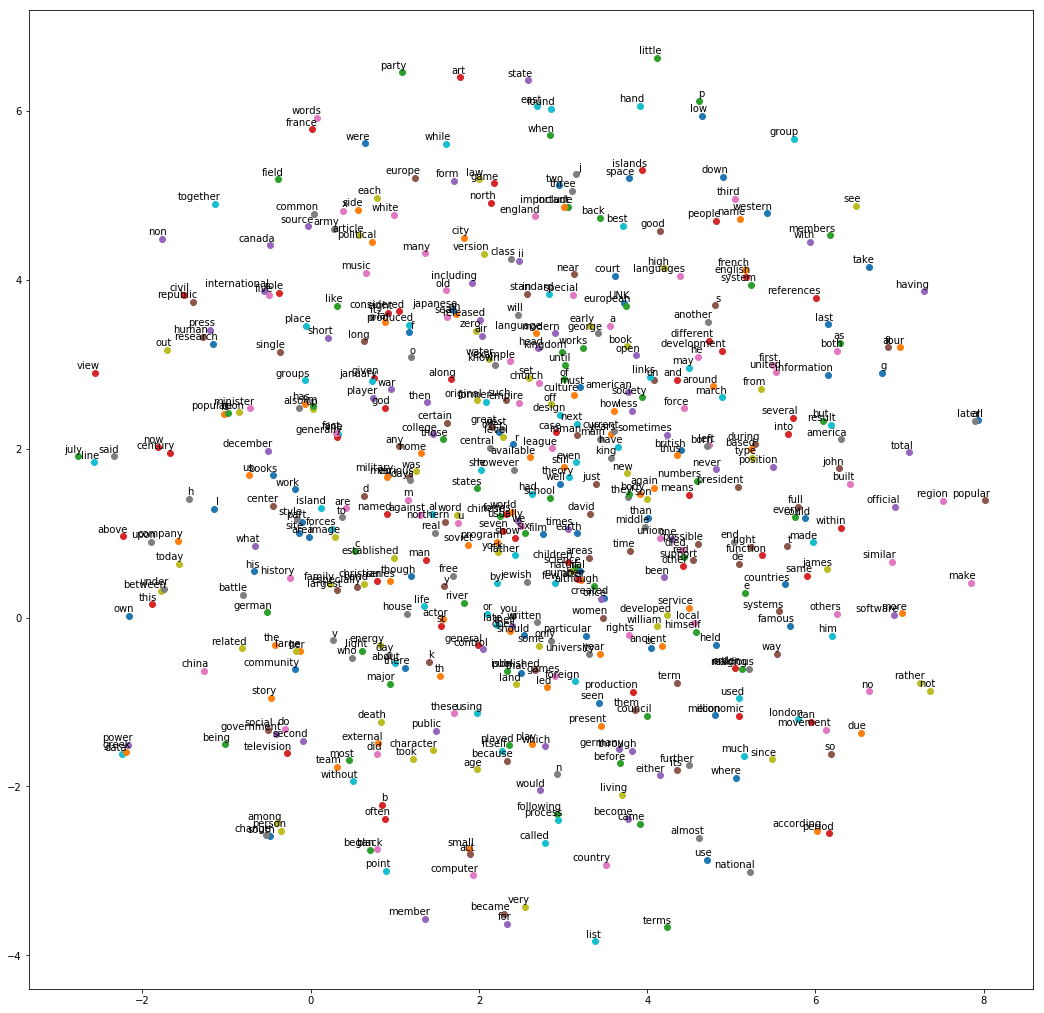

In [50]:
# Step 6: embeddings 시각화

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))        # in inches

    # 원본 코드.
    # 해당 좌표에 점을 표시하고, 오른쪽/하단 정렬로 단어를 표시한다.
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i]

        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    # 재구성한 코드
    # for (x, y), label in zip(low_dim_embs, labels):
    #     plt.scatter(x, y)
    #     plt.annotate(label,
    #                  xy=(x, y),
    #                  xytext=(5, 2),
    #                  textcoords='offset points',
    #                  ha='right',
    #                  va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    # low_dim_embs 내부 갯수와 n_components가 같아야 한다.
    # n_components : 차원. default는 2.
    # perplexity : 가장 가까운 이웃 갯수. 보통 5~50. default는 30.
    # n_iter : 최적화에 사용할 반복 횟수. 최소 200. default는 1000.
    # init : embedding 초기화 방법. random과 pca 중에서 선택. pca가 보다 안정적. default는 random.
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

    # plot 갯수. 50000개의 embeddings로부터 앞쪽 일부만 사용.
    # low_dim_embs에는 변환된 좌표 x, y가 들어있다.
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only])     # (500, 2)
    labels = ordered_words[:plot_only]                                  # 재구성한 코드
    # labels = [ordered_words[i] for i in range(plot_only)]             # 원본 코드

    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

